<h1><center>MSc Data Science and Artificial Intelligence <br/><br/> May 2023 <br/><br/> Implementation and Performance Evaluation of Traditional and Differential Approaches In Mining Association Rules from Offline Retail Transactions <br/><br/> by <br/><br/> David Anda </center></h1>


**Project Artefact Aim:** This artefact aims to implement reproducible experiments to meet the project objectives and provide answers to the research questions stated in the project report

The phases of **CRISP-DM methodology** explained in the methodology section of the project report would be used as to guide this artefact.

<br/>

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#bizunderstanding"> Business Understanding</a></li>
<li><a href="#dataunderstanding">Data Understanding</a></li>
<li><a href="#dataprep">Data Preparation</a></li>
<li><a href="#model">Modeling and Evaluation</a></li>
</ul>

<a id='intro'></a>
# INTRODUCTION

The datasets used for these experiments were provided by the retail business and have been anonymized to remove private information. These datasets contain sale transactions over a one-year period for one store location and also category attribute information of every item sold over this period. The project objectives are restated below and areas of focus to answer the research questions are also stated:

* Research Question 1: How can association rule mining techniques be effectively applied to retail transactions data to uncover interesting item patterns and associations?

* Research Question 2: How can differential  rule mining approaches such as time hierarchies, item value and specific day sales  improve the significance of association rules?

* Research Question 3: How can differential rule mining approaches improve the performance of association rule mining algorithms in terms of speed and memory usage?

The corresponding specific objectives of this project are as follows:

* Collect offline retail transactions datasets from retail business and preprocess them for the generation of association rules
* To develop an effective association rule mining system to extract association rules from retail transactions data using traditional and differential approaches
* Conduct experiments to evaluate the performance impact of differential approaches in mining association rules in comparison to the traditional approach


#### Installing Required Python Libraries

In [444]:
!pip3 install -q -r requirements.txt

<a id='dataunderstanding'></a>
# DATA UNDERSTANDING

#### Importing Required Libraries

In [2]:
# To use operating system dependent functionality
import os
import time
import psutil

# Data Analysis and manipulation libraries
import pandas as pd 
import numpy as np
from statistics import mean

# Data plotting libraries
import matplotlib.pyplot as plt
import seaborn as sb
import squarify

# Tools and extensions for modeling phase (ARM algorithms)
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display 

# Setting display optiions for tables and numbers
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.float_format',  '{:,.4f}'.format)

## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Function Definitions to Merge Datasets
These functions are created for convenience to merge all 12 transaction datasets and the attribute dataset together for data exploration

In [3]:
# Function to combine all transaction files into one csv file
def combine_transaction_datasets(folder_path, file_extension):
    """Reads in all files with the specified file extension a folder, and combines them into a single DataFrame.
    
    Parameters:
    folder_path (str): The path to the folder containing the files to combine.
    file_extension (str): The file extension of the files to combine ('csv')
    
    Returns:
    The combined DataFrame.
    """
    # Gets a list of all files in the folder with the specified file extension
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(file_extension)]

    # Read in each file as a DataFrame and combine them
    df_list = []
    for file in file_list:
        df = pd.read_csv(file, parse_dates=['Bill Dt.']) # 
        df_list.append(df)
    combined_df = pd.concat(df_list)

    return combined_df

In [4]:
# function to merge the combined csv file with the item attribute csv file
def merge_datasets(dataset1, dataset2, merge_column, merge_type):
    """Merge two DataFrames on a specified column.
    
    Parameters:
    dataset1 (pandas.DataFrame): The first DataFrame to merge.
    dataset2 (pandas.DataFrame): The second DataFrame to merge.
    merge_column (str): The name of the column to merge on.
    
    Returns:
    The merged DataFrame.
    """
    merged_df = pd.merge(dataset1, dataset2, on=merge_column, how=merge_type)
    return merged_df


### Merging and Exploring Datasets

In [5]:
# change this path to the folder that contains all monthly transaction datasets
transactions_data = "C:/Users/David-Anda/Desktop/project_files/dataset" 

# change this path to the 'itemmaster.csv' dataset
item_attribute_data = pd.read_csv("C:/Users/David-Anda/Desktop/project_files/itemmaster.csv") # read item attribute file

# calls the functions to combine and merge datasets
sales_data = merge_datasets(combine_transaction_datasets(transactions_data, 'csv'), item_attribute_data, 'Item Code', 'inner')

# see samples of merged files 
sales_data.head()
sales_data.tail()

Bill No   Bill Dt.  Item Code                               Item Name   
0  CA85955 2020-04-01       5135  40 LEAVES NOTE / BACK TO SCHOOL/CAMPUS  \
1  CC87826 2020-04-07       5135  40 LEAVES NOTE / BACK TO SCHOOL/CAMPUS   
2  CC88942 2020-04-10       5135  40 LEAVES NOTE / BACK TO SCHOOL/CAMPUS   
3  CA91680 2020-04-17       5135  40 LEAVES NOTE / BACK TO SCHOOL/CAMPUS   
4  CC94711 2020-04-25       5135  40 LEAVES NOTE / BACK TO SCHOOL/CAMPUS   

   Units  Sold Qty  Purchase Price  Item Rate             Major Category  
0      1    1.0000         54.1700    80.0000  OFFICE & SCHOOL SUPPLIERS  
1      1    6.0000         54.1700    80.0000  OFFICE & SCHOOL SUPPLIERS  
2      1    2.0000         54.1700    80.0000  OFFICE & SCHOOL SUPPLIERS  
3      1    1.0000         54.1700    80.0000  OFFICE & SCHOOL SUPPLIERS  
4      1    1.0000         54.1700    80.0000  OFFICE & SCHOOL SUPPLIERS

Bill No   Bill Dt.  Item Code                        Item Name   
769078  CC192683 2020-09-27      25049            TRS BASMATI RICE 10KG  \
769079  CC193801 2020-09-29      13154   MULTI PURPOSE COMPOTE SQ/ROUND   
769080  CC193568 2020-09-29       3572  SIMILAC PRO-ADVANCE INFANT 964g   
769081  CC194541 2020-09-30       1141      AMEL SUSAN BAKING FLOUR 1KG   
769082  CC194541 2020-09-30       2197   KIDS ORGANIC PROTEIN & VITAMIN   

        Units  Sold Qty  Purchase Price   Item Rate          Major Category  
769078      1    1.0000     17,000.0000 21,350.0000       BISCUITS & SNACKS  
769079      1    1.0000      1,000.0000  1,200.0000       KITCHEN & DINNING  
769080      1    1.0000     19,666.6700 23,600.0000  BABY- KID & MOTHERCARE  
769081      1    1.0000        600.0000    780.0000           FOOD CUPBOARD  
769082      1    1.0000      1,313.0000  1,580.0000  BABY- KID & MOTHERCARE

This shows snapshots of the merged datasets displaying transaction ids, date of transaction, item code, item name, item purchase and sales price and the item category. <br>

**Note:** Sold Qty for items in the FOOD HUB Major Category can be less than 1 as these are food items sold by weight (kg)

---

This section checks for data quality issues (completeness and cleanliness) and explores the dataset to understand frequency distribution of variables in the dataset

In [6]:
# dataset information
sales_data.info()

# descriptive statistics of dataset
sales_data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769083 entries, 0 to 769082
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Bill No         769083 non-null  object        
 1   Bill Dt.        769083 non-null  datetime64[ns]
 2   Item Code       769083 non-null  int64         
 3   Item Name       769083 non-null  object        
 4   Units           769083 non-null  int64         
 5   Sold Qty        769083 non-null  float64       
 6   Purchase Price  769083 non-null  float64       
 7   Item Rate       769083 non-null  float64       
 8   Major Category  769083 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 52.8+ MB


count                           mean   
Bill Dt.             769083  2020-10-12 08:18:31.507599872  \
Item Code      769,083.0000                    11,873.9658   
Units          769,083.0000                         1.0003   
Sold Qty       769,083.0000                         1.9131   
Purchase Price 769,083.0000                       450.9377   
Item Rate      769,083.0000                       645.6177   

                                min                  25%                  50%   
Bill Dt.        2020-04-01 00:00:00  2020-07-17 00:00:00  2020-10-18 00:00:00  \
Item Code                    2.0000           7,057.0000          10,766.0000   
Units                        1.0000               1.0000               1.0000   
Sold Qty                     0.0000               1.0000               1.0000   
Purchase Price               0.0000              75.0000             200.9800   
Item Rate                    5.0000             120.0000             330.0000   

                                75%                  max        std  
Bill Dt.        2021-01-10 00:00:00  2021-03-26 00:00:00        NaN  
Item Code               15,917.0000          28,102.0000 6,539.7906  
Units                        1.0000              13.0000     0.0276  
Sold Qty                     2.0000             600.0000     3.6397  
Purchase Price             511.1100          89,583.3300   819.9142  
Item Rate                  780.0000         100,000.0000 1,047.2702

On observation, the dataset contains 769,083 transactions with no null entry. Data formats are all accurate and the field identities are clear. <br> The minimum sold quantity and purchase price values are 0 which indicate a data validation error and would be investigated further

---

The data validation issues with the sold quantity and purchase price fields are explored

In [7]:
# filter for instances where purchase prices are equal to 0
zero_purchase_price = sales_data[sales_data['Purchase Price'] < 1].drop_duplicates(subset=['Item Name'])

# filter for instances where purchase prices are equal to or greater than sales price
purchase_greater_equal = sales_data[sales_data['Purchase Price'] >= sales_data['Item Rate']].drop_duplicates(subset=['Item Name'])

purchase_equal_1 = sales_data[sales_data['Purchase Price'] == 1.0000].drop_duplicates(subset=['Item Name'])

# filter for instances where sold quantity is equal to 0 (excluding FOOD HUB items that are sold by weight)
zero_sold_quantity = sales_data[sales_data['Sold Qty'] == 0.0000].drop_duplicates(subset=['Item Name'])


# see results
zero_purchase_price.head()
purchase_greater_equal.head()
purchase_equal_1.head()
zero_sold_quantity.head()

Bill No   Bill Dt.  Item Code                Item Name  Units   
41125   CA224838 2020-11-12       5997  DETTOL ANTISEPTIC 165ML      1  \
128536   CA54511 2021-03-05      14982              JOLLOF RICE      1   
209648   CA85858 2020-04-01      12062   IRECHARGE AIRTIME N100      1   
212321   CA85870 2020-04-01      12063  IRECHARGE AIRTIME N1000      1   
212836   CA86039 2020-04-01      11960  IRECHARGE CABLE TV N100      1   

        Sold Qty  Purchase Price  Item Rate        Major Category  
41125     1.0000          0.0100   610.0000  HOME CARE & CLEANING  
128536    0.5100          0.0500 1,087.8000              FOOD HUB  
209648    1.0000          0.0100   100.0000            I RECHARGE  
212321    1.0000          0.0100 1,000.0000            I RECHARGE  
212836   69.0000          0.0100   100.0000            I RECHARGE

Bill No   Bill Dt.  Item Code   
2208   CA254439 2020-12-17      16837  \
5539    CC57026 2021-03-07      10635   
34409  CC195370 2020-10-01       1625   
35004  CA156948 2020-08-08      15942   
42423  CA240977 2020-12-01      22524   

                                                                         Item Name   
2208                                ALUBADIYA SEASONING POWDER COCONUT FLAVOUR 10G  \
5539                                         ANADARIYA FULL CHICKEN  8 CUT / 9 CUT   
34409                                                        COWBELL CHOCOLATE 20g   
35004                                                         CWAY DISPENSER WATER   
42423  DOVE NOURISHING SECRETS REPLENISHING RITUAL MARULA OIL & MANGO BUTTER 400ML   

       Units  Sold Qty  Purchase Price  Item Rate      Major Category  
2208       1    1.0000         20.4500    20.0000       FOOD CUPBOARD  
5539       1    1.0000      2,458.3300 2,300.0000        FROZEN FOODS  
34409      1   10.0000         30.0000    30.0000  BEVERAGES & DRINKS  
35004      1    1.0000        500.0000   500.0000  BEVERAGES & DRINKS  
42423      1    1.0000      1,425.0000 1,300.0000           SKIN CARE

Bill No   Bill Dt.  Item Code                       Item Name  Units   
180234  CA104155 2020-05-16      10894                         RAISINS      1  \
202628   CC90467 2020-04-14       9600  HARPIC POWER PLUS CITRUS 450ML      1   
519554   CA93524 2020-04-22       6861         JIK REGULAR 1.5LTR/1.4L      1   
519792   CA93501 2020-04-22       6863          JIK REGULAR 1LTR/950ML      1   
520058   CC93448 2020-04-22       6865          JIK REGULAR 475/ 500ML      1   

        Sold Qty  Purchase Price  Item Rate        Major Category  
180234    7.0000          1.0000   350.0000                BAKERY  
202628    1.0000          1.0000   800.0000  HOME CARE & CLEANING  
519554    1.0000          1.0000 1,020.0000  HOME CARE & CLEANING  
519792    1.0000          1.0000   700.0000  HOME CARE & CLEANING  
520058    1.0000          1.0000   410.0000  HOME CARE & CLEANING

Bill No   Bill Dt.  Item Code                            Item Name   
50707   CA153560 2020-08-02       1638        FANICE STRAWBERRY CREAM 120ML  \
187784  CA194228 2020-09-30      15020                   VEGETABLE COLESLAW   
314479  CA152750 2020-08-01      10971       FANICE VANILLA ICE CREAM 120ML   
328617  CC153117 2020-08-02      19443  INDOMIE ORIENTAL STANDARD PACK 100G   
330215   CC94022 2020-04-23      19491    KELLOGGS CORNFLAKES NIGERIAN 500G   

        Units  Sold Qty  Purchase Price  Item Rate Major Category  
50707       1    0.0000        139.5300   180.0000   FROZEN FOODS  
187784      1    0.0000        479.9500   999.9900       FOOD HUB  
314479      1    0.0000        108.2100   190.0000   FROZEN FOODS  
328617      1    0.0000         75.0000   100.0000  FOOD CUPBOARD  
330215      1    0.0000          0.0100   850.0000  FOOD CUPBOARD

There are several items that have purchase prices as 0 with some other situations where purchase prices are equal to or higher than the selling price. There are also several instances where items that have been sold do not have sold qty recorded. All these issues would be handled in the data preparation phase.

---

### Data Visualisaton
The dataset is visualised to see the most popular items purchased by customers, the top selling categories the and the busiest days.

In [8]:
# function to group the dataset by a field, count the number of times it appears and visualise the top 10
def plot_field_distribution(dataset, field, n=10):
    """
    Plots the top 10 of the specified field from the dataset.

    Parameters:
        dataset (DataFrame): The dataset containing the fields to aggregate and visualise
        n (int): The number of fieldds to display. Default is 10.

    Returns:
        The matplotlib Axes object containing the plot.
    """
    # Perform a groupby operation to calculate item frequencies
    item_counts = dataset.groupby(field).size().reset_index(name='count')

    # Sort the items based on frequencies in descending order
    sorted_items = item_counts.sort_values(by='count', ascending=False)

    # Select the top N items
    top_items = sorted_items.head(n)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(6, 4))
    cols = ['deepskyblue' if (x < top_items['count'].max()) else 'darkorange' for x in top_items['count']]
    sb.barplot(x='count', y=field, data=top_items, palette=cols)
    plt.xlabel('Frequency')
    plt.ylabel(field)

    # Display the plot
    plt.show()
    
    # Return the plot
    return plt


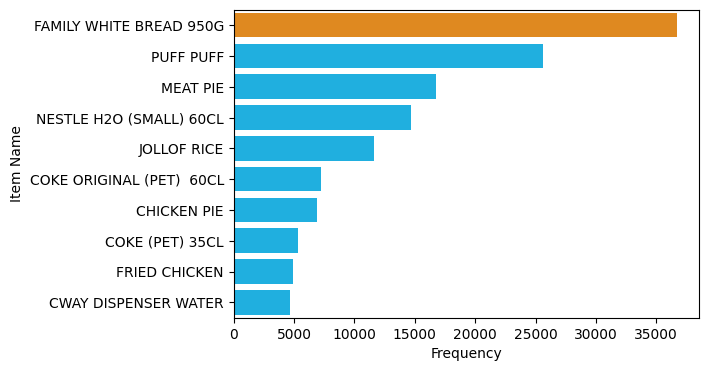

<module 'matplotlib.pyplot' from 'C:\\Users\\David-Anda\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\David-Anda\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

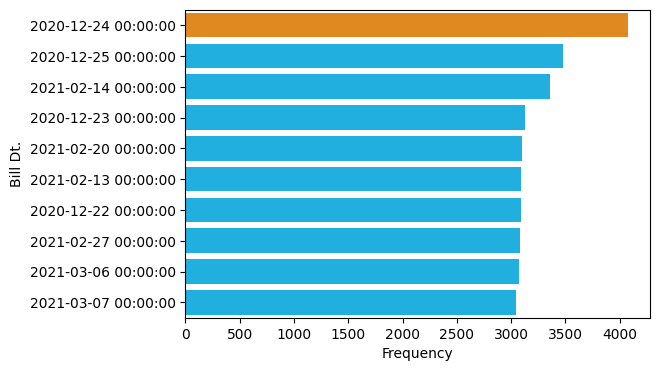

<module 'matplotlib.pyplot' from 'C:\\Users\\David-Anda\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
plot_field_distribution(sales_data, 'Item Name')
plot_field_distribution(sales_data, 'Major Category')
plot_field_distribution(sales_data, 'Bill Dt.')

* The items that appeared the most in transations are mainly cooked food items, soft drinks and water.
* The top categories are the food related categories and then household and cleaning.
* Most transactions happened during christmas, particulary on christmas eve and on christmas day of 2020 followed by valentines day in 2021. 

<a id='dataprep'></a>
# DATA PREPARATION

##### Handling Purchase Price Issue

In [10]:
# function to return the latest date an item was sold
def latest_date_agg(dataset):
    """
    Aggregates the purchase price and sale price values using the latest sale date of the item the dataset.

    Parameters:
        dataset (DataFrame): The dataset containing the sale date, purchase prices and sales prices

    Returns:
        The latest values for the purchase and sales price of an item
    """
    # Find the latest date in the dataset
    latest_date = dataset['Bill Dt.'].max()

    # Filter the data for the latest date
    latest_data = dataset[dataset['Bill Dt.'] == latest_date]

    # Calculate the sum of 'Purchase Price' and 'Item Rate' for the latest date
    agg_values = {
        'Purchase Price': latest_data['Purchase Price'].sum(),
        'Item Rate': latest_data['Item Rate'].sum()
    }

    # Convert the aggregated values to a pandas Series
    return pd.Series(agg_values)


In [11]:
def dataframe_to_dict(dataset, key_col, value_col):
    """
    Converts two columns from a DataFrame into a dictionary.
    
    Parameters:
        dataset (DataFrame): The DataFrame to convert to a dictionary.
        key_col (str): The name of the column to use as keys in the dictionary.
        value_col (str): The name of the column to use as values in the dictionary.
    
    Returns:
        A dictionary with keys from the specified key column and values from the specified value column.
    """
    key_values = dataset[key_col].tolist()
    value_values = dataset[value_col].tolist()
    
    result_dict = dict(zip(key_values, value_values))
    
    return result_dict


In [12]:
def replace_price_values(dataset, purchase_col, sale_col, replace_purchase_dict, replace_sale_dict):
    """
    Replace the purchase and sale price values using a dictionary of the prices to replace with.
    
    Parameters:
        dataset (DataFrame): The Dataset to replace the price values of.
        purchase_col (str): The name of the purchase price column.
        sale_col (str): The name of the sales price column.
        replace_purchase_dict (dict): A dictionary of the purchase price values for each item.
        replace_sale_dict (dict): A dictionary of the sale price values for each item.
    
    Returns:
        The dataset with values replaced.
    """
    df = dataset.copy()
    
    df['Purchase Price'] = df['Item Name'].map(replace_purchase_dict)
    df['Item Rate'] = df['Item Name'].map(replace_sale_dict)

    return df


In [13]:
# function to replace purchse prices using the markup percentage value of the item's category
def markup_cleanup(dataset, item_name):
    """
    Replace purchase price values using the category markup value of the item
    
    Parameters:
        dataset (DataFrame): The dataset to replace values in.
        item_name (str): The name of the column to use as a condition for replacement.
    
    Returns:
        The dataset with purchase price values replaced.
    """
    
    df = dataset.copy()
    
    dataset = dataset.set_index('Item Name')
    if type(dataset.loc[item_name,'Major Category']) == str:
        find_category = dataset.loc[item_name,'Major Category']
    else:
        find_category = dataset.loc[item_name,'Major Category'].unique()[0]

    category_name = find_category
    
    df1 = df[(df['Major Category'] ==  category_name) 
                         & (df['Item Name'] !=  item_name)].drop_duplicates(subset=['Item Name'])
    
    markup_value = df1.describe().loc['50%','Markup (%)']
    
    dataset = dataset.reset_index()
    
    dataset.loc[dataset['Major Category'] == category_name, 'Purchase Price'] = dataset['Item Rate'] / (1 + (markup_value / 100))
    
    return dataset


# function to apply the markup changes to multiple items at once
def group_markup_cleanup(listofitems, dataset):
    
    for item in listofitems:
        dataset = markup_cleanup(dataset, item)
    return dataset
    

In [14]:
# function to fix all price issues, leveraging the previous functions
def price_fix(dataset):
    """
    Handles all price issues leveraging previously defined functions.
    
    Parameters:
        dataset (DataFrame): The dataset with price issues.
    
    Returns:
        The dataset with price issues handled.
    """
    
    df = dataset.copy()

    recent_data = pd.DataFrame(df.groupby('Item Name').apply(latest_date_agg)).reset_index()
    recent_data[['Purchase Price', 'Item Rate']] = recent_data[['Purchase Price', 'Item Rate']].astype('float64')

    purchase = dataframe_to_dict(recent_data, 'Item Name', 'Purchase Price')
    selling = dataframe_to_dict(recent_data, 'Item Name', 'Item Rate')

    cleaned_sales_data = replace_price_values(df, 'Purchase Price', 'Item Rate', purchase, selling)

    #reference from finding out commission rate
    cleaned_sales_data.loc[cleaned_sales_data['Major Category'] == 'I RECHARGE', 'Purchase Price'] = cleaned_sales_data['Item Rate'] * 0.95

    cleaned_sales_data = cleaned_sales_data[cleaned_sales_data['Item Name'] != 'CARTON SCRAP']

    # create the column and specify the function to use
    cleaned_sales_data['Markup (%)'] = abs(cleaned_sales_data['Item Rate'] - cleaned_sales_data['Purchase Price']) / cleaned_sales_data['Purchase Price'] * 100

    purchase_greater_selling = cleaned_sales_data[cleaned_sales_data['Purchase Price'] >= cleaned_sales_data['Item Rate']]['Item Name'].unique().tolist()
    purchase_equal_zero = cleaned_sales_data[cleaned_sales_data['Purchase Price'] < 1]['Item Name'].unique().tolist()
    purchase_equal_1 = cleaned_sales_data[cleaned_sales_data['Purchase Price'] == 1.0000]['Item Name'].unique().tolist()

    items_to_clean = purchase_greater_selling + purchase_equal_zero + purchase_equal_1

    cleaned_df = group_markup_cleanup(items_to_clean, cleaned_sales_data)

    return cleaned_df


In [15]:
# fixing the price issues of the dataset - might take a minute!
cleaned_dataset = price_fix(sales_data)

In [16]:
# Verifying that all data validity issues regarding the purchase prices have been fixed
cleaned_dataset[cleaned_dataset['Purchase Price'] >= cleaned_dataset['Item Rate']]
cleaned_dataset[cleaned_dataset['Purchase Price'] < 1]

Empty DataFrame
Columns: [Item Name, Bill No, Bill Dt., Item Code, Units, Sold Qty, Purchase Price, Item Rate, Major Category, Markup (%)]
Index: []

Empty DataFrame
Columns: [Item Name, Bill No, Bill Dt., Item Code, Units, Sold Qty, Purchase Price, Item Rate, Major Category, Markup (%)]
Index: []

All price issues have now been fixed as both filters return empty datasets.

---

##### Handling Sales Quantity Issue
All items with sale quantity as 0 were changed to 1 as there was no way to verify the actual sale quantities

In [17]:
# changing 0 sold quantities to 1
cleaned_dataset.loc[cleaned_dataset['Sold Qty'] == 0.0000, 'Sold Qty'] = 1.0000

# verifying that no items have a sold quantity of 0
cleaned_dataset[cleaned_dataset['Sold Qty'] == 0.0000]

Empty DataFrame
Columns: [Item Name, Bill No, Bill Dt., Item Code, Units, Sold Qty, Purchase Price, Item Rate, Major Category, Markup (%)]
Index: []

All sold quantity issues have now been fixed as the filter returns an empty dataset.

---

## Constructing Required Data

Now the final attributes needed to run differential rule mining experiments on the datasets are created. The Date column is used to derive month name and day name while the purchase price, sales price and sold quantity are used to calculate profit percentages.

This function helps perform these transformations on the dataset and returns a new sataset with the derived attributes. The Markup column used to correct the purchase price issues is dropped from the dataset at this point.


In [18]:
def differential_dataset(dataset):

    df = dataset.copy()

    df['Item Profit (%)'] = ((df['Item Rate'] - df['Purchase Price'])/df['Purchase Price']) * 100
    df['Sale Profit'] = (df['Sold Qty'] * df['Item Rate']) - (df['Sold Qty'] * df['Purchase Price'])
    df['Sale Revenue'] = df['Sold Qty'] * df['Item Rate']
    df['Sale Year'] = df['Bill Dt.'].dt.year
    df['Sale Day'] = df['Bill Dt.'].dt.day_name()
    df['Sale Month'] = df['Bill Dt.'].dt.month_name()
    df['Sale Day Type'] = df['Sale Day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

    df = df.drop(columns=['Markup (%)'])

    df = df[['Bill No', 'Bill Dt.', 'Sale Year', 'Sale Month', 'Sale Day', 'Sale Day Type', 'Item Code', 'Item Name',   
           'Major Category','Units', 'Sold Qty', 'Purchase Price', 'Item Rate', 'Item Profit (%)', 'Sale Profit', 'Sale Revenue']]

    df.rename(columns = {'Bill No': 'Transaction ID','Bill Dt.':'Transaction Date'}, inplace = True)

    return df


In [19]:
differential_sales_data = differential_dataset(cleaned_dataset)
differential_sales_data.tail()

Transaction ID Transaction Date  Sale Year Sale Month   Sale Day   
769069       CC192683       2020-09-27       2020  September     Sunday  \
769070       CC193801       2020-09-29       2020  September    Tuesday   
769071       CC193568       2020-09-29       2020  September    Tuesday   
769072       CC194541       2020-09-30       2020  September  Wednesday   
769073       CC194541       2020-09-30       2020  September  Wednesday   

       Sale Day Type  Item Code                        Item Name   
769069       Weekend      25049            TRS BASMATI RICE 10KG  \
769070       Weekday      13154   MULTI PURPOSE COMPOTE SQ/ROUND   
769071       Weekday       3572  SIMILAC PRO-ADVANCE INFANT 964g   
769072       Weekday       1141      AMEL SUSAN BAKING FLOUR 1KG   
769073       Weekday       2197   KIDS ORGANIC PROTEIN & VITAMIN   

                Major Category  Units  Sold Qty  Purchase Price   Item Rate   
769069       BISCUITS & SNACKS      1    1.0000     16,982.9545 21,350.0000  \
769070       KITCHEN & DINNING      1    1.0000        952.3810  1,200.0000   
769071  BABY- KID & MOTHERCARE      1    1.0000     19,666.6667 23,600.0000   
769072           FOOD CUPBOARD      1    1.0000        650.0000    780.0000   
769073  BABY- KID & MOTHERCARE      1    1.0000      1,316.6667  1,580.0000   

        Item Profit (%)  Sale Profit  Sale Revenue  
769069          25.7143   4,367.0455   21,350.0000  
769070          26.0000     247.6190    1,200.0000  
769071          20.0000   3,933.3333   23,600.0000  
769072          20.0000     130.0000      780.0000  
769073          20.0000     263.3333    1,580.0000

In [434]:
# setting the dimensions of the plot
sale_day = pd.DataFrame(differential_sales_data.groupby(['Sale Day'])['Sale Revenue'].sum().sort_values(ascending=False)).reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
cols = ['deepskyblue' if (x < sale_day['Sale Revenue'].max()) else 'darkorange' for x in sale_day['Sale Revenue']]

sale_day
sb.barplot(data=sale_day, x="Sale Day", y="Sale Revenue", palette=cols, ax=ax)

Sale Day     Sale Revenue
0   Saturday 968,793,362.2692
1     Friday 836,514,544.9493
2     Sunday 836,500,831.5646
3  Wednesday 810,362,871.8220
4   Thursday 799,903,984.0562
5    Tuesday 778,065,885.2708
6     Monday 762,395,354.2048

<Axes: xlabel='Sale Day', ylabel='Sale Revenue'>

In [21]:
# setting the dimensions of the plot
sale_month = pd.DataFrame(differential_sales_data.groupby(['Sale Month'])['Sale Revenue'].sum().sort_values(ascending=False)).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
cols = ['deepskyblue' if (x < sale_month['Sale Revenue'].max()) else 'darkorange' for x in sale_month['Sale Revenue']]

sale_month
sb.barplot(data=sale_month, x="Sale Month", y="Sale Revenue", palette=cols, ax=ax)

Sale Month     Sale Revenue
0    December 571,325,928.3956
1     January 550,197,228.7524
2   September 532,390,672.4072
3    November 525,930,190.8912
4       March 508,932,998.3562
5    February 502,250,564.8934
6      August 473,430,655.5042
7     October 471,658,218.6428
8        July 471,269,179.4179
9        June 458,696,819.1428
10        May 377,697,667.4850
11      April 348,756,710.2482

<Axes: xlabel='Sale Month', ylabel='Sale Revenue'>

<a id='model'></a>
# MODELING AND EVALUATION

##### Data Structure conversion for Algorithm

In [22]:
# Function to convert data structure of the dataset into a format suitable for the algorithms
def transactions_to_nestedlist(dataset):
    """
    Convert a transactions database into a list of lists.
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        A transactions database containing the details of sales transactions.
    
    Returns:
    --------
    list of lists
        A list of lists where each inner list contains the items in a single transaction.
    """
    # Group the transactions by their receipt number
    grouped_transactions = dataset.groupby('Transaction ID')
    
    # Extract the items for each receipt and store them in a list
    transactions_list = [grouped_transactions.get_group(x)['Item Name'].tolist() 
                         for x in grouped_transactions.groups]
    
    return transactions_list


###### Algorithm

In [23]:
# Main Algorithm Function to mine association rules
def association_mining(dataset, category=None, exact_day=None, day=None, day_type=None, month=None, profit=False, algorithm=fpgrowth, min_support=0.001, metric='lift', min_threshold=1.5):
    """
    Returns a filtered dataset based on given filters.

    Args:
    - dataset: pandas dataframe, the original dataset
    - category: str or list of str, default None. The category or list of categories to filter by.
    - day: str or list of str, default None. The day or list of days to filter by.
    - day_type: str, default None. The type of day to filter by (weekday or weekend).
    - profit: bool, default False. Whether or not to filter by transactions with profit greater than 30%.

    Returns:
    - filtered_df: pandas dataframe, the filtered dataset

    """
    filtered_df = dataset.copy()
    
    # Filter by category
    if category:
        # Checks if the value is a list
        if not isinstance(category, list):
            raise ValueError("category value must be a list")
            
        # List of allowed values    
        allowed_values = dataset['Major Category'].unique().tolist()
        
        # Check if the value is among the allowed values
        if not all(val in allowed_values for val in category):
            raise ValueError("category must be a list containing only the allowed values: {}".format(allowed_values))
            
        filtered_df = dataset[dataset['Major Category'].isin(category)]
            
            
    # Filter by exact_day
    if exact_day:
        # Checks if the value is a list
        if not isinstance(exact_day, list):
            raise ValueError("exact_day value must be a list")
            
        # List of allowed values    
        allowed_values = dataset['Transaction Date'].unique().tolist()
        
        # Check if the value is among the allowed values
        if not all(val in allowed_values for val in exact_day):
            raise ValueError("exact_day must be a list containing only the allowed values: {}".format(allowed_values))
            
        filtered_df = dataset[dataset['Transaction Date'].isin(exact_day)]


    # Filter by day
    if day:
        # Checks if the value is a list
        if not isinstance(day, list):
            raise ValueError("day value must be a list")
            
        # List of allowed values    
        allowed_values = dataset['Sale Day'].unique().tolist()
        
        # Check if the value is among the allowed values
        if not all(val in allowed_values for val in day):
            raise ValueError("day must be a list containing only the allowed values: {}".format(allowed_values))
            
        filtered_df = dataset[dataset['Sale Day'].isin(day)]
        

    # Filter by month
    if month:
        # Checks if the value is a list
        if not isinstance(month, list):
            raise ValueError("month value must be a list")
            
        # List of allowed values    
        allowed_values = dataset['Sale Month'].unique().tolist()
        
        # Check if the value is among the allowed values
        if not all(val in allowed_values for val in month):
            raise ValueError("month must be a list containing only the allowed values: {}".format(allowed_values))
            
        filtered_df = dataset[dataset['Sale Month'].isin(month)]


    # Filter by profit
    if profit:
        filtered_df = filtered_df[filtered_df['Item Rate'] >= 4200.0000] #75% of items are below this amount
        

    # ALGORITHMS
    df = transactions_to_nestedlist(filtered_df.reset_index(drop=True))
    
    te = TransactionEncoder()
    te_ary = te.fit(df).transform(df)
    df1 = pd.DataFrame(te_ary, columns=te.columns_)

    if algorithm == fpgrowth:
        frequent_itemsets = algorithm(df1, min_support=min_support, use_colnames=True)
    else:
        frequent_itemsets = algorithm(df1, min_support=min_support, use_colnames=True,  low_memory=True)

    #frequent_itemsets = algorithm(df2, min_support=min_support, use_colnames=True,  low_memory=True, verbose=1)
    df_association_rules = association_rules(frequent_itemsets, metric=metric, min_threshold= min_threshold)

    return df_association_rules


###### Extract rules and performance stats with diffferent support values

In [25]:
def extract_association_rules(data, min_supports, category=None, exact_day=None, day=None, day_type=None, month=None, profit=False, algorithm=fpgrowth, min_support=0.001, metric='lift', min_threshold=1.5):
    # Create a list to store the execution times
    execution_times = []
    memory_consumptions = []
    
    # Initialize variables to store association rules
    association_rules = []
    
    # Iterate over the minimum thresholds
    for i, support in enumerate(min_supports):

        # Start timing the execution
        start_time = time.time()

        # Perform association mining with the given threshold
        rules = association_mining(data, min_support=support, algorithm=algorithm, day=day, month=month, exact_day=exact_day, profit=profit)

        # End timing the execution
        end_time = time.time()

        # Calculate the execution time in seconds
        execution_time = end_time - start_time

        # Append the execution time to the list
        execution_times.append(execution_time)


        # Append the memory consumption to the result list
        #memory_consumption = psutil.cpu_percent(execution_time)
        memory_consumptions.append(psutil.virtual_memory()[3]/1000000000)

        # Store the association rules in a list
        association_rules.append(rules)
    
    # Print or access the association rules variables outside the function
    return association_rules, execution_times, memory_consumptions


##### Visualise algorithm performance

In [26]:
def plot_algorithm_performance(support_values, apriori_values, fpgrowth_values, memory_consumption=False):
    # Set the style of the plot
    sb.set_style("whitegrid")
    
    # Create a DataFrame for the data
    data = pd.DataFrame({"Support": support_values,
                         "Apriori": apriori_values,
                         "FP-growth": fpgrowth_values})
    
    # Melt the DataFrame to have a tidy format
    melted_data = data.melt("Support", var_name="Algorithm", value_name="Performance")
    
    # Create the line plot
    if memory_consumption:
        sb.lineplot(data=melted_data, x="Support", y="Performance", hue="Algorithm", marker='o')
        plt.ylabel("Memory Consumption (GB)")
        title = "Memory Consumption - Apriori vs FP-growth Algorithm"
    else:
        sb.lineplot(data=melted_data, x="Support", y="Performance", hue="Algorithm", marker='o')
        plt.ylabel("Execution Speed (seconds)")
        title = "Execution Speed - Apriori vs FP-growth Algorithm"
    
    # Add labels and title
    plt.xlabel("Minimum Support Values")
    plt.xticks(support_values)
    plt.title(title)
    
    # Display the plot
    plt.show()


##### Evaluate Similar Association Rules 

In [27]:
# function to evaluate rules found in 2 different rule subsets
def similar_association_rules(df1, df2, df1_name, df2_name):
    # Extract the rules from the antecedent and consequent columns
    rules_df1 = set(zip(df1['antecedents'], df1['consequents']))
    rules_df2 = set(zip(df2['antecedents'], df2['consequents']))

    # Find the common rules between the dataframes
    common_rules = rules_df1.intersection(rules_df2)

    # Create a list to store the results
    result_list = []

    # Iterate over the common rules and extract the lift scores
    for rule in common_rules:
        antecedent, consequent = rule

        # Get the lift scores for each dataframe
        lift_df1 = df1.loc[(df1['antecedents'] == antecedent) & (df1['consequents'] == consequent), 'lift'].values[0]
        lift_df2 = df2.loc[(df2['antecedents'] == antecedent) & (df2['consequents'] == consequent), 'lift'].values[0]

        # Add the rule and lift scores to the result list
        result_list.append({'Association_Rule': f"{list(antecedent)} => {list(consequent)}",
                            'Lift_' + df1_name: lift_df1,
                            'Lift_' + df2_name: lift_df2})

    # Create the resulting dataframe from the list of dictionaries
    result_df = pd.DataFrame(result_list)

    return result_df


##### Evaluate Difference in Association Rules

In [28]:
# function to evaluate the difference in rules found in 2 rule subsets
def difference_association_rules(df1, df2, df1_name, df2_name):
    # Extract the rules from the antecedent and consequent columns
    rules_df1 = set(zip(df1['antecedents'], df1['consequents']))
    rules_df2 = set(zip(df2['antecedents'], df2['consequents']))

    # Find the rules present in df1 but not in df2
    df1_only_rules = rules_df1.difference(rules_df2)

    # Find the rules present in df2 but not in df1
    df2_only_rules = rules_df2.difference(rules_df1)

    # Create a list to store the results
    result_list = []

    # Iterate over the rules present in df1 but not in df2
    for rule in df1_only_rules:
        antecedent, consequent = rule

        # Get the lift score for df1
        lift_df1 = df1.loc[(df1['antecedents'] == antecedent) & (df1['consequents'] == consequent), 'lift'].values[0]

        # Add the rule and lift score to the result list
        result_list.append({'Association_Rule': f"{list(antecedent)} => {list(consequent)}",
                            'Lift_' + df1_name: lift_df1,
                            'Lift_' + df2_name: None})  # Lift score is not available in df2

    # Iterate over the rules present in df2 but not in df1
    for rule in df2_only_rules:
        antecedent, consequent = rule

        # Get the lift score for df2
        lift_df2 = df2.loc[(df2['antecedents'] == antecedent) & (df2['consequents'] == consequent), 'lift'].values[0]

        # Add the rule and lift score to the result list
        result_list.append({'Association_Rule': f"{list(antecedent)} => {list(consequent)}",
                            'Lift_' + df1_name: None,  # Lift score is not available in df1
                            'Lift_' + df2_name: lift_df2})

    # Create the resulting dataframe from the list of dictionaries
    result_df = pd.DataFrame(result_list)

    return result_df


## Traditional Approach

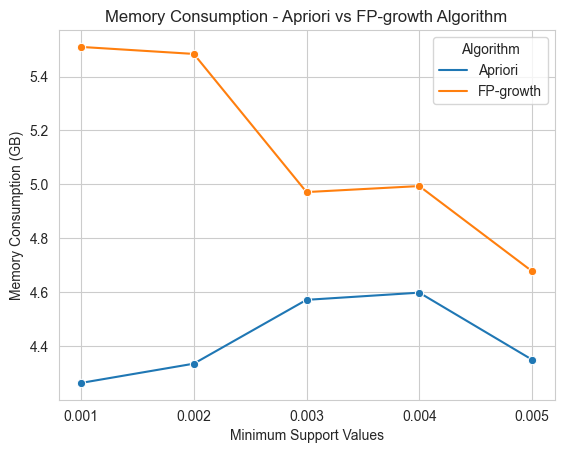

In [29]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
alldata_fpgrowth_extracted_rules, alldata_fpgrowth_execution_times, alldata_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, algorithm=fpgrowth)

# Access the association rules variables
alldata_fpgrowth_rules_1 = alldata_fpgrowth_extracted_rules[0]
alldata_fpgrowth_rules_2 = alldata_fpgrowth_extracted_rules[1]
alldata_fpgrowth_rules_3 = alldata_fpgrowth_extracted_rules[2]
alldata_fpgrowth_rules_4 = alldata_fpgrowth_extracted_rules[3]
alldata_fpgrowth_rules_5 = alldata_fpgrowth_extracted_rules[4]

# Call the function to extract association rules and measure memory usage
alldata_apriori_extracted_rules, alldata_apriori_execution_times, alldata_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, algorithm=apriori)

# Access the association rules variables
alldata_apriori_rules_1 = alldata_apriori_extracted_rules[0]
alldata_apriori_rules_2 = alldata_apriori_extracted_rules[1]
alldata_apriori_rules_3 = alldata_apriori_extracted_rules[2]
alldata_apriori_rules_4 = alldata_apriori_extracted_rules[3]
alldata_apriori_rules_5 = alldata_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=alldata_apriori_execution_times,
                           fpgrowth_values=alldata_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=alldata_apriori_memory_consumed,
                           fpgrowth_values=alldata_fpgrowth_memory_consumed, memory_consumption=True)



In [111]:
# HELPER FUNCTION TO CHECK AVAERGAE NUMBER OF ITEMS IN TRANSACTIONS
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length



differential_sales_data.info()

x = transactions_to_nestedlist(differential_sales_data)
len(x)
average_list_length(x)


len(alldata_fpgrowth_rules_1.sort_values('support', ascending=False))
len(alldata_apriori_rules_1.sort_values('support', ascending=False))

len(alldata_fpgrowth_rules_2.sort_values('support', ascending=False))
len(alldata_apriori_rules_2.sort_values('support', ascending=False))

len(alldata_fpgrowth_rules_3.sort_values('support', ascending=False))
len(alldata_apriori_rules_3.sort_values('support', ascending=False))

len(alldata_fpgrowth_rules_4.sort_values('support', ascending=False))
len(alldata_apriori_rules_4.sort_values('support', ascending=False))

len(alldata_fpgrowth_rules_5.sort_values('support', ascending=False))
len(alldata_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(alldata_apriori_execution_times)
sum(alldata_fpgrowth_execution_times)

mean(alldata_apriori_memory_consumed)
mean(alldata_fpgrowth_memory_consumed)

similar_association_rules(alldata_apriori_rules_5, alldata_fpgrowth_rules_5, 'apriori', 'fp-growth')

372

372

128

128

64

64

36

36

10

10

298.40370440483093

319.2724914550781

4.423323648

5.1272204288

Association_Rule  Lift_apriori  Lift_fp-growth
0   ['JOLLOF RICE'] => ['CHICKEN SUYA']        9.2565          9.2565
1       ['MEAT PIE'] => ['CHICKEN PIE']        5.6426          5.6426
2       ['CHICKEN PIE'] => ['MEAT PIE']        5.6426          5.6426
3  ['JOLLOF RICE'] => ['FRIED CHICKEN']        8.9863          8.9863
4   ['CHICKEN SUYA'] => ['JOLLOF RICE']        9.2565          9.2565
5      ['JOLLOF RICE'] => ['PUFF PUFF']        1.7372          1.7372
6      ['PUFF PUFF'] => ['JOLLOF RICE']        1.7372          1.7372
7         ['MEAT PIE'] => ['PUFF PUFF']        1.7016          1.7016
8  ['FRIED CHICKEN'] => ['JOLLOF RICE']        8.9863          8.9863
9         ['PUFF PUFF'] => ['MEAT PIE']        1.7016          1.7016

In [433]:
alldata_fpgrowth_rules_1.sample(frac=1).head(10)

antecedents   
79                          (MEAT PIE, SAUSAGE ROLL)  \
236  (PEAK MILK REFILL POUCH FULL CREAM 400G / 380G)   
288                                 (GOAT MEAT STEW)   
265                                      (CROISSANT)   
19                                     (JOLLOF RICE)   
329                        (FAMILY WHITE BREAD 950G)   
302                                    (JOLLOF RICE)   
156      (COKE (PET) 35CL, FANTA  ORANGE (PET) 35CL)   
287                                      (PUFF PUFF)   
104                                    (JOLLOF RICE)   

                          consequents  antecedent support  consequent support   
79                      (CHICKEN PIE)              0.0045              0.0269  \
236  (MILO SACHET MEDIUM 500G / 550G)              0.0062              0.0054   
288                     (JOLLOF RICE)              0.0064              0.0457   
265                       (PUFF PUFF)              0.0059              0.1000   
19                     (CHICKEN STEW)              0.0457              0.0081   
329              (SMALL GREEN APPLES)              0.1447              0.0037   
302                   (FRIED CHICKEN)              0.0457              0.0191   
156               (SPRITE (PET) 35CL)              0.0033              0.0070   
287                      (SCOTCH EGG)              0.1000              0.0039   
104  (SWAN NATURAL SPRING WATER 75CL)              0.0457              0.0111   

     support  confidence    lift  leverage  conviction  zhangs_metric  
79    0.0010      0.2231  8.2871    0.0009      1.2525         0.8833  
236   0.0014      0.2332 42.9227    0.0014      1.2970         0.9828  
288   0.0032      0.4935 10.7932    0.0029      1.8840         0.9132  
265   0.0012      0.2020  2.0201    0.0006      1.1278         0.5080  
19    0.0040      0.0881 10.8344    0.0037      1.0877         0.9512  
329   0.0011      0.0077  2.0816    0.0006      1.0040         0.6075  
302   0.0078      0.1715  8.9863    0.0070      1.1839         0.9313  
156   0.0010      0.3180 45.2220    0.0010      1.4560         0.9811  
287   0.0010      0.0102  2.6171    0.0006      1.0064         0.6866  
104   0.0012      0.0267  2.3947    0.0007      1.0160         0.6103

## Differential Approaches

### Mining Association Rules by Days

#### Saturday

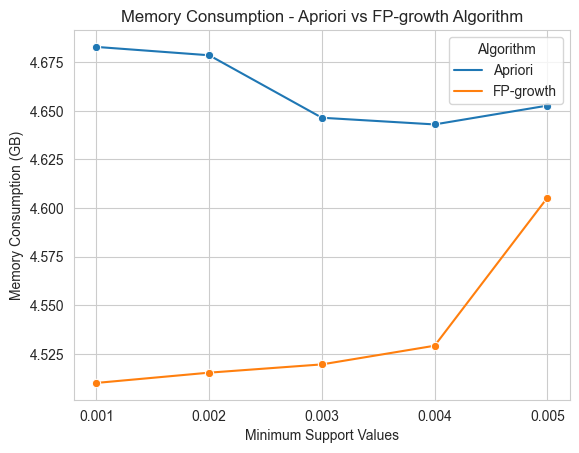

In [30]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
saturday_fpgrowth_extracted_rules, saturday_fpgrowth_execution_times, saturday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Saturday'], algorithm=fpgrowth)

# Access the association rules variables
saturday_fpgrowth_rules_1 = saturday_fpgrowth_extracted_rules[0]
saturday_fpgrowth_rules_2 = saturday_fpgrowth_extracted_rules[1]
saturday_fpgrowth_rules_3 = saturday_fpgrowth_extracted_rules[2]
saturday_fpgrowth_rules_4 = saturday_fpgrowth_extracted_rules[3]
saturday_fpgrowth_rules_5 = saturday_fpgrowth_extracted_rules[4]

# Call the function to extract association rules and measure execution times
saturday_apriori_extracted_rules, saturday_apriori_execution_times, saturday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Saturday'], algorithm=apriori)

# Access the association rules variables
saturday_apriori_rules_1 = saturday_apriori_extracted_rules[0]
saturday_apriori_rules_2 = saturday_apriori_extracted_rules[1]
saturday_apriori_rules_3 = saturday_apriori_extracted_rules[2]
saturday_apriori_rules_4 = saturday_apriori_extracted_rules[3]
saturday_apriori_rules_5 = saturday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=saturday_apriori_execution_times,
                           fpgrowth_values=saturday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=saturday_apriori_memory_consumed,
                           fpgrowth_values=saturday_fpgrowth_memory_consumed, memory_consumption=True)

In [113]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Day'] == 'Saturday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Saturday'])
len(x)
average_list_length(x)

len(saturday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(saturday_apriori_rules_1.sort_values('support', ascending=False))

len(saturday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(saturday_apriori_rules_2.sort_values('support', ascending=False))

len(saturday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(saturday_apriori_rules_3.sort_values('support', ascending=False))

len(saturday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(saturday_apriori_rules_4.sort_values('support', ascending=False))

len(saturday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(saturday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(saturday_apriori_execution_times)
sum(saturday_fpgrowth_execution_times)

mean(saturday_apriori_memory_consumed)
mean(saturday_fpgrowth_memory_consumed)

similar_association_rules(saturday_apriori_rules_3, saturday_fpgrowth_rules_3, 'apriori', 'fp-growth').head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 123264 entries, 4 to 769067
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    123264 non-null  object        
 1   Transaction Date  123264 non-null  datetime64[ns]
 2   Sale Year         123264 non-null  int32         
 3   Sale Month        123264 non-null  object        
 4   Sale Day          123264 non-null  object        
 5   Sale Day Type     123264 non-null  object        
 6   Item Code         123264 non-null  int64         
 7   Item Name         123264 non-null  object        
 8   Major Category    123264 non-null  object        
 9   Units             123264 non-null  int64         
 10  Sold Qty          123264 non-null  float64       
 11  Purchase Price    123264 non-null  float64       
 12  Item Rate         123264 non-null  float64       
 13  Item Profit (%)   123264 non-null  float64       
 14  Sale Prof

37654

3.2735964306580976

448

448

136

136

76

76

32

32

14

14

44.47244191169739

44.51116871833801

4.6607261696

4.5359087616

Association_Rule   
0  ['FANTASIA SPECIA BREAD 900G/LUX BREAD'] => ['FAMILY WHITE BREAD 950G']  \
1                      ['COKE (PET) 35CL'] => ['FANTA  ORANGE (PET) 35CL']   
2          ['THREE CROWN POWDER MILK 380G'] => ['FAMILY WHITE BREAD 950G']   
3                                      ['CHICKEN SUYA'] => ['JOLLOF RICE']   
4                           ['COKE ORIGINAL (PET)  60CL'] => ['PUFF PUFF']   
5          ['FAMILY WHITE BREAD 950G'] => ['THREE CROWN POWDER MILK 380G']   
6    ['PEAK EVAPORATED MILK 157ML / 160ML'] => ['FAMILY WHITE BREAD 950G']   
7                                           ['JOLLOF RICE'] => ['MOI-MOI']   
8                      ['FANTA  ORANGE (PET) 35CL'] => ['COKE (PET) 35CL']   
9                           ['JOLLOF RICE'] => ['NESTLE H2O (SMALL) 60CL']   

   Lift_apriori  Lift_fp-growth  
0        1.9046          1.9046  
1       16.6372         16.6372  
2        2.7256          2.7256  
3       10.0376         10.0376  
4        1.7067          1.7067  
5        2.7256          2.7256  
6        3.1423          3.1423  
7        5.6205          5.6205  
8       16.6372         16.6372  
9        1.5324          1.5324

### Sunday

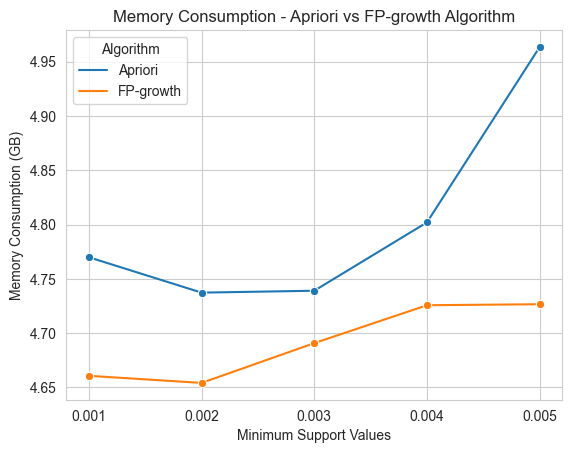

In [33]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
sunday_fpgrowth_extracted_rules, sunday_fpgrowth_execution_times, sunday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Sunday'], algorithm=fpgrowth)

# Access the association rules variables
sunday_fpgrowth_rules_1 = sunday_fpgrowth_extracted_rules[0]
sunday_fpgrowth_rules_2 = sunday_fpgrowth_extracted_rules[1]
sunday_fpgrowth_rules_3 = sunday_fpgrowth_extracted_rules[2]
sunday_fpgrowth_rules_4 = sunday_fpgrowth_extracted_rules[3]
sunday_fpgrowth_rules_5 = sunday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
sunday_apriori_extracted_rules, sunday_apriori_execution_times, sunday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Sunday'], algorithm=apriori)

# Access the association rules variables
sunday_apriori_rules_1 = sunday_apriori_extracted_rules[0]
sunday_apriori_rules_2 = sunday_apriori_extracted_rules[1]
sunday_apriori_rules_3 = sunday_apriori_extracted_rules[2]
sunday_apriori_rules_4 = sunday_apriori_extracted_rules[3]
sunday_apriori_rules_5 = sunday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=sunday_apriori_execution_times,
                           fpgrowth_values=sunday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=sunday_apriori_memory_consumed,
                           fpgrowth_values=sunday_fpgrowth_memory_consumed, memory_consumption=True)

In [117]:
differential_sales_data[differential_sales_data['Sale Day'] == 'Sunday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Sunday'])
len(x)
average_list_length(x)

len(sunday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(sunday_apriori_rules_1.sort_values('support', ascending=False))

len(sunday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(sunday_apriori_rules_2.sort_values('support', ascending=False))

len(sunday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(sunday_apriori_rules_3.sort_values('support', ascending=False))

len(sunday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(sunday_apriori_rules_4.sort_values('support', ascending=False))

len(sunday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(sunday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(sunday_apriori_execution_times)
sum(sunday_fpgrowth_execution_times)

mean(sunday_apriori_memory_consumed)
mean(sunday_fpgrowth_memory_consumed)

similar_association_rules(sunday_apriori_rules_2, sunday_fpgrowth_rules_2, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 114949 entries, 9 to 769069
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    114949 non-null  object        
 1   Transaction Date  114949 non-null  datetime64[ns]
 2   Sale Year         114949 non-null  int32         
 3   Sale Month        114949 non-null  object        
 4   Sale Day          114949 non-null  object        
 5   Sale Day Type     114949 non-null  object        
 6   Item Code         114949 non-null  int64         
 7   Item Name         114949 non-null  object        
 8   Major Category    114949 non-null  object        
 9   Units             114949 non-null  int64         
 10  Sold Qty          114949 non-null  float64       
 11  Purchase Price    114949 non-null  float64       
 12  Item Rate         114949 non-null  float64       
 13  Item Profit (%)   114949 non-null  float64       
 14  Sale Prof

35790

3.211763062307907

494

494

150

150

78

78

44

44

18

18

42.870139360427856

42.23712992668152

4.8023314432

4.6915477504

Association_Rule   
125                                      ['MEAT PIE'] => ['FRIED CHICKEN']  \
108                           ['FANTA ORANGE (PET) 60CL'] => ['PUFF PUFF']   
63                    ['FANTA ORANGE (PET) 60CL'] => ['SPRITE (PET) 60CL']   
137  ['FAMILY WHITE BREAD 950G'] => ['PEAK EVAPORATED MILK 157ML / 160ML']   
12                                             ['MEAT PIE'] => ['HOT DOG']   
111                           ['CHOPPED FRIED PLANTAIN'] => ['FRIED RICE']   
135                    ['FAMILY WHITE BREAD 950G'] => ['FRUIT BREAD 550g']   
136                                            ['JOLLOF RICE'] => ['ASUN']   
93                                         ['PUFF PUFF'] => ['FRIED RICE']   
142                                    ['CHICKEN PIE'] => ['SAUSAGE ROLL']   

     Lift_apriori  Lift_fp-growth  
125        1.9234          1.9234  
108        2.1701          2.1701  
63        10.2349         10.2349  
137        2.7646          2.7646  
12         6.2414          6.2414  
111        9.7962          9.7962  
135        1.6110          1.6110  
136       10.1632         10.1632  
93         1.6173          1.6173  
142        7.1819          7.1819

### Friday

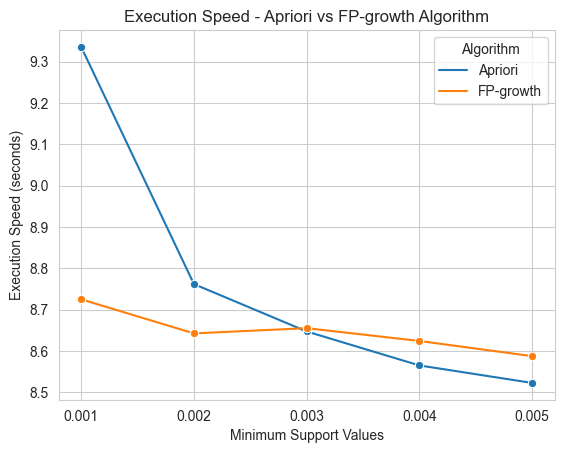

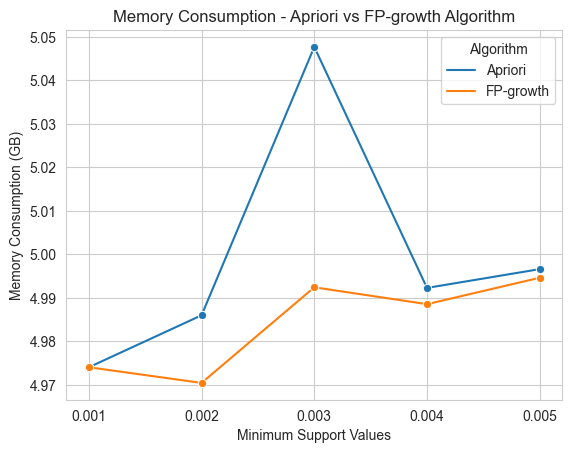

In [34]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
friday_fpgrowth_extracted_rules, friday_fpgrowth_execution_times, friday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Friday'], algorithm=fpgrowth)

# Access the association rules variables
friday_fpgrowth_rules_1 = friday_fpgrowth_extracted_rules[0]
friday_fpgrowth_rules_2 = friday_fpgrowth_extracted_rules[1]
friday_fpgrowth_rules_3 = friday_fpgrowth_extracted_rules[2]
friday_fpgrowth_rules_4 = friday_fpgrowth_extracted_rules[3]
friday_fpgrowth_rules_5 = friday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
friday_apriori_extracted_rules, friday_apriori_execution_times, friday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Friday'], algorithm=apriori)

# Access the association rules variables
friday_apriori_rules_1 = friday_apriori_extracted_rules[0]
friday_apriori_rules_2 = friday_apriori_extracted_rules[1]
friday_apriori_rules_3 = friday_apriori_extracted_rules[2]
friday_apriori_rules_4 = friday_apriori_extracted_rules[3]
friday_apriori_rules_5 = friday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=friday_apriori_execution_times,
                           fpgrowth_values=friday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=friday_apriori_memory_consumed,
                           fpgrowth_values=friday_fpgrowth_memory_consumed, memory_consumption=True)


In [119]:
differential_sales_data[differential_sales_data['Sale Day'] == 'Friday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Friday'])
len(x)
average_list_length(x)

len(friday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(friday_apriori_rules_1.sort_values('support', ascending=False))

len(friday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(friday_apriori_rules_2.sort_values('support', ascending=False))

len(friday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(friday_apriori_rules_3.sort_values('support', ascending=False))

len(friday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(friday_apriori_rules_4.sort_values('support', ascending=False))

len(friday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(friday_apriori_rules_5.sort_values('support', ascending=False))


sum(friday_apriori_execution_times)
sum(friday_fpgrowth_execution_times)

mean(friday_apriori_memory_consumed)
mean(friday_fpgrowth_memory_consumed)

similar_association_rules(friday_apriori_rules_1, friday_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 113040 entries, 2 to 769063
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    113040 non-null  object        
 1   Transaction Date  113040 non-null  datetime64[ns]
 2   Sale Year         113040 non-null  int32         
 3   Sale Month        113040 non-null  object        
 4   Sale Day          113040 non-null  object        
 5   Sale Day Type     113040 non-null  object        
 6   Item Code         113040 non-null  int64         
 7   Item Name         113040 non-null  object        
 8   Major Category    113040 non-null  object        
 9   Units             113040 non-null  int64         
 10  Sold Qty          113040 non-null  float64       
 11  Purchase Price    113040 non-null  float64       
 12  Item Rate         113040 non-null  float64       
 13  Item Profit (%)   113040 non-null  float64       
 14  Sale Prof

37127

3.0446844614431545

366

366

134

134

68

68

36

36

14

14

43.83289170265198

43.23491358757019

4.9993392128

4.984037376

Association_Rule   
312                      ['CHICKEN PIE'] => ['PUFF PUFF', 'MEAT PIE']  \
28    ['FAMILY WHITE BREAD 950G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
320         ['CHOPPED FRIED PLANTAIN'] => ['NESTLE H2O (SMALL) 60CL']   
201                      ['CHICKEN PIE', 'MEAT PIE'] => ['PUFF PUFF']   
21                                ['PLAIN DOUGHNUT'] => ['PUFF PUFF']   
60                                     ['PUFF PUFF'] => ['EGG SAUCE']   
23                       ['CHOPPED FRIED PLANTAIN'] => ['TITUS FISH']   
26                                   ['TITUS FISH'] => ['FRIED RICE']   
29   ['FAMILY WHITE BREAD 950G'] => ['GOLDEN PENNY SUGAR CUBES 500g']   
169                                ['PLAIN DOUGHNUT'] => ['MEAT PIE']   

     Lift_apriori  Lift_fp-growth  
312        6.2413          6.2413  
28         3.2655          3.2655  
320        2.1257          2.1257  
201        1.6406          1.6406  
21         1.6230          1.6230  
60         1.9472          1.9472  
23         8.9677          8.9677  
26        11.4249         11.4249  
29         2.7853          2.7853  
169        5.2582          5.2582

### Wednesday

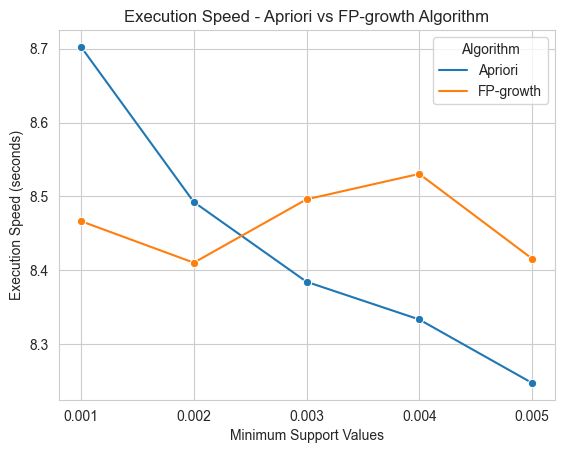

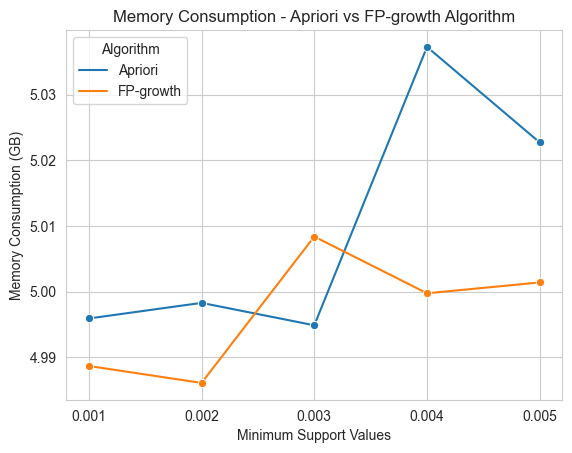

In [35]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
wednesday_fpgrowth_extracted_rules, wednesday_fpgrowth_execution_times, wednesday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Wednesday'], algorithm=fpgrowth)

# Access the association rules variables
wednesday_fpgrowth_rules_1 = wednesday_fpgrowth_extracted_rules[0]
wednesday_fpgrowth_rules_2 = wednesday_fpgrowth_extracted_rules[1]
wednesday_fpgrowth_rules_3 = wednesday_fpgrowth_extracted_rules[2]
wednesday_fpgrowth_rules_4 = wednesday_fpgrowth_extracted_rules[3]
wednesday_fpgrowth_rules_5 = wednesday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
wednesday_apriori_extracted_rules, wednesday_apriori_execution_times, wednesday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Wednesday'], algorithm=apriori)

# Access the association rules variables
wednesday_apriori_rules_1 = wednesday_apriori_extracted_rules[0]
wednesday_apriori_rules_2 = wednesday_apriori_extracted_rules[1]
wednesday_apriori_rules_3 = wednesday_apriori_extracted_rules[2]
wednesday_apriori_rules_4 = wednesday_apriori_extracted_rules[3]
wednesday_apriori_rules_5 = wednesday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=wednesday_apriori_execution_times,
                           fpgrowth_values=wednesday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=wednesday_apriori_memory_consumed,
                           fpgrowth_values=wednesday_fpgrowth_memory_consumed, memory_consumption=True)

In [120]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Day'] == 'Wednesday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Wednesday'])
len(x)
average_list_length(x)

len(wednesday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(wednesday_apriori_rules_1.sort_values('support', ascending=False))

len(wednesday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(wednesday_apriori_rules_2.sort_values('support', ascending=False))

len(wednesday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(wednesday_apriori_rules_3.sort_values('support', ascending=False))

len(wednesday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(wednesday_apriori_rules_4.sort_values('support', ascending=False))

len(wednesday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(wednesday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(wednesday_apriori_execution_times)
sum(wednesday_fpgrowth_execution_times)

mean(wednesday_apriori_memory_consumed)
mean(wednesday_fpgrowth_memory_consumed)

similar_association_rules(wednesday_apriori_rules_1, wednesday_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 107748 entries, 0 to 769073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    107748 non-null  object        
 1   Transaction Date  107748 non-null  datetime64[ns]
 2   Sale Year         107748 non-null  int32         
 3   Sale Month        107748 non-null  object        
 4   Sale Day          107748 non-null  object        
 5   Sale Day Type     107748 non-null  object        
 6   Item Code         107748 non-null  int64         
 7   Item Name         107748 non-null  object        
 8   Major Category    107748 non-null  object        
 9   Units             107748 non-null  int64         
 10  Sold Qty          107748 non-null  float64       
 11  Purchase Price    107748 non-null  float64       
 12  Item Rate         107748 non-null  float64       
 13  Item Profit (%)   107748 non-null  float64       
 14  Sale Prof

36152

2.980416021243638

356

356

126

126

60

60

32

32

10

10

42.160770654678345

42.3195526599884

5.0098061312

4.996857856

Association_Rule  Lift_apriori   
83                            ['OFADA SAUCE'] => ['PUFF PUFF']        1.8254  \
315              ['FANTA  ORANGE (PET) 35CL'] => ['PUFF PUFF']        1.8234   
270                       ['JOLLOF RICE'] => ['POTTAGE BEANS']        4.0209   
86                             ['BOILED YAM'] => ['EGG SAUCE']      112.0586   
292                           ['CROISSANT'] => ['CHICKEN PIE']        5.9779   
38                          ['OFADA SAUCE'] => ['JOLLOF RICE']        3.7685   
318  ['NESTLE H2O (SMALL) 60CL'] => ['CHOPPED FRIED PLANTAIN']        1.6897   
148                     ['FRIED CROAKER FISH'] => ['MEAT PIE']        1.8306   
69         ['FAMILY WHITE BREAD 950G'] => ['FRUIT BREAD 550g']        1.7458   
228                    ['PEPSI MAX 40CL PET'] => ['PUFF PUFF']        2.0498   

     Lift_fp-growth  
83           1.8254  
315          1.8234  
270          4.0209  
86         112.0586  
292          5.9779  
38           3.7685  
318          1.6897  
148          1.8306  
69           1.7458  
228          2.0498

### Thursday

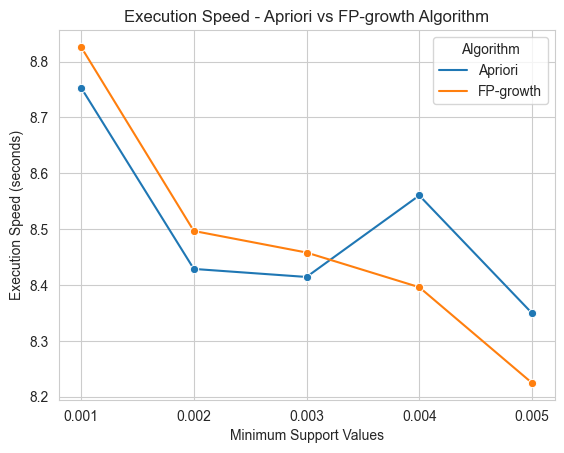

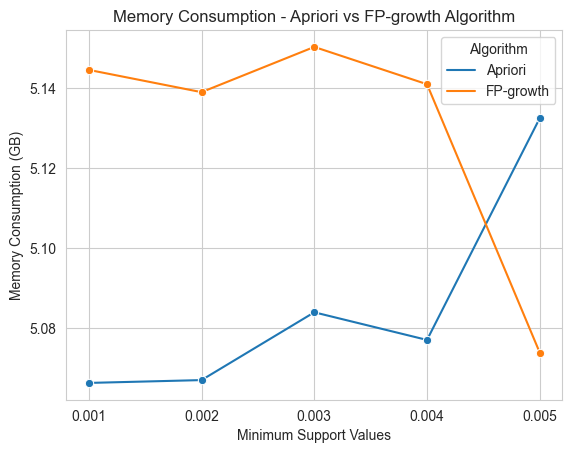

In [36]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
thursday_fpgrowth_extracted_rules, thursday_fpgrowth_execution_times, thursday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Thursday'], algorithm=fpgrowth)

# Access the association rules variables
thursday_fpgrowth_rules_1 = thursday_fpgrowth_extracted_rules[0]
thursday_fpgrowth_rules_2 = thursday_fpgrowth_extracted_rules[1]
thursday_fpgrowth_rules_3 = thursday_fpgrowth_extracted_rules[2]
thursday_fpgrowth_rules_4 = thursday_fpgrowth_extracted_rules[3]
thursday_fpgrowth_rules_5 = thursday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
thursday_apriori_extracted_rules, thursday_apriori_execution_times, thursday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Thursday'], algorithm=apriori)

# Access the association rules variables
thursday_apriori_rules_1 = thursday_apriori_extracted_rules[0]
thursday_apriori_rules_2 = thursday_apriori_extracted_rules[1]
thursday_apriori_rules_3 = thursday_apriori_extracted_rules[2]
thursday_apriori_rules_4 = thursday_apriori_extracted_rules[3]
thursday_apriori_rules_5 = thursday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=thursday_apriori_execution_times,
                           fpgrowth_values=thursday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=thursday_apriori_memory_consumed,
                           fpgrowth_values=thursday_fpgrowth_memory_consumed, memory_consumption=True)

In [121]:
differential_sales_data[differential_sales_data['Sale Day'] == 'Thursday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Thursday'])
len(x)
average_list_length(x)

len(thursday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(thursday_apriori_rules_1.sort_values('support', ascending=False))

len(thursday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(thursday_apriori_rules_2.sort_values('support', ascending=False))

len(thursday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(thursday_apriori_rules_3.sort_values('support', ascending=False))

len(thursday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(thursday_apriori_rules_4.sort_values('support', ascending=False))

len(thursday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(thursday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(thursday_apriori_execution_times)
sum(thursday_fpgrowth_execution_times)

mean(thursday_apriori_memory_consumed)
mean(thursday_fpgrowth_memory_consumed)

similar_association_rules(thursday_apriori_rules_1, thursday_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 108111 entries, 20 to 769062
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    108111 non-null  object        
 1   Transaction Date  108111 non-null  datetime64[ns]
 2   Sale Year         108111 non-null  int32         
 3   Sale Month        108111 non-null  object        
 4   Sale Day          108111 non-null  object        
 5   Sale Day Type     108111 non-null  object        
 6   Item Code         108111 non-null  int64         
 7   Item Name         108111 non-null  object        
 8   Major Category    108111 non-null  object        
 9   Units             108111 non-null  int64         
 10  Sold Qty          108111 non-null  float64       
 11  Purchase Price    108111 non-null  float64       
 12  Item Rate         108111 non-null  float64       
 13  Item Profit (%)   108111 non-null  float64       
 14  Sale Pro

36137

2.9916982594017214

366

366

124

124

68

68

36

36

14

14

42.50612497329712

42.401463985443115

5.0853019648

5.1297427456

Association_Rule   
209                                                               ['PLAIN DOUGHNUT'] => ['HOT DOG']  \
89                                           ['MILO SACHET BIG 1KG'] => ['FAMILY WHITE BREAD 950G']   
318                                    ['DANGOTE SALT REFINE  500g'] => ['FAMILY WHITE BREAD 950G']   
243  ['FAMILY WHITE BREAD 950G'] => ['PEAK MILK POWDER SACHET 16G', 'MILO 20g (ENERGY FOOD DRINK)']   
244                                  ['GOLDEN PENNY SPAGHETTI 500g'] => ['FAMILY WHITE BREAD 950G']   
133                                                                   ['FRIED RICE'] => ['MOI-MOI']   
360  ['PEAK MILK POWDER SACHET 16G', 'FAMILY WHITE BREAD 950G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
27                                 ['FAMILY WHITE BREAD 950G'] => ['GOLDEN PENNY SUGAR CUBES 500g']   
30                                                                   ['HOT DOG'] => ['CHICKEN PIE']   
114                                                  ['COKE ORIGINAL (PET)  60CL'] => ['PUFF PUFF']   

     Lift_apriori  Lift_fp-growth  
209        7.5730          7.5730  
89         3.1482          3.1482  
318        2.2970          2.2970  
243        4.5882          4.5882  
244        1.9814          1.9814  
133        4.4657          4.4657  
360       54.8602         54.8602  
27         3.0055          3.0055  
30         5.8848          5.8848  
114        1.8286          1.8286

### Tuesday

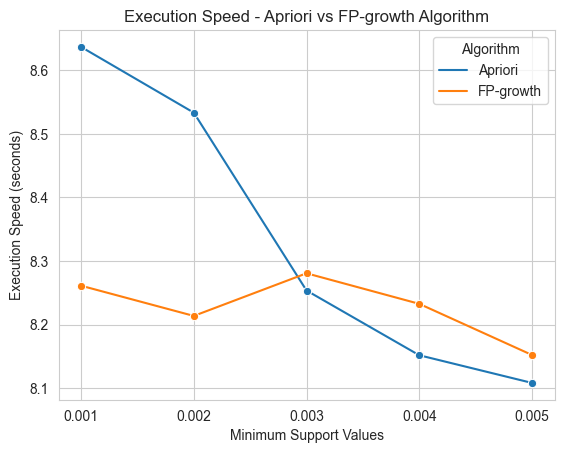

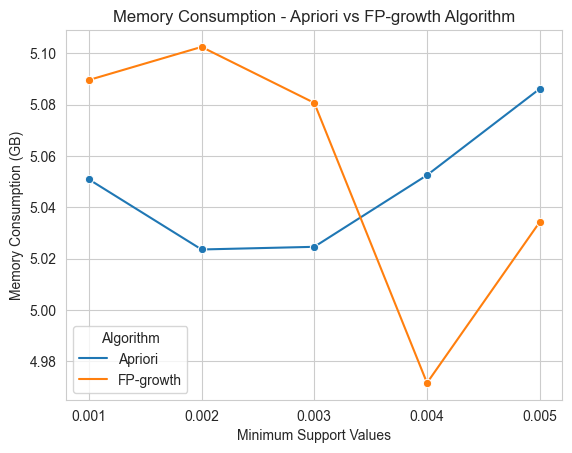

In [37]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
tuesday_fpgrowth_extracted_rules, tuesday_fpgrowth_execution_times, tuesday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Tuesday'], algorithm=fpgrowth)

# Access the association rules variables
tuesday_fpgrowth_rules_1 = tuesday_fpgrowth_extracted_rules[0]
tuesday_fpgrowth_rules_2 = tuesday_fpgrowth_extracted_rules[1]
tuesday_fpgrowth_rules_3 = tuesday_fpgrowth_extracted_rules[2]
tuesday_fpgrowth_rules_4 = tuesday_fpgrowth_extracted_rules[3]
tuesday_fpgrowth_rules_5 = tuesday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
tuesday_apriori_extracted_rules, tuesday_apriori_execution_times, tuesday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Tuesday'], algorithm=apriori)

# Access the association rules variables
tuesday_apriori_rules_1 = tuesday_apriori_extracted_rules[0]
tuesday_apriori_rules_2 = tuesday_apriori_extracted_rules[1]
tuesday_apriori_rules_3 = tuesday_apriori_extracted_rules[2]
tuesday_apriori_rules_4 = tuesday_apriori_extracted_rules[3]
tuesday_apriori_rules_5 = tuesday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=tuesday_apriori_execution_times,
                           fpgrowth_values=tuesday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=tuesday_apriori_memory_consumed,
                           fpgrowth_values=tuesday_fpgrowth_memory_consumed, memory_consumption=True)

In [122]:
differential_sales_data[differential_sales_data['Sale Day'] == 'Tuesday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Tuesday'])
len(x)
average_list_length(x)

len(tuesday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(tuesday_apriori_rules_1.sort_values('support', ascending=False))

len(tuesday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(tuesday_apriori_rules_2.sort_values('support', ascending=False))

len(tuesday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(tuesday_apriori_rules_3.sort_values('support', ascending=False))

len(tuesday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(tuesday_apriori_rules_4.sort_values('support', ascending=False))

len(tuesday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(tuesday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(tuesday_apriori_execution_times)
sum(tuesday_fpgrowth_execution_times)

mean(tuesday_apriori_memory_consumed)
mean(tuesday_fpgrowth_memory_consumed)

similar_association_rules(tuesday_apriori_rules_1, tuesday_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 102930 entries, 1 to 769071
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    102930 non-null  object        
 1   Transaction Date  102930 non-null  datetime64[ns]
 2   Sale Year         102930 non-null  int32         
 3   Sale Month        102930 non-null  object        
 4   Sale Day          102930 non-null  object        
 5   Sale Day Type     102930 non-null  object        
 6   Item Code         102930 non-null  int64         
 7   Item Name         102930 non-null  object        
 8   Major Category    102930 non-null  object        
 9   Units             102930 non-null  int64         
 10  Sold Qty          102930 non-null  float64       
 11  Purchase Price    102930 non-null  float64       
 12  Item Rate         102930 non-null  float64       
 13  Item Profit (%)   102930 non-null  float64       
 14  Sale Prof

35422

2.905821241036644

362

362

130

130

64

64

36

36

12

12

41.6839439868927

41.14069867134094

5.0475278336

5.0556944384

Association_Rule   
57                       ['FAMILY WHITE BREAD 950G'] => ['BREAKFAST ROLLS']  \
86                                    ['CHICKEN PIE'] => ['PLAIN DOUGHNUT']   
75                                           ['CHICKEN PIE'] => ['HOT DOG']   
241                           ['MEAT PIE'] => ['COKE ORIGINAL (PET)  60CL']   
302                            ['CHICKEN PIE'] => ['PUFF PUFF', 'MEAT PIE']   
74    ['FAMILY WHITE BREAD 950G'] => ['PEAK EVAPORATED MILK 157ML / 160ML']   
140                   ['TITUS SARDINE 125G'] => ['FAMILY WHITE BREAD 950G']   
222                   ['JOLLOF RICE'] => ['SWAN NATURAL SPRING WATER 75CL']   
281                          ['PUFF PUFF'] => ['COKE ORIGINAL (PET)  60CL']   
338  ['PEAK CHOCOLATE MILK POWDER 3IN1 14G'] => ['FAMILY WHITE BREAD 950G']   

     Lift_apriori  Lift_fp-growth  
57         3.5232          3.5232  
86         4.6002          4.6002  
75         5.2459          5.2459  
241        2.0236          2.0236  
302        6.2876          6.2876  
74         3.0911          3.0911  
140        2.9748          2.9748  
222        2.7870          2.7870  
281        1.8633          1.8633  
338        3.3961          3.3961

### Monday

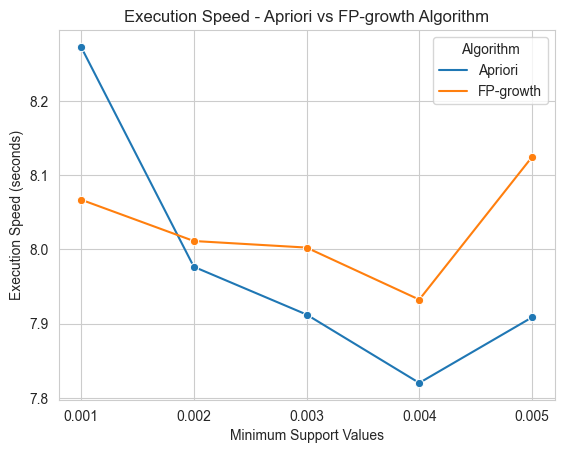

In [38]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
monday_fpgrowth_extracted_rules, monday_fpgrowth_execution_times, monday_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Monday'], algorithm=fpgrowth)

# Access the association rules variables
monday_fpgrowth_rules_1 = monday_fpgrowth_extracted_rules[0]
monday_fpgrowth_rules_2 = monday_fpgrowth_extracted_rules[1]
monday_fpgrowth_rules_3 = monday_fpgrowth_extracted_rules[2]
monday_fpgrowth_rules_4 = monday_fpgrowth_extracted_rules[3]
monday_fpgrowth_rules_5 = monday_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
monday_apriori_extracted_rules, monday_apriori_execution_times, monday_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, day=['Monday'], algorithm=apriori)

# Access the association rules variables
monday_apriori_rules_1 = monday_apriori_extracted_rules[0]
monday_apriori_rules_2 = monday_apriori_extracted_rules[1]
monday_apriori_rules_3 = monday_apriori_extracted_rules[2]
monday_apriori_rules_4 = monday_apriori_extracted_rules[3]
monday_apriori_rules_5 = monday_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=monday_apriori_execution_times,
                           fpgrowth_values=monday_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=monday_apriori_memory_consumed,
                           fpgrowth_values=monday_fpgrowth_memory_consumed, memory_consumption=True)


In [123]:
differential_sales_data[differential_sales_data['Sale Day'] == 'Monday'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Day'] == 'Monday'])
len(x)
average_list_length(x)

len(monday_fpgrowth_rules_1.sort_values('support', ascending=False))
len(monday_apriori_rules_1.sort_values('support', ascending=False))

len(monday_fpgrowth_rules_2.sort_values('support', ascending=False))
len(monday_apriori_rules_2.sort_values('support', ascending=False))

len(monday_fpgrowth_rules_3.sort_values('support', ascending=False))
len(monday_apriori_rules_3.sort_values('support', ascending=False))

len(monday_fpgrowth_rules_4.sort_values('support', ascending=False))
len(monday_apriori_rules_4.sort_values('support', ascending=False))

len(monday_fpgrowth_rules_5.sort_values('support', ascending=False))
len(monday_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(monday_apriori_execution_times)
sum(monday_fpgrowth_execution_times)

mean(monday_apriori_memory_consumed)
mean(monday_fpgrowth_memory_consumed)

similar_association_rules(monday_apriori_rules_1, monday_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 99032 entries, 10 to 769058
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    99032 non-null  object        
 1   Transaction Date  99032 non-null  datetime64[ns]
 2   Sale Year         99032 non-null  int32         
 3   Sale Month        99032 non-null  object        
 4   Sale Day          99032 non-null  object        
 5   Sale Day Type     99032 non-null  object        
 6   Item Code         99032 non-null  int64         
 7   Item Name         99032 non-null  object        
 8   Major Category    99032 non-null  object        
 9   Units             99032 non-null  int64         
 10  Sold Qty          99032 non-null  float64       
 11  Purchase Price    99032 non-null  float64       
 12  Item Rate         99032 non-null  float64       
 13  Item Profit (%)   99032 non-null  float64       
 14  Sale Profit       99032 n

34265

2.8901794834379104

340

340

128

128

66

66

32

32

12

12

39.890259981155396

40.13746976852417

5.175717888

5.1648503808

Association_Rule   
291                             ['CHICKEN PIE'] => ['PUFF PUFF', 'MEAT PIE']  \
118  ['FAMILY WHITE BREAD 950G'] => ['FANTASIA SPECIA BREAD 900G/LUX BREAD']   
5                              ['COKE ORIGINAL (PET)  60CL'] => ['MEAT PIE']   
230                       ['COKE (PET) 35CL'] => ['NESTLE H2O (SMALL) 60CL']   
12                                              ['MOI-MOI'] => ['PUFF PUFF']   
127       ['FAMILY WHITE BREAD 950G'] => ['CADBURY HOT CHOCOLATE DRINK 30g']   
155                                  ['PUFF PUFF'] => ['PEPSI MAX 40CL PET']   
259                          ['NESTLE H2O (SMALL) 60CL'] => ['CHICKEN STEW']   
10       ['PEAK MILK POWDER SACHET 16G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
71                    ['FAMILY WHITE BREAD 950G'] => ['MILO SACHET BIG 1KG']   

     Lift_apriori  Lift_fp-growth  
291        4.7882          4.7882  
118        2.1314          2.1314  
5          1.9189          1.9189  
230        1.5658          1.5658  
12         2.7579          2.7579  
127        2.8991          2.8991  
155        1.9606          1.9606  
259        1.9051          1.9051  
10        41.5614         41.5614  
71         3.6989          3.6989

## COMPARING DAYS WITH TRADITIONAL APPROACH

### RULES

In [322]:
day_names=['alldata', 'sunday', 'monday','tuesday', 'wednesday','thursday','friday', 'saturday' ]
rules_list = [alldata_fpgrowth_rules_1, sunday_fpgrowth_rules_1, monday_fpgrowth_rules_1, tuesday_fpgrowth_rules_1, wednesday_fpgrowth_rules_1,thursday_fpgrowth_rules_1,friday_fpgrowth_rules_1,saturday_fpgrowth_rules_1,]

In [323]:
def compare1_association_rules(df_list, lift_column_names):
    # Extract the rules from the antecedent and consequent columns for each dataframe
    rules_dfs = [set(zip(df['antecedents'], df['consequents'])) for df in df_list]

    # Find the common rules among all dataframes
    common_rules = set.intersection(*rules_dfs)

    # Create a list to store the results
    result_list = []

    # Iterate over the common rules and extract the lift scores from each dataframe
    for rule in common_rules:
        antecedent, consequent = rule
        lift_scores = {}

        # Get the lift scores for each dataframe
        for i, df in enumerate(df_list):
            lift_score = df.loc[(df['antecedents'] == antecedent) & (df['consequents'] == consequent), 'lift'].values[0]
            lift_scores[lift_column_names[i]] = lift_score

        # Add the rule and lift scores to the result list
        result_list.append({'Association_Rule': f"{list(antecedent)} => {list(consequent)}", **lift_scores})

    # Create the resulting dataframe from the list of dictionaries
    result_df = pd.DataFrame(result_list)

    return result_df


In [464]:
compare1_association_rules(df_list=rules_list, lift_column_names=day_names).head(10) #.style.apply(highlight_max, axis=1)

Association_Rule  alldata  sunday   
0  ['COKE ORIGINAL (CAN) 33CL'] => ['FANTA ORANGE CAN 33CL']  71.7845 58.7792  \
1                          ['JOLLOF RICE'] => ['WHITE RICE']   2.2922  2.0223   
2                      ['CHICKEN PIE'] => ['PLAIN DOUGHNUT']   5.8660  5.4594   
3                        ['CHICKEN SUYA'] => ['JOLLOF RICE']   9.2565  9.5691   
4                     ['PLAIN DOUGHNUT'] => ['SAUSAGE ROLL']   9.2297  9.9234   
5                          ['HOT DOG'] => ['PLAIN DOUGHNUT']   8.2734  9.0421   
6       ['SPRITE (PET) 60CL'] => ['FANTA ORANGE (PET) 60CL']  11.0013 10.2349   
7        ['FANTA  ORANGE (PET) 35CL'] => ['COKE (PET) 35CL']  15.8328 15.5457   
8                           ['OFADA SAUCE'] => ['PUFF PUFF']   1.9535  1.9099   
9               ['COKE (PET) 35CL'] => ['SPRITE (PET) 35CL']  17.4122 17.2506   

   monday  tuesday  wednesday  thursday  friday  saturday  
0 81.3632  74.6441    77.6460   77.3349 66.9357   69.3223  
1  2.1236   2.5146     2.4712    2.0197  2.2649    2.5924  
2  6.6973   4.6002     5.7755    6.2917  6.2754    6.1612  
3  8.7688   8.5413     9.0603    9.1621  9.5921   10.0376  
4 10.0223   7.7701     8.5620    8.2638  8.7900   11.6506  
5  9.8303   8.2219     6.8053    7.5730  7.5346    8.9617  
6 10.2491   9.1984    11.2816   11.5652 12.5789   11.7853  
7 15.9075  14.2118    15.8752   15.7036 15.9793   16.6372  
8  1.9077   1.8511     1.8254    2.0460  2.0276    2.1171  
9 16.5439  19.9017    17.2774   16.8549 16.9040   16.9185

In [325]:
def compare2_association_rules(df_list, lift_column_names):
    # Extract the rules from the antecedent and consequent columns for each dataframe
    rules_dfs = [set(zip(df['antecedents'], df['consequents'])) for df in df_list]

    # Create a set to store all rules from all dataframes
    all_rules = set.union(*rules_dfs)

    # Create a list to store the results
    result_list = []

    # Iterate over all rules
    for rule in all_rules:
        antecedent, consequent = rule
        lift_scores = {}

        # Check if the rule is present in each dataframe
        for i, df in enumerate(df_list):
            if rule in rules_dfs[i]:
                lift_score = df.loc[(df['antecedents'] == antecedent) & (df['consequents'] == consequent), 'lift'].values[0]
            else:
                lift_score = None
            lift_scores[lift_column_names[i]] = lift_score

        # Add the rule and lift scores to the result list
        result_list.append({'Association_Rule': f"{list(antecedent)} => {list(consequent)}", **lift_scores})

    # Create the resulting dataframe from the list of dictionaries
    result_df = pd.DataFrame(result_list)

    return result_df


In [467]:
data_anal = compare2_association_rules(df_list=rules_list, lift_column_names=day_names)
filtered_df = data_anal[pd.isna(data_anal['alldata'])]
filtered_df.head(10)

Association_Rule   
5                                        ['TITUS FISH'] => ['NESTLE H2O (SMALL) 60CL']  \
6                       ['JOLLOF RICE', 'CHOPPED FRIED PLANTAIN'] => ['FRIED CHICKEN']   
7   ['FAMILY WHITE BREAD 950G'] => ['ROSE PLUS WHITE TOILET TISSUE BOULOS - IMPROVED']   
8                       ['FRIED CHICKEN'] => ['JOLLOF RICE', 'CHOPPED FRIED PLANTAIN']   
9                                        ['PUFF PUFF', 'SAUSAGE ROLL'] => ['MEAT PIE']   
12                                            ['ASUN'] => ['PUFF PUFF', 'JOLLOF RICE']   
13                                            ['HOT DOG'] => ['PUFF PUFF', 'MEAT PIE']   
14                                                     ['CHICKEN SUYA'] => ['MOI-MOI']   
15                               ['CHICKEN ONION SAUCE'] => ['CHOPPED FRIED PLANTAIN']   
17                                    ['CHICKEN SUYA', 'JOLLOF RICE'] => ['PUFF PUFF']   

    alldata  sunday  monday  tuesday  wednesday  thursday  friday  saturday  
5       NaN  1.9162     NaN      NaN     1.7163       NaN  1.7506    2.1314  
6       NaN 10.0672     NaN      NaN        NaN       NaN     NaN       NaN  
7       NaN     NaN  2.0381      NaN        NaN       NaN     NaN       NaN  
8       NaN 10.0672     NaN      NaN        NaN       NaN     NaN       NaN  
9       NaN  6.1746     NaN      NaN        NaN       NaN     NaN       NaN  
12      NaN 13.2686     NaN      NaN        NaN       NaN     NaN       NaN  
13      NaN  7.1012     NaN      NaN        NaN       NaN     NaN       NaN  
14      NaN     NaN     NaN      NaN        NaN    5.2048     NaN       NaN  
15      NaN  8.8952     NaN      NaN        NaN       NaN     NaN       NaN  
17      NaN     NaN     NaN      NaN        NaN    1.8368  1.9606    2.1408

In [481]:
# CHECKS FOR INSTANCES WHERE A RULE IS PRESENT IN TRADITIONAL APPROACH BUT IN NO OTHER DAY
data_anal = compare2_association_rules(df_list=rules_list, lift_column_names=day_names)
filtered_df = data_anal[~pd.isna(data_anal['alldata'])]
filtered_df

Association_Rule   
0                                                                                 ['PLAIN DOUGHNUT'] => ['SAUSAGE ROLL']  \
1                                               ['FANTA  ORANGE (PET) 35CL'] => ['SPRITE (PET) 35CL', 'COKE (PET) 35CL']   
2                                               ['GOLDEN MORN MAIZE & SOYA PROTEIN 450G'] => ['FAMILY WHITE BREAD 950G']   
3                                                                                       ['CHICKEN SUYA'] => ['MEAT PIE']   
4                                                                          ['MIRINDA ORANGE (PET) 50CL'] => ['MEAT PIE']   
10                                                                         ['COKE ORIGINAL (PET)  60CL'] => ['MEAT PIE']   
11                                                                     ['MIRINDA PINEAPPLE (PET) 50CL'] => ['PUFF PUFF']   
16                                                         ['NESCAFE BREAKFAST 3IN1 32G'] => ['FAMILY WHITE BREAD 950G']   
18                                                                                ['FISH ROLL/ PIE'] => ['SAUSAGE ROLL']   
19                                                                         ['NESTLE H2O (SMALL) 60CL'] => ['FRIED RICE']   
22                                                          ['5 ALIVE PULPY ORANGE  (PET) 40CL / 30CL'] => ['PUFF PUFF']   
23                                                   ['PEAK MILK POWDER SACHET 16G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
24                                                                                  ['JOLLOF RICE'] => ['FRIED CHICKEN']   
25                                                                                          ['MOI-MOI'] => ['PUFF PUFF']   
26                                                             ['FAMILY WHITE BREAD 950G'] => ['MILO SACHET SMALL 200G']   
28                                                                                ['SAUSAGE ROLL'] => ['FISH ROLL/ PIE']   
32                                                                         ['FRIED RICE'] => ['NESTLE H2O (SMALL) 60CL']   
33                                                                                          ['CROISSANT'] => ['RAISINS']   
36                                                                   ['FRUIT BREAD 550g'] => ['FAMILY WHITE BREAD 950G']   
39                                                      ['GOLDEN PENNY SUGAR CUBES 500g'] => ['FAMILY WHITE BREAD 950G']   
40                                                             ['FAMILY WHITE BREAD 950G'] => ['BLUE BAND SPREAD  250G']   
41                                                                                   ['PLAIN DOUGHNUT'] => ['PUFF PUFF']   
43                                                                 ['FANTA  ORANGE (PET) 35CL'] => ['SPRITE (PET) 35CL']   
44                                                                          ['CHOPPED FRIED PLANTAIN'] => ['TITUS FISH']   
45                                              ['SPRITE (PET) 35CL'] => ['COKE (PET) 35CL', 'FANTA  ORANGE (PET) 35CL']   
47                                              ['SPRITE (PET) 35CL', 'FANTA  ORANGE (PET) 35CL'] => ['COKE (PET) 35CL']   
49                                                     ['NESTLE H2O + ZINC (SMALL) 60CL'] => ['NESTLE H2O (SMALL) 60CL']   
50                                                                 ['SPRITE (PET) 35CL'] => ['FANTA  ORANGE (PET) 35CL']   
51                                                   ['THREE CROWN EVAPORATED MILK159ML'] => ['FAMILY WHITE BREAD 950G']   
53                                                                                      ['TITUS FISH'] => ['FRIED RICE']   
55                                                                                  ['FRIED CHICKEN'] => ['JOLLOF RICE']   
57                                                       ['FAMILY WHITE BREAD 950G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
58          

### RUNTIME

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196bbfba430>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Days')

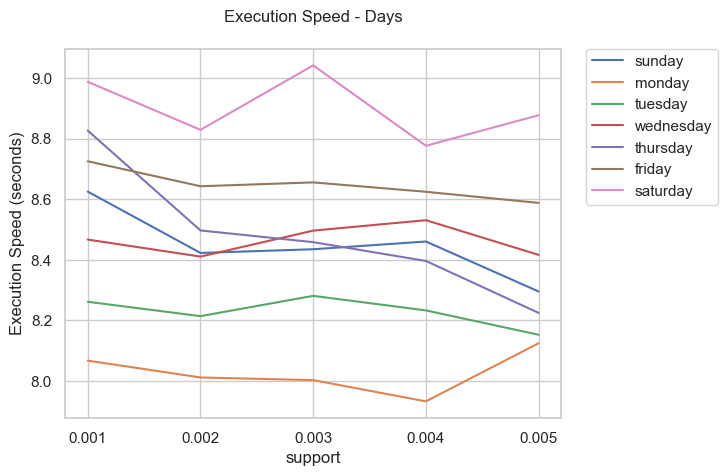

In [470]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

days_execution_speed = pd.DataFrame({'support': minimum_support_values,
                   'sunday': sunday_fpgrowth_execution_times,
                   'monday': monday_fpgrowth_execution_times,
                   'tuesday': tuesday_fpgrowth_execution_times,
                   'wednesday': wednesday_fpgrowth_execution_times,
                   'thursday': thursday_fpgrowth_execution_times,
                   'friday': friday_fpgrowth_execution_times,
                   'saturday': saturday_fpgrowth_execution_times })

sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Days', 
             data=pd.melt(days_execution_speed, ['support'], var_name='Days', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Days', x=0.5, y=1.05)

In [471]:
days_execution_speed

support  sunday  monday  tuesday  wednesday  thursday  friday  saturday
0   0.0010  8.6249  8.0669   8.2612     8.4665    8.8263  8.7251    8.9875
1   0.0020  8.4224  8.0113   8.2137     8.4104    8.4967  8.6426    8.8288
2   0.0030  8.4346  8.0025   8.2808     8.4961    8.4580  8.6553    9.0416
3   0.0040  8.4601  7.9324   8.2327     8.5305    8.3959  8.6243    8.7762
4   0.0050  8.2951  8.1244   8.1523     8.4160    8.2245  8.5876    8.8771

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196ae927e80>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Days vs All Data')

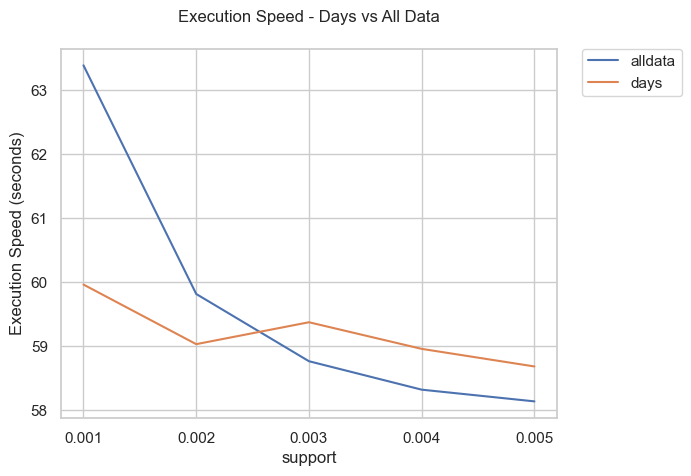

In [370]:
# Use list comprehension and zip to sum up corresponding elements
combined_days_speed = [sum(items) for items in zip(sunday_fpgrowth_execution_times,
                                                  monday_fpgrowth_execution_times,
                                                  tuesday_fpgrowth_execution_times,
                                                  wednesday_fpgrowth_execution_times,
                                                  thursday_fpgrowth_execution_times,
                                                  friday_fpgrowth_execution_times,
                                                  saturday_fpgrowth_execution_times)]


days_vs_alldata_speed = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_execution_times,
                   'days': combined_days_speed})

sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Days', 
             data=pd.melt(days_vs_alldata_speed, ['support'], var_name='Days', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Days vs All Data', x=0.5, y=1.05)



attribute  total_speed
0      days      59.9585
1   alldata      63.3897

<Axes: xlabel='attribute', ylabel='total_speed'>

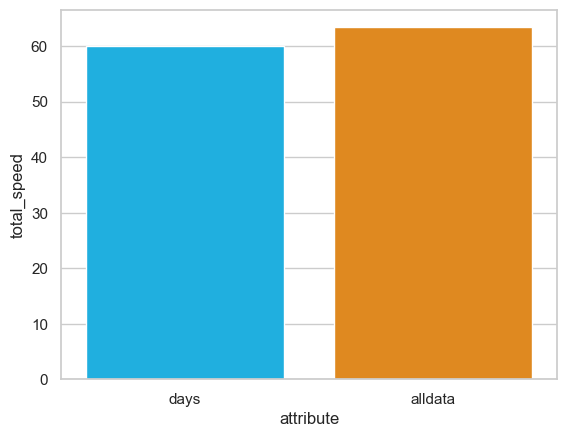

In [368]:
days_vs_alldata_speed_bar = pd.DataFrame({'attribute': ['days', 'alldata'],
                                    'total_speed': [combined_days_speed[0], alldata_apriori_execution_times[0]]})

days_vs_alldata_speed_bar

cols = ['deepskyblue' if (x < days_vs_alldata_speed_bar['total_speed'].max()) 
        else 'darkorange' for x in days_vs_alldata_speed_bar['total_speed']]

sb.barplot(data=days_vs_alldata_speed_bar, x="attribute", y="total_speed", palette=cols)

### MEMORY USAGE

<Axes: xlabel='support', ylabel='Memory Consumption (GB)'>

([<matplotlib.axis.XTick at 0x196a9534cd0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Consumption - Days')

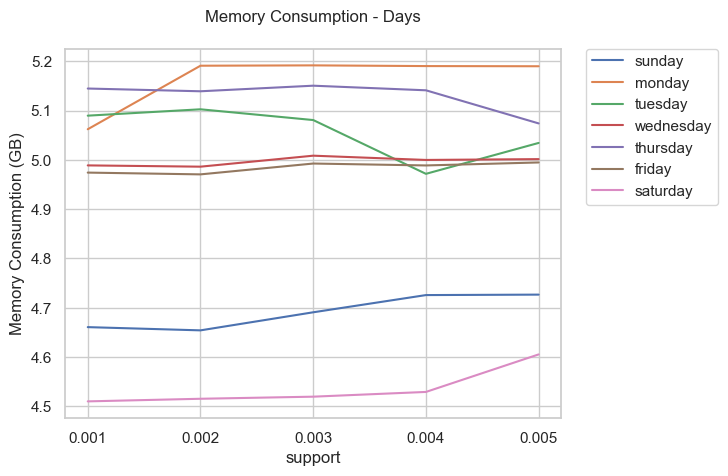

In [313]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

days_memory = pd.DataFrame({'support': minimum_support_values,
                   'sunday': sunday_fpgrowth_memory_consumed,
                   'monday': monday_fpgrowth_memory_consumed,
                   'tuesday': tuesday_fpgrowth_memory_consumed,
                   'wednesday': wednesday_fpgrowth_memory_consumed,
                   'thursday': thursday_fpgrowth_memory_consumed,
                   'friday': friday_fpgrowth_memory_consumed,
                   'saturday': saturday_fpgrowth_memory_consumed })

sb.lineplot(x='support', y='Memory Consumption (GB)', hue='Days', 
             data=pd.melt(days_memory, ['support'], var_name='Days', value_name='Memory Consumption (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Consumption - Days', x=0.5, y=1.05)

<Axes: xlabel='support', ylabel='Memory Consumption (GB)'>

([<matplotlib.axis.XTick at 0x196b14b3f40>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - Days vs All Data')

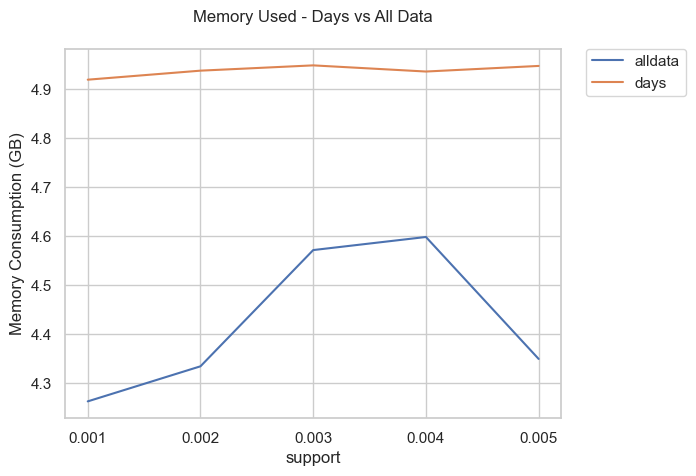

In [372]:
# Use list comprehension and zip to sum up corresponding elements
combined_days_memory = [mean(items) for items in zip(sunday_fpgrowth_memory_consumed,
                                                  monday_fpgrowth_memory_consumed,
                                                  tuesday_fpgrowth_memory_consumed,
                                                  wednesday_fpgrowth_memory_consumed,
                                                  thursday_fpgrowth_memory_consumed,
                                                  friday_fpgrowth_memory_consumed,
                                                  saturday_fpgrowth_memory_consumed)]


days_vs_alldata_memory = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_memory_consumed,
                   'days': combined_days_memory})

sb.lineplot(x='support', y='Memory Consumption (GB)', hue='Days', 
             data=pd.melt(days_vs_alldata_memory, ['support'], var_name='Days', value_name='Memory Consumption (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - Days vs All Data', x=0.5, y=1.05)



In [378]:
days_vs_alldata_memory_bar = pd.DataFrame({'attribute': ['days', 'alldata'],
                                    'average_memory': [combined_days_memory[0], alldata_apriori_memory_consumed[0]]})

days_vs_alldata_memory_bar

cols = ['deepskyblue' if (x < days_vs_alldata_memory_bar['average_memory'].max()) 
        else 'darkorange' for x in days_vs_alldata_memory_bar['average_memory']]

sb.barplot(data=days_vs_alldata_memory_bar, x="attribute", y="average_memory", palette=cols)

attribute  average_memory
0      days          4.9185
1   alldata          4.2631

<Axes: xlabel='attribute', ylabel='average_memory'>

### Mining Association Rules by Months

#### December

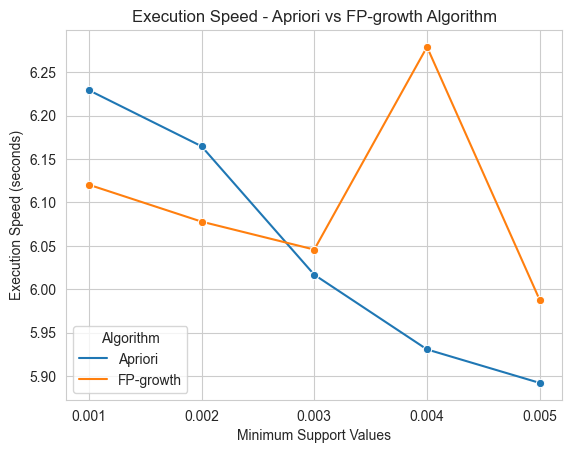

In [39]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
december_fpgrowth_extracted_rules, december_fpgrowth_execution_times, december_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['December'], algorithm=fpgrowth)

# Access the association rules variables
december_fpgrowth_rules_1 = december_fpgrowth_extracted_rules[0]
december_fpgrowth_rules_2 = december_fpgrowth_extracted_rules[1]
december_fpgrowth_rules_3 = december_fpgrowth_extracted_rules[2]
december_fpgrowth_rules_4 = december_fpgrowth_extracted_rules[3]
december_fpgrowth_rules_5 = december_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
december_apriori_extracted_rules, december_apriori_execution_times, december_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['December'], algorithm=apriori)

# Access the association rules variables
december_apriori_rules_1 = december_apriori_extracted_rules[0]
december_apriori_rules_2 = december_apriori_extracted_rules[1]
december_apriori_rules_3 = december_apriori_extracted_rules[2]
december_apriori_rules_4 = december_apriori_extracted_rules[3]
december_apriori_rules_5 = december_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=december_apriori_execution_times,
                           fpgrowth_values=december_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=december_apriori_memory_consumed,
                           fpgrowth_values=december_fpgrowth_memory_consumed, memory_consumption=True)

In [167]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'December'].info()

#x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'December'])
len(x)
average_list_length(x)

len(december_fpgrowth_rules_1.sort_values('support', ascending=False))
len(december_apriori_rules_1.sort_values('support', ascending=False))

len(december_fpgrowth_rules_2.sort_values('support', ascending=False))
len(december_apriori_rules_2.sort_values('support', ascending=False))

len(december_fpgrowth_rules_3.sort_values('support', ascending=False))
len(december_apriori_rules_3.sort_values('support', ascending=False))

len(december_fpgrowth_rules_4.sort_values('support', ascending=False))
len(december_apriori_rules_4.sort_values('support', ascending=False))

len(december_fpgrowth_rules_5.sort_values('support', ascending=False))
len(december_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(december_apriori_execution_times)
sum(december_fpgrowth_execution_times)

mean(december_apriori_memory_consumed)
mean(december_fpgrowth_memory_consumed)

similar_association_rules(december_apriori_rules_1, december_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 77724 entries, 14 to 745923
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    77724 non-null  object        
 1   Transaction Date  77724 non-null  datetime64[ns]
 2   Sale Year         77724 non-null  int32         
 3   Sale Month        77724 non-null  object        
 4   Sale Day          77724 non-null  object        
 5   Sale Day Type     77724 non-null  object        
 6   Item Code         77724 non-null  int64         
 7   Item Name         77724 non-null  object        
 8   Major Category    77724 non-null  object        
 9   Units             77724 non-null  int64         
 10  Sold Qty          77724 non-null  float64       
 11  Purchase Price    77724 non-null  float64       
 12  Item Rate         77724 non-null  float64       
 13  Item Profit (%)   77724 non-null  float64       
 14  Sale Profit       77724 n

26082

2.9799861973775017

506

506

170

170

86

86

46

46

20

20

30.233625650405884

30.51088547706604

5.2248059904

5.1902414848000005

Association_Rule   
418             ['GUINNESS S/STOUT CAN 330ML'] => ['HEINEKEN CAN 33CL']  \
176                                 ['PUFF PUFF'] => ['GOAT MEAT STEW']   
68                                      ['HOT DOG'] => ['SAUSAGE ROLL']   
339                  ['COKE (PET) 35CL'] => ['NESTLE H2O (SMALL) 60CL']   
262  ['SCHWEPPES VIRGIN MOJITO 33CL'] => ['SCHWEPPES CHAPMAN CAN 33CL']   
311                   ['MEAT PIE'] => ['CHICKEN PIE', 'PLAIN DOUGHNUT']   
87                                     ['MEAT PIE'] => ['SAUSAGE ROLL']   
23                ['FANTA  ORANGE (PET) 35CL'] => ['SPRITE (PET) 35CL']   
240                                  ['PUFF PUFF'] => ['FRIED CHICKEN']   
140                                   ['WHITE RICE'] => ['JOLLOF RICE']   

     Lift_apriori  Lift_fp-growth  
418       12.2021         12.2021  
176        1.6095          1.6095  
68        10.1561         10.1561  
339        1.7791          1.7791  
262       57.6773         57.6773  
311        8.7565          8.7565  
87         6.2620          6.2620  
23        16.4908         16.4908  
240        2.0335          2.0335  
140        1.7990          1.7990

#### January

In [40]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
january_fpgrowth_extracted_rules, january_fpgrowth_execution_times, january_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['January'], algorithm=fpgrowth)

# Access the association rules variables
january_fpgrowth_rules_1 = january_fpgrowth_extracted_rules[0]
january_fpgrowth_rules_2 = january_fpgrowth_extracted_rules[1]
january_fpgrowth_rules_3 = january_fpgrowth_extracted_rules[2]
january_fpgrowth_rules_4 = january_fpgrowth_extracted_rules[3]
january_fpgrowth_rules_5 = january_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
january_apriori_extracted_rules, january_apriori_execution_times, january_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['January'], algorithm=apriori)

# Access the association rules variables
january_apriori_rules_1 = january_apriori_extracted_rules[0]
january_apriori_rules_2 = january_apriori_extracted_rules[1]
january_apriori_rules_3 = january_apriori_extracted_rules[2]
january_apriori_rules_4 = january_apriori_extracted_rules[3]
january_apriori_rules_5 = january_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=january_apriori_execution_times,
                           fpgrowth_values=january_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=january_apriori_memory_consumed,
                           fpgrowth_values=january_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(january_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'january', 'alldata')
# difference_association_rules(january_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'january', 'alldata')

In [168]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'January'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'January'])
len(x)
average_list_length(x)

len(january_fpgrowth_rules_1.sort_values('support', ascending=False))
len(january_apriori_rules_1.sort_values('support', ascending=False))

len(january_fpgrowth_rules_2.sort_values('support', ascending=False))
len(january_apriori_rules_2.sort_values('support', ascending=False))

len(january_fpgrowth_rules_3.sort_values('support', ascending=False))
len(january_apriori_rules_3.sort_values('support', ascending=False))

len(january_fpgrowth_rules_4.sort_values('support', ascending=False))
len(january_apriori_rules_4.sort_values('support', ascending=False))

len(january_fpgrowth_rules_5.sort_values('support', ascending=False))
len(january_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(january_apriori_execution_times)
sum(january_fpgrowth_execution_times)

mean(january_apriori_memory_consumed)
mean(january_fpgrowth_memory_consumed)

similar_association_rules(january_apriori_rules_1, january_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 74598 entries, 15 to 759943
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    74598 non-null  object        
 1   Transaction Date  74598 non-null  datetime64[ns]
 2   Sale Year         74598 non-null  int32         
 3   Sale Month        74598 non-null  object        
 4   Sale Day          74598 non-null  object        
 5   Sale Day Type     74598 non-null  object        
 6   Item Code         74598 non-null  int64         
 7   Item Name         74598 non-null  object        
 8   Major Category    74598 non-null  object        
 9   Units             74598 non-null  int64         
 10  Sold Qty          74598 non-null  float64       
 11  Purchase Price    74598 non-null  float64       
 12  Item Rate         74598 non-null  float64       
 13  Item Profit (%)   74598 non-null  float64       
 14  Sale Profit       74598 n

26094

2.858818119107841

404

404

148

148

78

78

42

42

12

12

30.502601385116577

30.37690806388855

5.2900298752

5.2179484672

Association_Rule   
309                                 ['HOT DOG'] => ['PLAIN DOUGHNUT']  \
238                           ['PUFF PUFF'] => ['FRIED CROAKER FISH']   
338                  ['MALTINA CAN 33CL'] => ['DUBIC MALTA CAN 33CL']   
254             ['JOLLOF RICE'] => ['SWAN NATURAL SPRING WATER 75CL']   
144              ['NESTLE H2O (SMALL) 60CL'] => ['SPRITE (PET) 35CL']   
177                                 ['PUFF PUFF'] => ['CHICKEN SUYA']   
274                     ['MEAT PIE'] => ['COKE ORIGINAL (PET)  60CL']   
40   ['FANTASIA SPECIA BREAD 900G/LUX BREAD'] => ['FRUIT BREAD 550g']   
352                   ['PLAIN DOUGHNUT'] => ['PUFF PUFF', 'MEAT PIE']   
385                                    ['PUFF PUFF'] => ['CROISSANT']   

     Lift_apriori  Lift_fp-growth  
309        7.1510          7.1510  
238        1.9581          1.9581  
338       16.3750         16.3750  
254        2.2809          2.2809  
144        1.7342          1.7342  
177        1.9183          1.9183  
274        1.6871          1.6871  
40        10.6404         10.6404  
352        7.4361          7.4361  
385        1.8846          1.8846

#### September

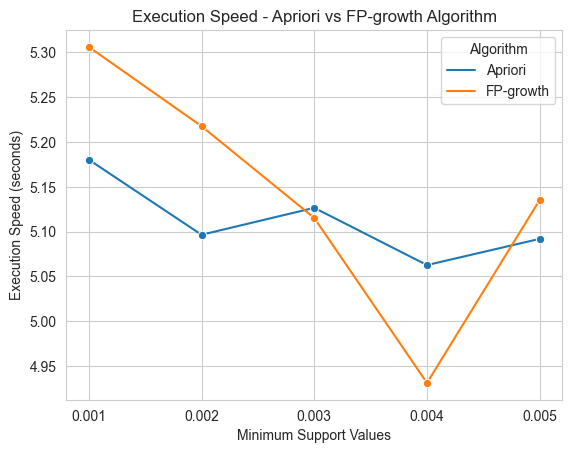

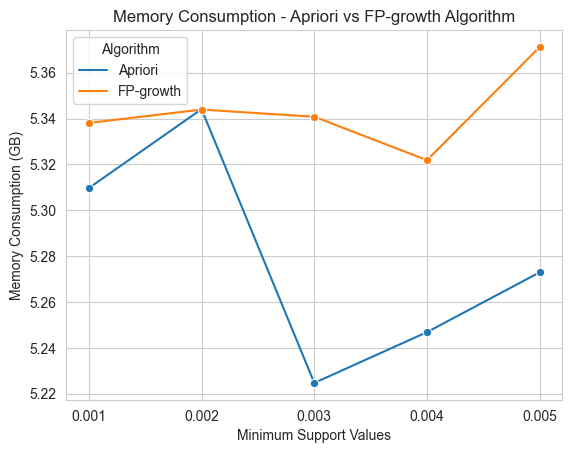

In [41]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
september_fpgrowth_extracted_rules, september_fpgrowth_execution_times, september_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['September'], algorithm=fpgrowth)

# Access the association rules variables
september_fpgrowth_rules_1 = september_fpgrowth_extracted_rules[0]
september_fpgrowth_rules_2 = september_fpgrowth_extracted_rules[1]
september_fpgrowth_rules_3 = september_fpgrowth_extracted_rules[2]
september_fpgrowth_rules_4 = september_fpgrowth_extracted_rules[3]
september_fpgrowth_rules_5 = september_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
september_apriori_extracted_rules, september_apriori_execution_times, september_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['September'], algorithm=apriori)

# Access the association rules variables
september_apriori_rules_1 = september_apriori_extracted_rules[0]
september_apriori_rules_2 = september_apriori_extracted_rules[1]
september_apriori_rules_3 = september_apriori_extracted_rules[2]
september_apriori_rules_4 = september_apriori_extracted_rules[3]
september_apriori_rules_5 = september_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=september_fpgrowth_execution_times,
                           fpgrowth_values=september_apriori_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=september_apriori_memory_consumed,
                           fpgrowth_values=september_fpgrowth_memory_consumed, memory_consumption=True)

In [170]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'September'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'September'])
len(x)
average_list_length(x)

len(september_fpgrowth_rules_1.sort_values('support', ascending=False))
len(september_apriori_rules_1.sort_values('support', ascending=False))

len(september_fpgrowth_rules_2.sort_values('support', ascending=False))
len(september_apriori_rules_2.sort_values('support', ascending=False))

len(september_fpgrowth_rules_3.sort_values('support', ascending=False))
len(september_apriori_rules_3.sort_values('support', ascending=False))

len(september_fpgrowth_rules_4.sort_values('support', ascending=False))
len(september_apriori_rules_4.sort_values('support', ascending=False))

len(september_fpgrowth_rules_5.sort_values('support', ascending=False))
len(september_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(september_apriori_execution_times)
sum(september_fpgrowth_execution_times)

mean(september_apriori_memory_consumed)
mean(september_fpgrowth_memory_consumed)

similar_association_rules(september_apriori_rules_1, september_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 64072 entries, 88 to 769073
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    64072 non-null  object        
 1   Transaction Date  64072 non-null  datetime64[ns]
 2   Sale Year         64072 non-null  int32         
 3   Sale Month        64072 non-null  object        
 4   Sale Day          64072 non-null  object        
 5   Sale Day Type     64072 non-null  object        
 6   Item Code         64072 non-null  int64         
 7   Item Name         64072 non-null  object        
 8   Major Category    64072 non-null  object        
 9   Units             64072 non-null  int64         
 10  Sold Qty          64072 non-null  float64       
 11  Purchase Price    64072 non-null  float64       
 12  Item Rate         64072 non-null  float64       
 13  Item Profit (%)   64072 non-null  float64       
 14  Sale Profit       64072 n

21912

2.924059875867105

568

568

188

188

98

98

50

50

24

24

25.7055983543396

25.558093070983887

5.2796473344

5.343162368

Association_Rule   
563                                  ['PUFF PUFF', 'FRIED CHICKEN'] => ['FRIED RICE']  \
412                                   ['NESTLE H2O (SMALL) 60CL'] => ['CHICKEN STEW']   
567                                     ['OFADA SAUCE'] => ['CHOPPED FRIED PLANTAIN']   
370                        ['FAMILY WHITE BREAD 950G'] => ['COWBELL MILK POWDER 12G']   
286                                               ['SAUSAGE ROLL'] => ['CHICKEN PIE']   
480                                                 ['FRIED RICE'] => ['JOLLOF RICE']   
160  ['FAMILY WHITE BREAD 950G'] => ['PEAK MILK REFILL POUCH FULL CREAM 400G / 380G']   
364                                ['COKE (PET) 35CL'] => ['NESTLE H2O (SMALL) 60CL']   
40                                                       ['CROISSANT'] => ['HOT DOG']   
134              ['FADAELLA LOLLIPOP WITH ALMOND 12G'] => ['FAMILY WHITE BREAD 950G']   

     Lift_apriori  Lift_fp-growth  
563        7.2114          7.2114  
412        3.0322          3.0322  
567        8.1196          8.1196  
370        2.7474          2.7474  
286        6.7402          6.7402  
480        4.1125          4.1125  
160        2.5279          2.5279  
364        1.8297          1.8297  
40        20.2187         20.2187  
134        1.7794          1.7794

#### November

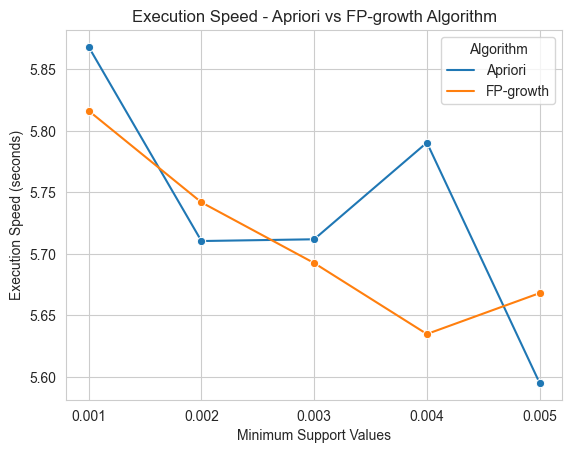

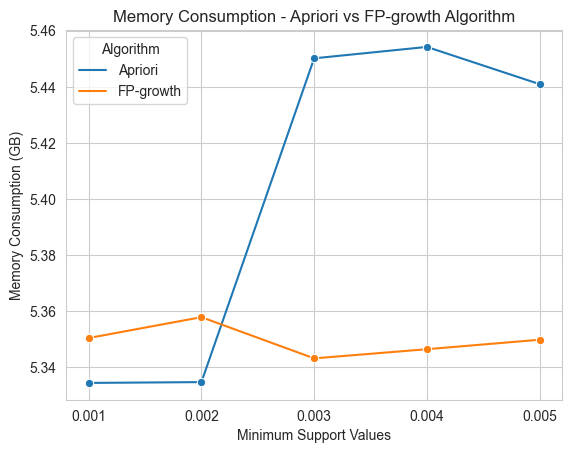

In [42]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
november_fpgrowth_extracted_rules, november_fpgrowth_execution_times, november_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['November'], algorithm=fpgrowth)

# Access the association rules variables
november_fpgrowth_rules_1 = november_fpgrowth_extracted_rules[0]
november_fpgrowth_rules_2 = november_fpgrowth_extracted_rules[1]
november_fpgrowth_rules_3 = november_fpgrowth_extracted_rules[2]
november_fpgrowth_rules_4 = november_fpgrowth_extracted_rules[3]
november_fpgrowth_rules_5 = november_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
november_apriori_extracted_rules, november_apriori_execution_times, november_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['November'], algorithm=apriori)

# Access the association rules variables
november_apriori_rules_1 = november_apriori_extracted_rules[0]
november_apriori_rules_2 = november_apriori_extracted_rules[1]
november_apriori_rules_3 = november_apriori_extracted_rules[2]
november_apriori_rules_4 = november_apriori_extracted_rules[3]
november_apriori_rules_5 = november_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=november_apriori_execution_times,
                           fpgrowth_values=november_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=november_apriori_memory_consumed,
                           fpgrowth_values=november_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(november_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'november', 'alldata')
# difference_association_rules(november_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'november', 'alldata')

In [171]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'November'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'November'])
len(x)
average_list_length(x)

len(november_fpgrowth_rules_1.sort_values('support', ascending=False))
len(november_apriori_rules_1.sort_values('support', ascending=False))

len(november_fpgrowth_rules_2.sort_values('support', ascending=False))
len(november_apriori_rules_2.sort_values('support', ascending=False))

len(november_fpgrowth_rules_3.sort_values('support', ascending=False))
len(november_apriori_rules_3.sort_values('support', ascending=False))

len(november_fpgrowth_rules_4.sort_values('support', ascending=False))
len(november_apriori_rules_4.sort_values('support', ascending=False))

len(november_fpgrowth_rules_5.sort_values('support', ascending=False))
len(november_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(november_apriori_execution_times)
sum(november_fpgrowth_execution_times)

mean(november_apriori_memory_consumed)
mean(november_fpgrowth_memory_consumed)

similar_association_rules(november_apriori_rules_1, november_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 72040 entries, 71 to 768306
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    72040 non-null  object        
 1   Transaction Date  72040 non-null  datetime64[ns]
 2   Sale Year         72040 non-null  int32         
 3   Sale Month        72040 non-null  object        
 4   Sale Day          72040 non-null  object        
 5   Sale Day Type     72040 non-null  object        
 6   Item Code         72040 non-null  int64         
 7   Item Name         72040 non-null  object        
 8   Major Category    72040 non-null  object        
 9   Units             72040 non-null  int64         
 10  Sold Qty          72040 non-null  float64       
 11  Purchase Price    72040 non-null  float64       
 12  Item Rate         72040 non-null  float64       
 13  Item Profit (%)   72040 non-null  float64       
 14  Sale Profit       72040 n

24572

2.9317922839003745

532

532

176

176

84

84

54

54

22

22

28.67604947090149

28.5536949634552

5.4028894208

5.3495742464000005

Association_Rule   
390               ['JOLLOF RICE'] => ['PUFF PUFF', 'CHOPPED FRIED PLANTAIN']  \
503                           ['JOLLOF RICE'] => ['CHICKEN SUYA', 'MOI-MOI']   
319                           ['MOI-MOI'] => ['CHICKEN SUYA', 'JOLLOF RICE']   
465  ['FANTASIA SPECIA BREAD 900G/LUX BREAD'] => ['FAMILY WHITE BREAD 950G']   
89                                           ['HOT DOG'] => ['SAUSAGE ROLL']   
481       ['FAMILY WHITE BREAD 950G'] => ['PURE BLISS MILK CREAM WAFER 45G']   
266                                      ['CHICKEN SUYA'] => ['JOLLOF RICE']   
234                                  ['PUFF PUFF'] => ['PEPSI MAX 40CL PET']   
329                   ['BIG PINK LADY APPLE'] => ['FAMILY WHITE BREAD 950G']   
451                     ['CHICKEN SUYA'] => ['JOLLOF RICE', 'FRIED CHICKEN']   

     Lift_apriori  Lift_fp-growth  
390        8.1655          8.1655  
503        9.4648          9.4648  
319        5.2504          5.2504  
465        2.5150          2.5150  
89        12.3002         12.3002  
481        1.9289          1.9289  
266        8.5843          8.5843  
234        1.5398          1.5398  
329        2.2411          2.2411  
451        4.5122          4.5122

#### March

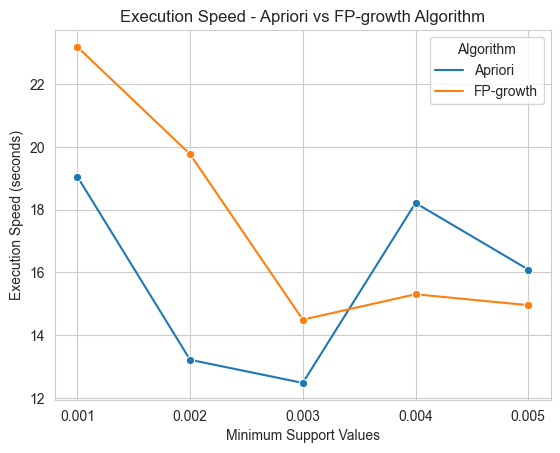

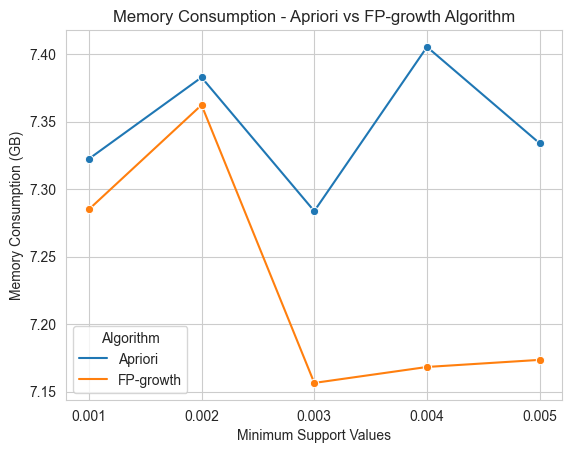

In [162]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
march_fpgrowth_extracted_rules, march_fpgrowth_execution_times, march_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['March'], algorithm=fpgrowth)

# Access the association rules variables
march_fpgrowth_rules_1 = march_fpgrowth_extracted_rules[0]
march_fpgrowth_rules_2 = march_fpgrowth_extracted_rules[1]
march_fpgrowth_rules_3 = march_fpgrowth_extracted_rules[2]
march_fpgrowth_rules_4 = march_fpgrowth_extracted_rules[3]
march_fpgrowth_rules_5 = march_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
march_apriori_extracted_rules, march_apriori_execution_times, march_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['March'], algorithm=apriori)

# Access the association rules variables
march_apriori_rules_1 = march_apriori_extracted_rules[0]
march_apriori_rules_2 = march_apriori_extracted_rules[1]
march_apriori_rules_3 = march_apriori_extracted_rules[2]
march_apriori_rules_4 = march_apriori_extracted_rules[3]
march_apriori_rules_5 = march_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=march_apriori_execution_times,
                           fpgrowth_values=march_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=march_apriori_memory_consumed,
                           fpgrowth_values=march_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(march_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'march', 'alldata')
# difference_association_rules(march_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'march', 'alldata')

In [172]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'March'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'March'])
len(x)
average_list_length(x)

len(march_fpgrowth_rules_1.sort_values('support', ascending=False))
len(march_apriori_rules_1.sort_values('support', ascending=False))

len(march_fpgrowth_rules_2.sort_values('support', ascending=False))
len(march_apriori_rules_2.sort_values('support', ascending=False))

len(march_fpgrowth_rules_3.sort_values('support', ascending=False))
len(march_apriori_rules_3.sort_values('support', ascending=False))

len(march_fpgrowth_rules_4.sort_values('support', ascending=False))
len(march_apriori_rules_4.sort_values('support', ascending=False))

len(march_fpgrowth_rules_5.sort_values('support', ascending=False))
len(march_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(march_apriori_execution_times)
sum(march_fpgrowth_execution_times)

mean(march_apriori_memory_consumed)
mean(march_fpgrowth_memory_consumed)

similar_association_rules(march_apriori_rules_1, march_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 67380 entries, 549 to 765841
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    67380 non-null  object        
 1   Transaction Date  67380 non-null  datetime64[ns]
 2   Sale Year         67380 non-null  int32         
 3   Sale Month        67380 non-null  object        
 4   Sale Day          67380 non-null  object        
 5   Sale Day Type     67380 non-null  object        
 6   Item Code         67380 non-null  int64         
 7   Item Name         67380 non-null  object        
 8   Major Category    67380 non-null  object        
 9   Units             67380 non-null  int64         
 10  Sold Qty          67380 non-null  float64       
 11  Purchase Price    67380 non-null  float64       
 12  Item Rate         67380 non-null  float64       
 13  Item Profit (%)   67380 non-null  float64       
 14  Sale Profit       67380 

24096

2.7963147410358564

420

420

124

124

66

66

32

32

14

14

79.05735063552856

87.71184730529785

7.345532928

7.2290131968

Association_Rule   
279                                                              ['MEAT PIE'] => ['MOI-MOI']  \
252                                                        ['CHICKEN SUYA'] => ['PUFF PUFF']   
402                                               ['BIGI ORANGE PET 600ML'] => ['PUFF PUFF']   
13                                                    ['SAUSAGE ROLL'] => ['FISH ROLL/ PIE']   
401                      ['FAMILY WHITE BREAD 950G'] => ['THREE CROWN EVAPORATED MILK159ML']   
396                                            ['MALTINA CLASSIC PET 33cl'] => ['PUFF PUFF']   
221  ['PEAK MILK REFILL POUCH FULL CREAM 400G / 380G'] => ['MILO SACHET MEDIUM 500G / 550G']   
201                                                 ['PLAIN DOUGHNUT'] => ['FISH ROLL/ PIE']   
185                               ['CHOPPED FRIED PLANTAIN'] => ['PUFF PUFF', 'JOLLOF RICE']   
367                                        ['PUFF PUFF'] => ['TEEM BITTER LEMON (PET) 50CL']   

     Lift_apriori  Lift_fp-growth  
279        1.9048          1.9048  
252        1.7494          1.7494  
402        1.9284          1.9284  
13        14.3135         14.3135  
401        3.7011          3.7011  
396        1.5329          1.5329  
221       35.4557         35.4557  
201       10.4530         10.4530  
185       12.5679         12.5679  
367        1.5903          1.5903

#### February

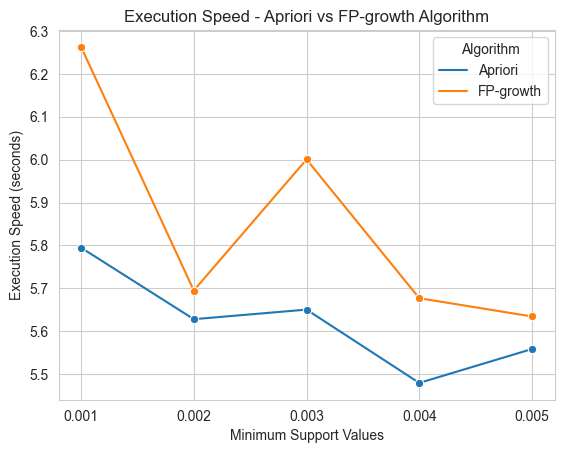

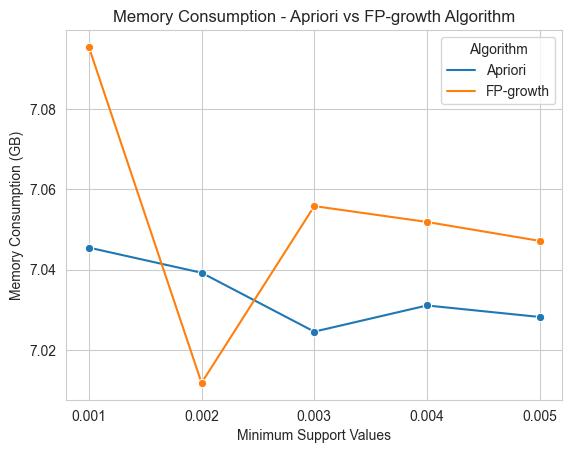

In [44]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
february_fpgrowth_extracted_rules, february_fpgrowth_execution_times, february_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['February'], algorithm=fpgrowth)

# Access the association rules variables
february_fpgrowth_rules_1 = february_fpgrowth_extracted_rules[0]
february_fpgrowth_rules_2 = february_fpgrowth_extracted_rules[1]
february_fpgrowth_rules_3 = february_fpgrowth_extracted_rules[2]
february_fpgrowth_rules_4 = february_fpgrowth_extracted_rules[3]
february_fpgrowth_rules_5 = february_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
february_apriori_extracted_rules, february_apriori_execution_times, february_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['February'], algorithm=apriori)

# Access the association rules variables
february_apriori_rules_1 = february_apriori_extracted_rules[0]
february_apriori_rules_2 = february_apriori_extracted_rules[1]
february_apriori_rules_3 = february_apriori_extracted_rules[2]
february_apriori_rules_4 = february_apriori_extracted_rules[3]
february_apriori_rules_5 = february_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=february_apriori_execution_times,
                           fpgrowth_values=february_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=february_apriori_memory_consumed,
                           fpgrowth_values=february_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(february_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'february', 'alldata')
# difference_association_rules(february_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'february', 'alldata')

In [173]:
differential_sales_data[differential_sales_data['Sale Month'] == 'February'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'February'])
len(x)
average_list_length(x)

len(february_fpgrowth_rules_1.sort_values('support', ascending=False))
len(february_apriori_rules_1.sort_values('support', ascending=False))

len(february_fpgrowth_rules_2.sort_values('support', ascending=False))
len(february_apriori_rules_2.sort_values('support', ascending=False))

len(february_fpgrowth_rules_3.sort_values('support', ascending=False))
len(february_apriori_rules_3.sort_values('support', ascending=False))

len(february_fpgrowth_rules_4.sort_values('support', ascending=False))
len(february_apriori_rules_4.sort_values('support', ascending=False))

len(february_fpgrowth_rules_5.sort_values('support', ascending=False))
len(february_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(february_apriori_execution_times)
sum(february_fpgrowth_execution_times)

mean(february_apriori_memory_consumed)
mean(february_fpgrowth_memory_consumed)

similar_association_rules(february_apriori_rules_1, february_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 70633 entries, 268 to 758451
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    70633 non-null  object        
 1   Transaction Date  70633 non-null  datetime64[ns]
 2   Sale Year         70633 non-null  int32         
 3   Sale Month        70633 non-null  object        
 4   Sale Day          70633 non-null  object        
 5   Sale Day Type     70633 non-null  object        
 6   Item Code         70633 non-null  int64         
 7   Item Name         70633 non-null  object        
 8   Major Category    70633 non-null  object        
 9   Units             70633 non-null  int64         
 10  Sold Qty          70633 non-null  float64       
 11  Purchase Price    70633 non-null  float64       
 12  Item Rate         70633 non-null  float64       
 13  Item Profit (%)   70633 non-null  float64       
 14  Sale Profit       70633 

24515

2.8812155822965533

454

454

140

140

82

82

40

40

16

16

28.112865686416626

29.269973516464233

7.0336831488

7.0524174336

Association_Rule   
315                    ['JOLLOF RICE'] => ['NESTLE H2O (SMALL) 60CL']  \
220                         ['CHICKEN ONION SAUCE'] => ['FRIED RICE']   
379                  ['MIRINDA ORANGE (PET) 50CL'] => ['CHICKEN PIE']   
30   ['GOLDEN PENNY SUGAR CUBES 500g'] => ['FAMILY WHITE BREAD 950G']   
428                      ['FANTA ORANGE (PET) 60CL'] => ['PUFF PUFF']   
397                   ['PEPSI MAX 40CL PET'] => ['SPRITE (PET) 35CL']   
47    ['FAMILY WHITE BREAD 950G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
255                               ['PUFF PUFF'] => ['CHICKEN PAELLA']   
233                                      ['PUFF PUFF'] => ['RAISINS']   
61                         ['MOI-MOI'] => ['NESTLE H2O (SMALL) 60CL']   

     Lift_apriori  Lift_fp-growth  
315        1.5049          1.5049  
220       10.1344         10.1344  
379        1.8585          1.8585  
30         2.9025          2.9025  
428        2.0489          2.0489  
397        2.8161          2.8161  
47         3.5823          3.5823  
255        2.2249          2.2249  
233        1.9368          1.9368  
61         1.5332          1.5332

#### August

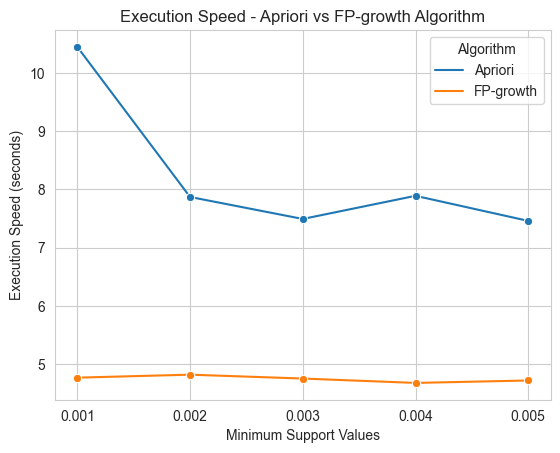

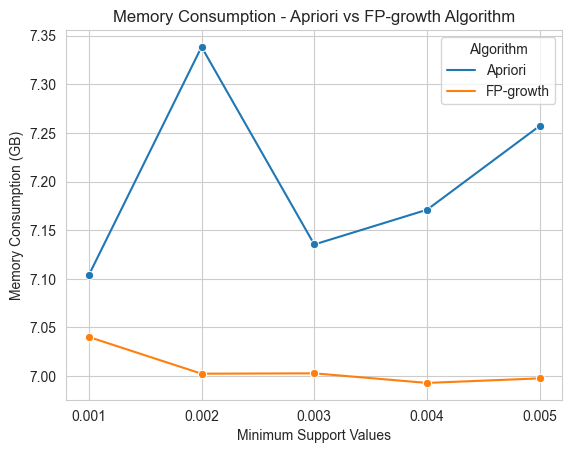

In [45]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
august_fpgrowth_extracted_rules, august_fpgrowth_execution_times, august_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['August'], algorithm=fpgrowth)

# Access the association rules variables
august_fpgrowth_rules_1 = august_fpgrowth_extracted_rules[0]
august_fpgrowth_rules_2 = august_fpgrowth_extracted_rules[1]
august_fpgrowth_rules_3 = august_fpgrowth_extracted_rules[2]
august_fpgrowth_rules_4 = august_fpgrowth_extracted_rules[3]
august_fpgrowth_rules_5 = august_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
august_apriori_extracted_rules, august_apriori_execution_times, august_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['August'], algorithm=apriori)

# Access the association rules variables
august_apriori_rules_1 = august_apriori_extracted_rules[0]
august_apriori_rules_2 = august_apriori_extracted_rules[1]
august_apriori_rules_3 = august_apriori_extracted_rules[2]
august_apriori_rules_4 = august_apriori_extracted_rules[3]
august_apriori_rules_5 = august_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=august_apriori_execution_times,
                           fpgrowth_values=august_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=august_apriori_memory_consumed,
                           fpgrowth_values=august_fpgrowth_memory_consumed, memory_consumption=True)

In [174]:
differential_sales_data[differential_sales_data['Sale Month'] == 'August'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'August'])
len(x)
average_list_length(x)

len(august_fpgrowth_rules_1.sort_values('support', ascending=False))
len(august_apriori_rules_1.sort_values('support', ascending=False))

len(august_fpgrowth_rules_2.sort_values('support', ascending=False))
len(august_apriori_rules_2.sort_values('support', ascending=False))

len(august_fpgrowth_rules_3.sort_values('support', ascending=False))
len(august_apriori_rules_3.sort_values('support', ascending=False))

len(august_fpgrowth_rules_4.sort_values('support', ascending=False))
len(august_apriori_rules_4.sort_values('support', ascending=False))

len(august_fpgrowth_rules_5.sort_values('support', ascending=False))
len(august_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(august_apriori_execution_times)
sum(august_fpgrowth_execution_times)

mean(august_apriori_memory_consumed)
mean(august_fpgrowth_memory_consumed)

similar_association_rules(august_apriori_rules_1, august_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 61678 entries, 5 to 694648
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    61678 non-null  object        
 1   Transaction Date  61678 non-null  datetime64[ns]
 2   Sale Year         61678 non-null  int32         
 3   Sale Month        61678 non-null  object        
 4   Sale Day          61678 non-null  object        
 5   Sale Day Type     61678 non-null  object        
 6   Item Code         61678 non-null  int64         
 7   Item Name         61678 non-null  object        
 8   Major Category    61678 non-null  object        
 9   Units             61678 non-null  int64         
 10  Sold Qty          61678 non-null  float64       
 11  Purchase Price    61678 non-null  float64       
 12  Item Rate         61678 non-null  float64       
 13  Item Profit (%)   61678 non-null  float64       
 14  Sale Profit       61678 no

19911

3.09768469690121

534

534

172

172

80

80

54

54

30

30

41.167314767837524

23.726752996444702

7.201169408

7.0072541184

Association_Rule   
252                                                                          ['CHICKEN PIE'] => ['COKE ORIGINAL (PET)  60CL']  \
111                                                                                        ['FRIED RICE'] => ['CHICKEN STEW']   
38   ['PURE BLISS STRAWBERRY CREAM WAFER 45G'] => ['PURE BLISS MILK CREAM WAFER 45G', 'PURE BLISS CHOCOLATE CREAN WAFER 45G']   
526                            ['PEAK MILK POWDER SACHET 16G', 'FAMILY WHITE BREAD 950G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
306                                                                                                ['FRIED RICE'] => ['ASUN']   
172                                                                                         ['PUFF PUFF'] => ['SAUSAGE ROLL']   
369                                                                          ['PUFF PUFF'] => ['LA CASERA  APPLE DRINK 35CL']   
136                                                                                          ['COWLEG STEW'] => ['PUFF PUFF']   
473                                                                      ['FANTA ORANGE (PET) 60CL'] => ['SPRITE (PET) 60CL']   
286                                                                ['PUFF PUFF'] => ['JOLLOF RICE', 'CHOPPED FRIED PLANTAIN']   

     Lift_apriori  Lift_fp-growth  
252        1.7834          1.7834  
111       10.7297         10.7297  
38       146.0775        146.0775  
526       49.1775         49.1775  
306       10.2502         10.2502  
172        2.1619          2.1619  
369        1.9373          1.9373  
136        1.6913          1.6913  
473       14.2971         14.2971  
286        1.8530          1.8530

#### October

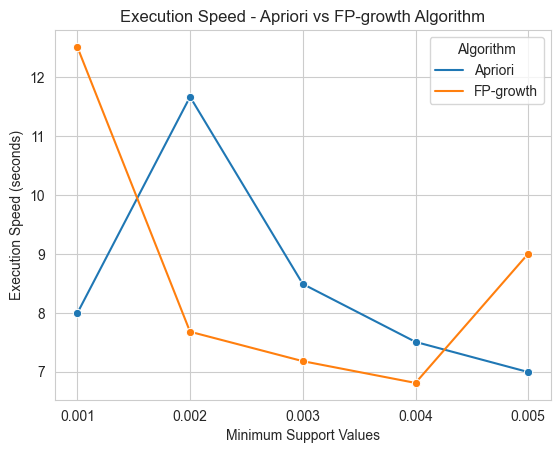

In [46]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
october_fpgrowth_extracted_rules, october_fpgrowth_execution_times, october_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['October'], algorithm=fpgrowth)

# Access the association rules variables
october_fpgrowth_rules_1 = october_fpgrowth_extracted_rules[0]
october_fpgrowth_rules_2 = october_fpgrowth_extracted_rules[1]
october_fpgrowth_rules_3 = october_fpgrowth_extracted_rules[2]
october_fpgrowth_rules_4 = october_fpgrowth_extracted_rules[3]
october_fpgrowth_rules_5 = october_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
october_apriori_extracted_rules, october_apriori_execution_times, october_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['October'], algorithm=apriori)

# Access the association rules variables
october_apriori_rules_1 = october_apriori_extracted_rules[0]
october_apriori_rules_2 = october_apriori_extracted_rules[1]
october_apriori_rules_3 = october_apriori_extracted_rules[2]
october_apriori_rules_4 = october_apriori_extracted_rules[3]
october_apriori_rules_5 = october_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=october_apriori_execution_times,
                           fpgrowth_values=october_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=october_apriori_memory_consumed,
                           fpgrowth_values=october_fpgrowth_memory_consumed, memory_consumption=True)

In [175]:
differential_sales_data[differential_sales_data['Sale Month'] == 'October'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'October'])
len(x)
average_list_length(x)

len(october_fpgrowth_rules_1.sort_values('support', ascending=False))
len(october_apriori_rules_1.sort_values('support', ascending=False))

len(october_fpgrowth_rules_2.sort_values('support', ascending=False))
len(october_apriori_rules_2.sort_values('support', ascending=False))

len(october_fpgrowth_rules_3.sort_values('support', ascending=False))
len(october_apriori_rules_3.sort_values('support', ascending=False))

len(october_fpgrowth_rules_4.sort_values('support', ascending=False))
len(october_apriori_rules_4.sort_values('support', ascending=False))

len(october_fpgrowth_rules_5.sort_values('support', ascending=False))
len(october_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(october_apriori_execution_times)
sum(october_fpgrowth_execution_times)

mean(october_apriori_memory_consumed)
mean(october_fpgrowth_memory_consumed)

similar_association_rules(october_apriori_rules_1, october_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 61078 entries, 79 to 768909
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    61078 non-null  object        
 1   Transaction Date  61078 non-null  datetime64[ns]
 2   Sale Year         61078 non-null  int32         
 3   Sale Month        61078 non-null  object        
 4   Sale Day          61078 non-null  object        
 5   Sale Day Type     61078 non-null  object        
 6   Item Code         61078 non-null  int64         
 7   Item Name         61078 non-null  object        
 8   Major Category    61078 non-null  object        
 9   Units             61078 non-null  int64         
 10  Sold Qty          61078 non-null  float64       
 11  Purchase Price    61078 non-null  float64       
 12  Item Rate         61078 non-null  float64       
 13  Item Profit (%)   61078 non-null  float64       
 14  Sale Profit       61078 n

19940

3.0630892678034103

556

556

172

172

82

82

48

48

30

30

42.64110994338989

43.17528986930847

7.12699904

7.0241796096

Association_Rule   
415                                     ['CHICKEN PAELLA'] => ['JOLLOF RICE']  \
423                              ['COKE (PET) 35CL'] => ['SPRITE (PET) 35CL']   
386                              ['JOLLOF RICE'] => ['PUFF PUFF', 'MEAT PIE']   
281  ['OVALTINE MALTED FOOD DRINK SACHET 18G'] => ['FAMILY WHITE BREAD 950G']   
239                                ['FRIED CROAKER FISH'] => ['CHICKEN SUYA']   
276                              ['PUFF PUFF', 'MEAT PIE'] => ['JOLLOF RICE']   
144                                           ['BOILED YAM'] => ['EGG SAUCE']   
500                               ['CHICKEN SUYA'] => ['AQUAFINA SMALL 75CL']   
504                           ['JOLLOF RICE'] => ['CHICKEN SUYA', 'MEAT PIE']   
98                                              ['MEAT PIE'] => ['CROISSANT']   

     Lift_apriori  Lift_fp-growth  
415        5.0767          5.0767  
423       20.2213         20.2213  
386        1.7781          1.7781  
281        3.1453          3.1453  
239        3.5192          3.5192  
276        1.7781          1.7781  
144       98.6121         98.6121  
500        1.8189          1.8189  
504        8.3083          8.3083  
98         6.4170          6.4170

#### July

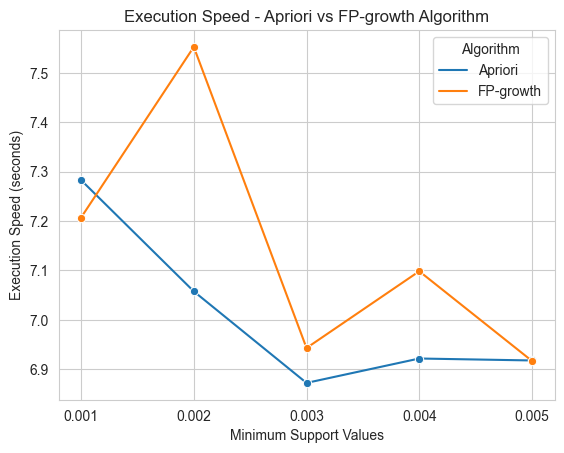

In [47]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
july_fpgrowth_extracted_rules, july_fpgrowth_execution_times, july_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['July'], algorithm=fpgrowth)

# Access the association rules variables
july_fpgrowth_rules_1 = july_fpgrowth_extracted_rules[0]
july_fpgrowth_rules_2 = july_fpgrowth_extracted_rules[1]
july_fpgrowth_rules_3 = july_fpgrowth_extracted_rules[2]
july_fpgrowth_rules_4 = july_fpgrowth_extracted_rules[3]
july_fpgrowth_rules_5 = july_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
july_apriori_extracted_rules, july_apriori_execution_times, july_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['July'], algorithm=apriori)

# Access the association rules variables
july_apriori_rules_1 = july_apriori_extracted_rules[0]
july_apriori_rules_2 = july_apriori_extracted_rules[1]
july_apriori_rules_3 = july_apriori_extracted_rules[2]
july_apriori_rules_4 = july_apriori_extracted_rules[3]
july_apriori_rules_5 = july_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=july_apriori_execution_times,
                           fpgrowth_values=july_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=july_apriori_memory_consumed,
                           fpgrowth_values=july_fpgrowth_memory_consumed, memory_consumption=True)

In [176]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'July'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'July'])
len(x)
average_list_length(x)

len(july_fpgrowth_rules_1.sort_values('support', ascending=False))
len(july_apriori_rules_1.sort_values('support', ascending=False))

len(july_fpgrowth_rules_2.sort_values('support', ascending=False))
len(july_apriori_rules_2.sort_values('support', ascending=False))

len(july_fpgrowth_rules_3.sort_values('support', ascending=False))
len(july_apriori_rules_3.sort_values('support', ascending=False))

len(july_fpgrowth_rules_4.sort_values('support', ascending=False))
len(july_apriori_rules_4.sort_values('support', ascending=False))

len(july_fpgrowth_rules_5.sort_values('support', ascending=False))
len(july_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(july_apriori_execution_times)
sum(july_fpgrowth_execution_times)

mean(july_apriori_memory_consumed)
mean(july_fpgrowth_memory_consumed)

similar_association_rules(july_apriori_rules_1, july_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 60579 entries, 23 to 762828
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    60579 non-null  object        
 1   Transaction Date  60579 non-null  datetime64[ns]
 2   Sale Year         60579 non-null  int32         
 3   Sale Month        60579 non-null  object        
 4   Sale Day          60579 non-null  object        
 5   Sale Day Type     60579 non-null  object        
 6   Item Code         60579 non-null  int64         
 7   Item Name         60579 non-null  object        
 8   Major Category    60579 non-null  object        
 9   Units             60579 non-null  int64         
 10  Sold Qty          60579 non-null  float64       
 11  Purchase Price    60579 non-null  float64       
 12  Item Rate         60579 non-null  float64       
 13  Item Profit (%)   60579 non-null  float64       
 14  Sale Profit       60579 n

19680

3.078201219512195

542

542

160

160

86

86

58

58

28

28

35.05204224586487

35.717673540115356

6.9607170048

6.9919744

Association_Rule   
178                         ['MALTINA CLASSIC PET 33cl'] => ['MEAT PIE']  \
379                       ['PUFF PUFF'] => ['TITUS FISH', 'JOLLOF RICE']   
149                                     ['FRIED RICE'] => ['TITUS FISH']   
116          ['UNICORN EGGS CRATE 30PCS'] => ['FAMILY WHITE BREAD 950G']   
460                        ['FRIED RICE'] => ['FANTA ORANGE (PET) 60CL']   
25                         ['PUFF PUFF'] => ['JOLLOF RICE', 'BEEF STEW']   
409                      ['NESTLE H2O (SMALL) 60CL'] => ['CHICKEN STEW']   
344                    ['MEAT PIE'] => ['CHICKEN PIE', 'PLAIN DOUGHNUT']   
519  ['FAMILY WHITE BREAD 950G'] => ['THREE CROWN EVAPORATED MILK159ML']   
217  ['MILO 20g (ENERGY FOOD DRINK)'] => ['PEAK MILK POWDER SACHET 16G']   

     Lift_apriori  Lift_fp-growth  
178        1.8767          1.8767  
379        2.2955          2.2955  
149       10.5770         10.5770  
116        2.5613          2.5613  
460        2.8205          2.8205  
25         1.8869          1.8869  
409        3.7298          3.7298  
344        5.0483          5.0483  
519        2.9089          2.9089  
217       43.6161         43.6161

#### June

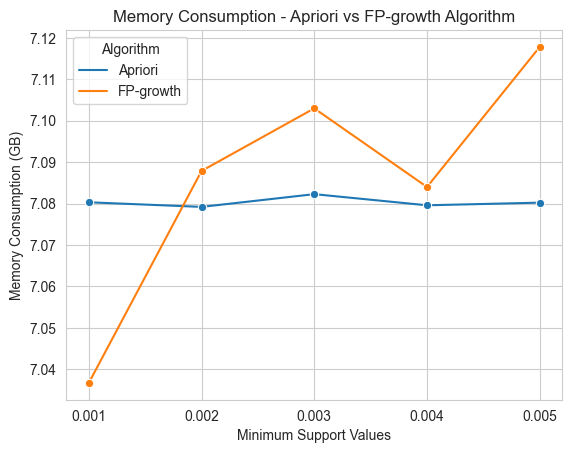

In [48]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
june_fpgrowth_extracted_rules, june_fpgrowth_execution_times, june_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['June'], algorithm=fpgrowth)

# Access the association rules variables
june_fpgrowth_rules_1 = june_fpgrowth_extracted_rules[0]
june_fpgrowth_rules_2 = june_fpgrowth_extracted_rules[1]
june_fpgrowth_rules_3 = june_fpgrowth_extracted_rules[2]
june_fpgrowth_rules_4 = june_fpgrowth_extracted_rules[3]
june_fpgrowth_rules_5 = june_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
june_apriori_extracted_rules, june_apriori_execution_times, june_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['June'], algorithm=apriori)

# Access the association rules variables
june_apriori_rules_1 = june_apriori_extracted_rules[0]
june_apriori_rules_2 = june_apriori_extracted_rules[1]
june_apriori_rules_3 = june_apriori_extracted_rules[2]
june_apriori_rules_4 = june_apriori_extracted_rules[3]
june_apriori_rules_5 = june_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=june_apriori_execution_times,
                           fpgrowth_values=june_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=june_apriori_memory_consumed,
                           fpgrowth_values=june_fpgrowth_memory_consumed, memory_consumption=True)

In [177]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'June'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'June'])
len(x)
average_list_length(x)

len(june_fpgrowth_rules_1.sort_values('support', ascending=False))
len(june_apriori_rules_1.sort_values('support', ascending=False))

len(june_fpgrowth_rules_2.sort_values('support', ascending=False))
len(june_apriori_rules_2.sort_values('support', ascending=False))

len(june_fpgrowth_rules_3.sort_values('support', ascending=False))
len(june_apriori_rules_3.sort_values('support', ascending=False))

len(june_fpgrowth_rules_4.sort_values('support', ascending=False))
len(june_apriori_rules_4.sort_values('support', ascending=False))

len(june_fpgrowth_rules_5.sort_values('support', ascending=False))
len(june_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(june_apriori_execution_times)
sum(june_fpgrowth_execution_times)

mean(june_apriori_memory_consumed)
mean(june_fpgrowth_memory_consumed)

similar_association_rules(june_apriori_rules_1, june_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 59113 entries, 38 to 763986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    59113 non-null  object        
 1   Transaction Date  59113 non-null  datetime64[ns]
 2   Sale Year         59113 non-null  int32         
 3   Sale Month        59113 non-null  object        
 4   Sale Day          59113 non-null  object        
 5   Sale Day Type     59113 non-null  object        
 6   Item Code         59113 non-null  int64         
 7   Item Name         59113 non-null  object        
 8   Major Category    59113 non-null  object        
 9   Units             59113 non-null  int64         
 10  Sold Qty          59113 non-null  float64       
 11  Purchase Price    59113 non-null  float64       
 12  Item Rate         59113 non-null  float64       
 13  Item Profit (%)   59113 non-null  float64       
 14  Sale Profit       59113 n

19419

3.044080539677635

474

474

142

142

78

78

40

40

20

20

34.97445106506348

62.948811531066895

7.0803046400000005

7.0858645504

Association_Rule   
214                              ['FRIED CROAKER FISH'] => ['MEAT PIE']  \
211  ['FAMILY WHITE BREAD 950G'] => ['ORAL B PROHEALTH FRESH GEL 140G']   
61                                    ['FRIED RICE'] => ['CHICKEN PIE']   
362                  ['HERO CAN 500ML'] => ['LIFE LAGER BEER CAN 50CL']   
273                                          ['FRIED RICE'] => ['ASUN']   
250                  ['BREAKFAST ROLLS'] => ['FAMILY WHITE BREAD 950G']   
411          ['MEAT PIE', 'FAMILY WHITE BREAD 950G'] => ['CHICKEN PIE']   
73                       ['JOLLOF RICE'] => ['PUFF PUFF', 'FRIED RICE']   
344                      ['FRIED RICE', 'JOLLOF RICE'] => ['PUFF PUFF']   
337                          ['JOLLOF RICE'] => ['CHICKEN ONION SAUCE']   

     Lift_apriori  Lift_fp-growth  
214        1.5681          1.5681  
211        2.1224          2.1224  
61         1.8175          1.8175  
362       29.9788         29.9788  
273       10.0446         10.0446  
250        2.8188          2.8188  
411        4.6178          4.6178  
73         8.6899          8.6899  
344        2.4725          2.4725  
337       10.7387         10.7387

#### May

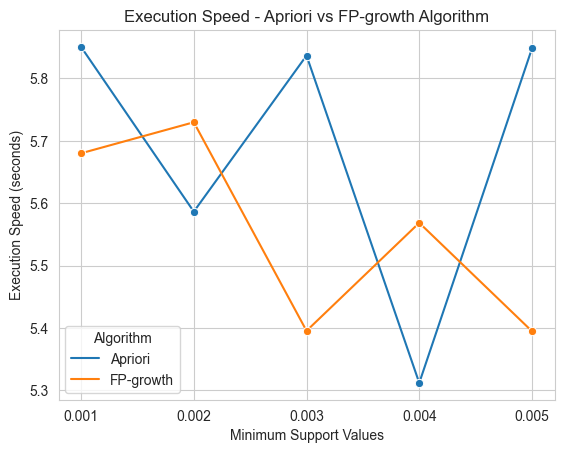

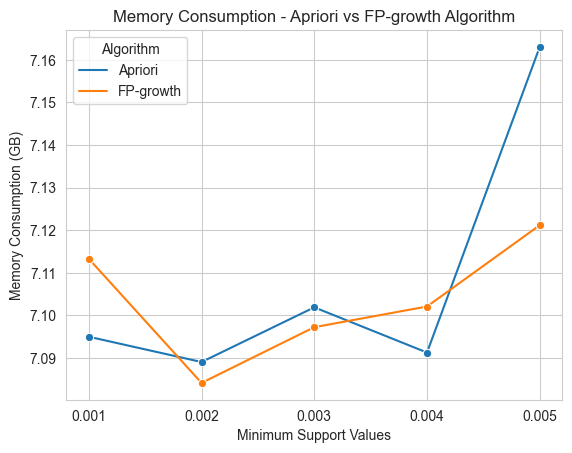

In [49]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
may_fpgrowth_extracted_rules, may_fpgrowth_execution_times, may_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['May'], algorithm=fpgrowth)

# Access the association rules variables
may_fpgrowth_rules_1 = may_fpgrowth_extracted_rules[0]
may_fpgrowth_rules_2 = may_fpgrowth_extracted_rules[1]
may_fpgrowth_rules_3 = may_fpgrowth_extracted_rules[2]
may_fpgrowth_rules_4 = may_fpgrowth_extracted_rules[3]
may_fpgrowth_rules_5 = may_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
may_apriori_extracted_rules, may_apriori_execution_times, may_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['May'], algorithm=apriori)

# Access the association rules variables
may_apriori_rules_1 = may_apriori_extracted_rules[0]
may_apriori_rules_2 = may_apriori_extracted_rules[1]
may_apriori_rules_3 = may_apriori_extracted_rules[2]
may_apriori_rules_4 = may_apriori_extracted_rules[3]
may_apriori_rules_5 = may_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=may_apriori_execution_times,
                           fpgrowth_values=may_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=may_apriori_memory_consumed,
                           fpgrowth_values=may_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(july_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'july', 'alldata')
# difference_association_rules(july_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'july', 'alldata')

In [178]:
def average_list_length(list_of_lists):
    total_length = 0
    count = 0

    for sublist in list_of_lists:
        total_length += len(sublist)
        count += 1

    average_length = total_length / count

    return average_length


differential_sales_data[differential_sales_data['Sale Month'] == 'May'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'May'])
len(x)
average_list_length(x)

len(may_fpgrowth_rules_1.sort_values('support', ascending=False))
len(may_apriori_rules_1.sort_values('support', ascending=False))

len(may_fpgrowth_rules_2.sort_values('support', ascending=False))
len(may_apriori_rules_2.sort_values('support', ascending=False))

len(may_fpgrowth_rules_3.sort_values('support', ascending=False))
len(may_apriori_rules_3.sort_values('support', ascending=False))

len(may_fpgrowth_rules_4.sort_values('support', ascending=False))
len(may_apriori_rules_4.sort_values('support', ascending=False))

len(may_fpgrowth_rules_5.sort_values('support', ascending=False))
len(may_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(may_apriori_execution_times)
sum(may_fpgrowth_execution_times)

mean(may_apriori_memory_consumed)
mean(may_fpgrowth_memory_consumed)

similar_association_rules(may_apriori_rules_1, may_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 55593 entries, 55 to 767011
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    55593 non-null  object        
 1   Transaction Date  55593 non-null  datetime64[ns]
 2   Sale Year         55593 non-null  int32         
 3   Sale Month        55593 non-null  object        
 4   Sale Day          55593 non-null  object        
 5   Sale Day Type     55593 non-null  object        
 6   Item Code         55593 non-null  int64         
 7   Item Name         55593 non-null  object        
 8   Major Category    55593 non-null  object        
 9   Units             55593 non-null  int64         
 10  Sold Qty          55593 non-null  float64       
 11  Purchase Price    55593 non-null  float64       
 12  Item Rate         55593 non-null  float64       
 13  Item Profit (%)   55593 non-null  float64       
 14  Sale Profit       55593 n

15327

3.6271285965942455

400

400

128

128

60

60

26

26

18

18

28.432875394821167

27.76785969734192

7.1080321024

7.10356992

Association_Rule   
4    ['FAMILY WHITE BREAD 950G'] => ['ROSE PLUS WHITE TOILET TISSUE BOULOS - IMPROVED']  \
285                                      ['JOLLOF RICE'] => ['NESTLE H2O (SMALL) 60CL']   
366                                                   ['JOLLOF RICE'] => ['TITUS FISH']   
372                                        ['FANTA ORANGE (PET) 60CL'] => ['PUFF PUFF']   
355                      ['PEAK MILK POWDER SACHET 16G'] => ['FAMILY WHITE BREAD 950G']   
56                                 ['HERO CAN 500ML'] => ['GUINNESS S/STOUT CAN 330ML']   
343                                ['FANTA ORANGE (PET) 60CL'] => ['SPRITE (PET) 60CL']   
186                             ['SMOOV CHAPMAN 50CL'] => ['COKE ORIGINAL (PET)  60CL']   
244                                      ['CHICKEN PIE'] => ['FANTA ORANGE (PET) 60CL']   
117                                                    ['FRIED RICE'] => ['TITUS FISH']   

     Lift_apriori  Lift_fp-growth  
4          1.5336          1.5336  
285        2.1655          2.1655  
366       25.8298         25.8298  
372        2.1476          2.1476  
355        2.3945          2.3945  
56         9.5809          9.5809  
343       11.7336         11.7336  
186        4.8609          4.8609  
244        3.5387          3.5387  
117       37.4366         37.4366

#### April

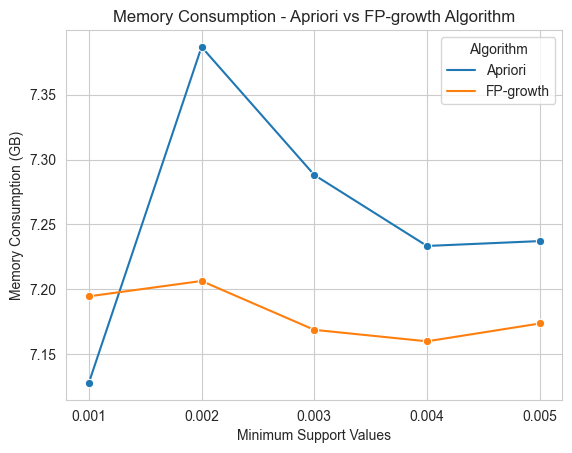

In [50]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
april_fpgrowth_extracted_rules, april_fpgrowth_execution_times, april_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['April'], algorithm=fpgrowth)

# Access the association rules variables
april_fpgrowth_rules_1 = april_fpgrowth_extracted_rules[0]
april_fpgrowth_rules_2 = april_fpgrowth_extracted_rules[1]
april_fpgrowth_rules_3 = april_fpgrowth_extracted_rules[2]
april_fpgrowth_rules_4 = april_fpgrowth_extracted_rules[3]
april_fpgrowth_rules_5 = april_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
april_apriori_extracted_rules, april_apriori_execution_times, april_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, month=['April'], algorithm=apriori)

# Access the association rules variables
april_apriori_rules_1 = april_apriori_extracted_rules[0]
april_apriori_rules_2 = april_apriori_extracted_rules[1]
april_apriori_rules_3 = april_apriori_extracted_rules[2]
april_apriori_rules_4 = april_apriori_extracted_rules[3]
april_apriori_rules_5 = april_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=april_apriori_execution_times,
                           fpgrowth_values=april_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=april_apriori_memory_consumed,
                           fpgrowth_values=april_fpgrowth_memory_consumed, memory_consumption=True)

In [179]:
differential_sales_data[differential_sales_data['Sale Month'] == 'April'].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Sale Month'] == 'April'])
len(x)
average_list_length(x)

len(april_fpgrowth_rules_1.sort_values('support', ascending=False))
len(april_apriori_rules_1.sort_values('support', ascending=False))

len(april_fpgrowth_rules_2.sort_values('support', ascending=False))
len(april_apriori_rules_2.sort_values('support', ascending=False))

len(april_fpgrowth_rules_3.sort_values('support', ascending=False))
len(april_apriori_rules_3.sort_values('support', ascending=False))

len(april_fpgrowth_rules_4.sort_values('support', ascending=False))
len(april_apriori_rules_4.sort_values('support', ascending=False))

len(april_fpgrowth_rules_5.sort_values('support', ascending=False))
len(april_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(april_apriori_execution_times)
sum(april_fpgrowth_execution_times)

mean(april_apriori_memory_consumed)
mean(april_fpgrowth_memory_consumed)

similar_association_rules(april_apriori_rules_1, april_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 44586 entries, 0 to 544376
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    44586 non-null  object        
 1   Transaction Date  44586 non-null  datetime64[ns]
 2   Sale Year         44586 non-null  int32         
 3   Sale Month        44586 non-null  object        
 4   Sale Day          44586 non-null  object        
 5   Sale Day Type     44586 non-null  object        
 6   Item Code         44586 non-null  int64         
 7   Item Name         44586 non-null  object        
 8   Major Category    44586 non-null  object        
 9   Units             44586 non-null  int64         
 10  Sold Qty          44586 non-null  float64       
 11  Purchase Price    44586 non-null  float64       
 12  Item Rate         44586 non-null  float64       
 13  Item Profit (%)   44586 non-null  float64       
 14  Sale Profit       44586 no

10999

4.0536412401127375

792

792

174

174

104

104

60

60

38

38

28.293123245239258

28.998471975326538

7.2547024896

7.1807410176

Association_Rule   
268  ['MILO SACHET MEDIUM 500G / 550G'] => ['THREE CROWN POWDER MILK 380G']  \
400      ['SUNLIGHT POWDER  TROP 2IN1 900G'] => ['FAMILY WHITE BREAD 950G']   
54                ['GUINNESS S/STOUT CAN 330ML'] => ['BUDWEISER CAN 500ML']   
660                                        ['MEAT PIE'] => ['BUTTER BREAD']   
161   ['FAMILY WHITE BREAD 950G'] => ['PEAK EVAPORATED MILK 157ML / 160ML']   
784             ['MEAT PIE'] => ['5 ALIVE PULPY ORANGE  (PET) 40CL / 30CL']   
141                  ['HOT DOG'] => ['MEAT PIE', 'FAMILY WHITE BREAD 950G']   
192                  ['GUINNESS S/STOUT CAN 330ML'] => ['ORIJIN CAN 330ML']   
612                                    ['MEAT PIE'] => ['FRUIT BREAD 550g']   
226                    ['COKE (PET) 35CL'] => ['COKE ORIGINAL (PET)  60CL']   

     Lift_apriori  Lift_fp-growth  
268       14.7308         14.7308  
400        1.6957          1.6957  
54         5.1980          5.1980  
660        1.5584          1.5584  
161        1.6522          1.6522  
784        2.0505          2.0505  
141        6.5587          6.5587  
192        8.4193          8.4193  
612        1.7167          1.7167  
226        1.6295          1.6295

## COMPARING MONTHS WITH TRADITIONAL APPROACH

### RULES

In [345]:
month_names= ['alldata','january', 'february', 'march', 'april', 'may', 'june', 'july',
              'august', 'september', 'october', 'november', 'december']

rules_list_month = [
    alldata_fpgrowth_rules_1,
    january_fpgrowth_rules_1,
    february_fpgrowth_rules_1,
    march_fpgrowth_rules_1,
    april_fpgrowth_rules_1,
    may_fpgrowth_rules_1,
    june_fpgrowth_rules_1,
    july_fpgrowth_rules_1,
    august_fpgrowth_rules_1,
    september_fpgrowth_rules_1,
    october_fpgrowth_rules_1,
    november_fpgrowth_rules_1,
    december_fpgrowth_rules_1
]



In [486]:
compare1_association_rules(df_list=rules_list_month, lift_column_names=month_names).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Association_Rule  28 non-null     object 
 1   alldata           28 non-null     float64
 2   january           28 non-null     float64
 3   february          28 non-null     float64
 4   march             28 non-null     float64
 5   april             28 non-null     float64
 6   may               28 non-null     float64
 7   june              28 non-null     float64
 8   july              28 non-null     float64
 9   august            28 non-null     float64
 10  september         28 non-null     float64
 11  october           28 non-null     float64
 12  november          28 non-null     float64
 13  december          28 non-null     float64
dtypes: float64(13), object(1)
memory usage: 3.2+ KB


In [485]:
data_anal = compare2_association_rules(df_list=rules_list_month, lift_column_names=month_names)
filtered_df = data_anal[pd.isna(data_anal['alldata'])]
filtered_df.head(10)
len(filtered_df)

Association_Rule   
0                     ['BULLET VODKA MIXED DRINK CAFFEINE FREE 250ML'] => ['MEAT PIE']  \
1                                ['CHOPPED FRIED PLANTAIN'] => ['ASUN', 'JOLLOF RICE']   
4                            ['TITUS SARDINE 125G'] => ['GOLDEN PENNY SPAGHETTI 500g']   
5                                    ['COKE ORIGINAL (PET)  60CL'] => ['CHICKEN SUYA']   
6       ['H&H/ DOCKER / NAVIGABLE ONION CRACKERS 200G'] => ['FAMILY WHITE BREAD 950G']   
7           ['GUINNESS SMALL STOUT 325ML 6605'] => ['SMIRNOFF ICE SMALL BOTTLE 300ML']   
8   ['FAMILY WHITE BREAD 950G'] => ['ROSE PLUS WHITE TOILET TISSUE BOULOS - IMPROVED']   
10                                                     ['CHICKEN SUYA'] => ['MOI-MOI']   
11                                ['MENTOS MINT 21.6g'] => ['FAMILY WHITE BREAD 950G']   
12                          ['FANTA ORANGE (PET) 60CL'] => ['NESTLE H2O (SMALL) 60CL']   

    alldata  january  february  march   april     may  june    july  august   
0       NaN      NaN       NaN    NaN  1.5802     NaN   NaN     NaN     NaN  \
1       NaN      NaN   16.9022    NaN     NaN     NaN   NaN     NaN     NaN   
4       NaN      NaN       NaN    NaN  9.3867 15.1005   NaN 18.8901     NaN   
5       NaN      NaN       NaN    NaN     NaN     NaN   NaN     NaN     NaN   
6       NaN      NaN       NaN    NaN     NaN  2.1511   NaN     NaN     NaN   
7       NaN      NaN       NaN    NaN 26.5196     NaN   NaN     NaN     NaN   
8       NaN      NaN       NaN    NaN  1.5191  1.5336   NaN  1.7351  1.7694   
10      NaN      NaN       NaN    NaN     NaN     NaN   NaN     NaN     NaN   
11      NaN      NaN       NaN    NaN     NaN     NaN   NaN     NaN  1.9131   
12      NaN      NaN       NaN    NaN     NaN     NaN   NaN  1.7826     NaN   

    september  october  november  december  
0         NaN      NaN       NaN       NaN  
1         NaN      NaN   14.6549       NaN  
4         NaN      NaN       NaN       NaN  
5         NaN   1.7875       NaN       NaN  
6         NaN      NaN       NaN       NaN  
7         NaN      NaN       NaN       NaN  
8         NaN   1.9571       NaN       NaN  
10        NaN   4.3650    4.7620    4.6609  
11        NaN      NaN       NaN       NaN  
12        NaN   1.7421       NaN       NaN

1774

In [522]:
# CHECKS FOR INSTANCES WHERE A RULE IS PRESENT IN TRADITIONAL APPROACH BUT IN NO OTHER MONTH
data_anal = compare2_association_rules(df_list=rules_list_month, lift_column_names=month_names)
filtered_df = data_anal[~pd.isna(data_anal['alldata'])]
filtered_df.head(10)

Association_Rule   
2   ['FANTA  ORANGE (PET) 35CL'] => ['SPRITE (PET) 35CL', 'COKE (PET) 35CL']  \
3                                           ['CHICKEN SUYA'] => ['MEAT PIE']   
9                          ['MIRINDA PINEAPPLE (PET) 50CL'] => ['PUFF PUFF']   
13              ['5 ALIVE PULPY ORANGE  (PET) 40CL / 30CL'] => ['PUFF PUFF']   
18                 ['FAMILY WHITE BREAD 950G'] => ['MILO SACHET SMALL 200G']   
32          ['GOLDEN PENNY SUGAR CUBES 500g'] => ['FAMILY WHITE BREAD 950G']   
42  ['SPRITE (PET) 35CL'] => ['COKE (PET) 35CL', 'FANTA  ORANGE (PET) 35CL']   
46  ['SPRITE (PET) 35CL', 'FANTA  ORANGE (PET) 35CL'] => ['COKE (PET) 35CL']   
53                                          ['TITUS FISH'] => ['FRIED RICE']   
59               ['MALTINA CAN 33CL'] => ['AMSTEL CAN MALTA LOW SUGAR 33CL']   

    alldata  january  february   march  april     may    june    july  august   
2   41.1199      NaN   45.9205     NaN    NaN     NaN     NaN 59.0105     NaN  \
3    1.5725   1.7361    1.7188  1.9565    NaN     NaN     NaN     NaN     NaN   
9    2.4197      NaN    2.3980  2.6113    NaN     NaN     NaN  1.8681     NaN   
13   1.5798      NaN    1.5701     NaN    NaN     NaN     NaN  1.6190  2.1566   
18   3.1973      NaN    4.6277     NaN    NaN  2.1665  2.9984     NaN  4.2312   
32   2.9416   3.2099    2.9025  3.9452 2.0284  1.7747  3.0014  2.7181     NaN   
42  45.2220      NaN   42.3423     NaN    NaN     NaN     NaN 54.2897     NaN   
46  33.9633      NaN   34.0919     NaN    NaN     NaN     NaN 36.7850     NaN   
53  10.5141  10.3946   11.2121  8.8980    NaN 37.4366 12.4129 10.5770  8.6840   
59  14.2624   8.7273    9.6753 16.0242    NaN 19.0882     NaN     NaN 23.7818   

    september  october  november  december  
2         NaN  56.2252   42.3655   32.9351  
3         NaN   1.9068       NaN    1.7877  
9         NaN   1.9526    2.1719       NaN  
13     1.6007   1.7878    1.6399       NaN  
18        NaN      NaN    3.8966    4.2231  
32     2.8779   3.2291    3.3304    3.7113  
42        NaN  44.8708   31.9610   35.7631  
46        NaN  40.1650   34.6198   26.8599  
53     7.5564   7.8311    9.4893    8.6797  
59    28.3345  13.7863       NaN       NaN

### RUNTIME

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196b7e1d2b0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Months')

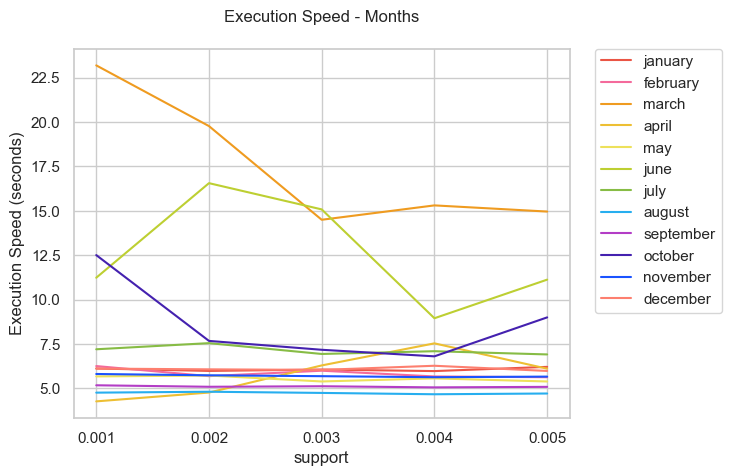

In [421]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

months_execution_speed = pd.DataFrame({
    'support': minimum_support_values,
    'january': january_fpgrowth_execution_times,
    'february': february_fpgrowth_execution_times,
    'march': march_fpgrowth_execution_times,
    'april': april_fpgrowth_execution_times,
    'may': may_fpgrowth_execution_times,
    'june': june_fpgrowth_execution_times,
    'july': july_fpgrowth_execution_times,
    'august': august_fpgrowth_execution_times,
    'september': september_fpgrowth_execution_times,
    'october': october_fpgrowth_execution_times,
    'november': november_fpgrowth_execution_times,
    'december': december_fpgrowth_execution_times
})

cols = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", "#4421af", "#1a53ff", "#fd7f6f"]
sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Months', 
             data=pd.melt(months_execution_speed, ['support'], var_name='Months', value_name='Execution Speed (seconds)'), palette=cols)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Months', x=0.5, y=1.05)

In [468]:
months_execution_speed

support  january  february   march  april    may    june   july  august   
0   0.0010   6.1257    6.2624 23.1853 4.2749 5.6799 11.2342 7.2071  4.7661  \
1   0.0020   5.9889    5.6952 19.7681 4.7717 5.7296 16.5561 7.5526  4.8173   
2   0.0030   6.0658    6.0004 14.4958 6.2977 5.3953 15.0792 6.9429  4.7506   
3   0.0040   5.9793    5.6773 15.3048 7.5403 5.5684  8.9533 7.0984  4.6754   
4   0.0050   6.2172    5.6347 14.9577 6.1139 5.3947 11.1260 6.9167  4.7174   

   september  october  november  december  
0     5.1803  12.5075    5.8162    6.1204  
1     5.0965   7.6778    5.7419    6.0779  
2     5.1266   7.1787    5.6926    6.0457  
3     5.0627   6.8096    5.6349    6.2792  
4     5.0920   9.0016    5.6681    5.9877

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196ad142100>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Months vs All Data')

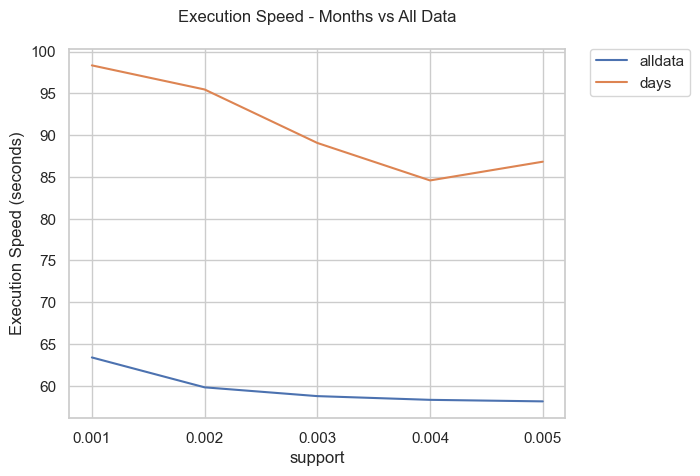

In [353]:
# Use list comprehension and zip to sum up corresponding elements
combined_months_speed = [sum(items) for items in zip(january_fpgrowth_execution_times,
                                                     february_fpgrowth_execution_times,
                                                     march_fpgrowth_execution_times,
                                                     april_fpgrowth_execution_times,
                                                     may_fpgrowth_execution_times,
                                                     june_fpgrowth_execution_times,
                                                     july_fpgrowth_execution_times,
                                                     august_fpgrowth_execution_times,
                                                     september_fpgrowth_execution_times,
                                                     october_fpgrowth_execution_times,
                                                     november_fpgrowth_execution_times,
                                                     december_fpgrowth_execution_times)]


months_vs_alldata_speed = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_execution_times,
                   'days': combined_months_speed})

sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Months', 
             data=pd.melt(months_vs_alldata_speed, ['support'], var_name='Months', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Months vs All Data', x=0.5, y=1.05)



attribute  total_speed
0    months      98.3600
1   alldata      63.3897

<Axes: xlabel='attribute', ylabel='total_speed'>

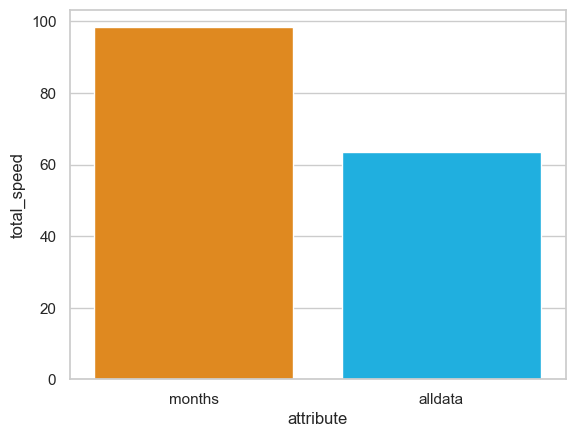

In [374]:
months_vs_alldata_speed_bar = pd.DataFrame({'attribute': ['months', 'alldata'],
                                    'total_speed': [combined_months_speed[0], alldata_apriori_execution_times[0]]})

months_vs_alldata_speed_bar

cols = ['deepskyblue' if (x < months_vs_alldata_speed_bar['total_speed'].max()) 
        else 'darkorange' for x in months_vs_alldata_speed_bar['total_speed']]

sb.barplot(data=months_vs_alldata_speed_bar, x="attribute", y="total_speed", palette=cols)

### MEMORY USED

<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196b1869d90>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - Months')

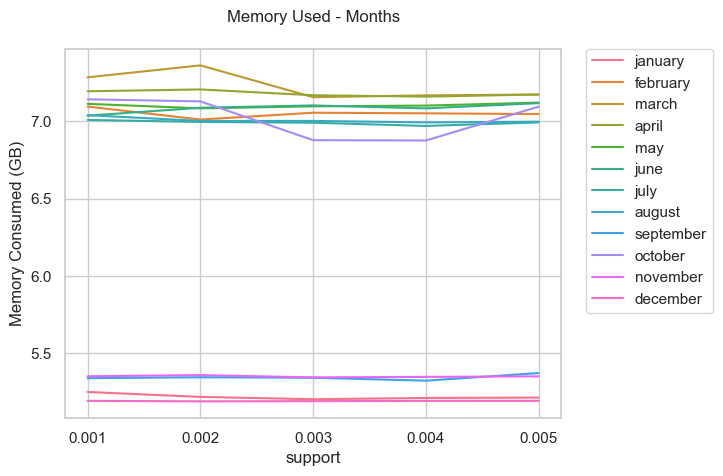

In [375]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

months_memory_consumed = pd.DataFrame({
    'support': minimum_support_values,
    'january': january_fpgrowth_memory_consumed,
    'february': february_fpgrowth_memory_consumed,
    'march': march_fpgrowth_memory_consumed,
    'april': april_fpgrowth_memory_consumed,
    'may': may_fpgrowth_memory_consumed,
    'june': june_fpgrowth_memory_consumed,
    'july': july_fpgrowth_memory_consumed,
    'august': august_fpgrowth_memory_consumed,
    'september': september_fpgrowth_memory_consumed,
    'october': october_fpgrowth_memory_consumed,
    'november': november_fpgrowth_memory_consumed,
    'december': december_fpgrowth_memory_consumed
})


sb.lineplot(x='support', y='Memory Consumed (GB)', hue='Months', 
             data=pd.melt(months_memory_consumed, ['support'], var_name='Months', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - Months', x=0.5, y=1.05)

In [472]:
months_memory_consumed

support  january  february  march  april    may   june   july  august   
0   0.0010   5.2486    7.0955 7.2849 7.1946 7.1133 7.0367 7.0090  7.0402  \
1   0.0020   5.2169    7.0117 7.3622 7.2065 7.0841 7.0879 6.9963  7.0025   
2   0.0030   5.2017    7.0558 7.1564 7.1688 7.0972 7.1030 6.9911  7.0029   
3   0.0040   5.2100    7.0519 7.1682 7.1600 7.1021 7.0840 6.9704  6.9930   
4   0.0050   5.2125    7.0472 7.1734 7.1737 7.1212 7.1178 6.9931  6.9977   

   september  october  november  december  
0     5.3381   7.1425    5.3505    5.1915  
1     5.3439   7.1292    5.3579    5.1879  
2     5.3408   6.8783    5.3432    5.1892  
3     5.3218   6.8760    5.3465    5.1912  
4     5.3712   7.0949    5.3498    5.1914

<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196b3913b80>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - Months vs All Data')

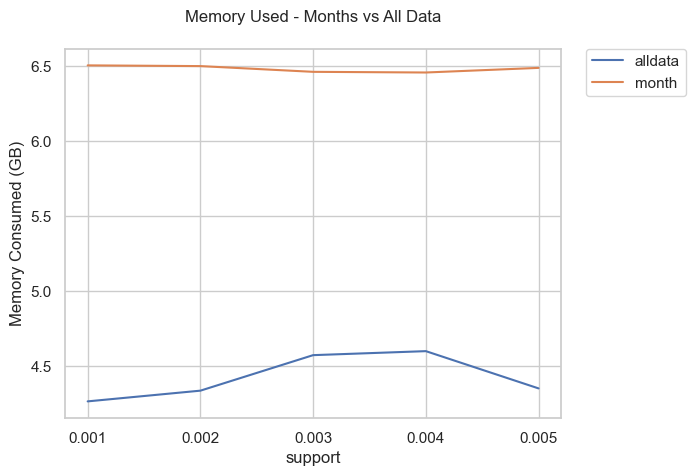

In [383]:
# Use list comprehension and zip to sum up corresponding elements
combined_months_memory = [mean(items) for items in zip(january_fpgrowth_memory_consumed,
                                                     february_fpgrowth_memory_consumed,
                                                     march_fpgrowth_memory_consumed,
                                                     april_fpgrowth_memory_consumed,
                                                     may_fpgrowth_memory_consumed,
                                                     june_fpgrowth_memory_consumed,
                                                     july_fpgrowth_memory_consumed,
                                                     august_fpgrowth_memory_consumed,
                                                     september_fpgrowth_memory_consumed,
                                                     october_fpgrowth_memory_consumed,
                                                     november_fpgrowth_memory_consumed,
                                                     december_fpgrowth_memory_consumed)]


months_vs_alldata_memory = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_memory_consumed,
                   'month': combined_months_memory})

sb.lineplot(x='support', y='Memory Consumed (GB)', hue='Months', 
             data=pd.melt(months_vs_alldata_memory, ['support'], var_name='Months', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - Months vs All Data', x=0.5, y=1.05)



In [385]:
months_vs_alldata_memory_bar = pd.DataFrame({'attribute': ['months', 'alldata'],
                                    'average_memory': [combined_months_memory[0], alldata_apriori_memory_consumed[0]]})

months_vs_alldata_memory_bar

cols = ['deepskyblue' if (x < months_vs_alldata_memory_bar['average_memory'].max()) 
        else 'darkorange' for x in months_vs_alldata_memory_bar['average_memory']]

sb.barplot(data=months_vs_alldata_memory_bar, x="attribute", y="average_memory", palette=cols)

attribute  average_memory
0    months          6.5038
1   alldata          4.2631

<Axes: xlabel='attribute', ylabel='average_memory'>

### Mining Association Rules by High Value Items

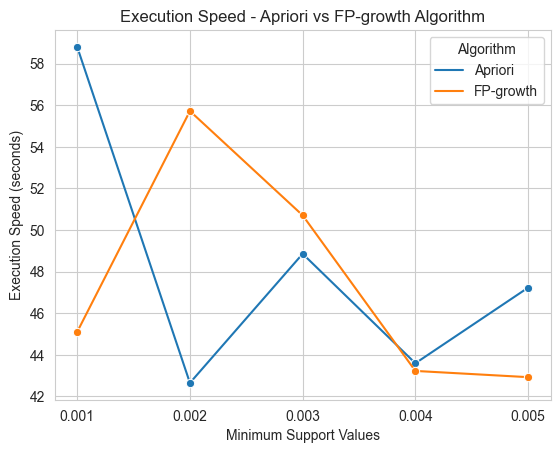

In [51]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
profit_fpgrowth_extracted_rules, profit_fpgrowth_execution_times, profit_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, profit=True, algorithm=fpgrowth)

# Access the association rules variables
profit_fpgrowth_rules_1 = profit_fpgrowth_extracted_rules[0]
profit_fpgrowth_rules_2 = profit_fpgrowth_extracted_rules[1]
profit_fpgrowth_rules_3 = profit_fpgrowth_extracted_rules[2]
profit_fpgrowth_rules_4 = profit_fpgrowth_extracted_rules[3]
profit_fpgrowth_rules_5 = profit_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
profit_apriori_extracted_rules, profit_apriori_execution_times, profit_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, profit=True, algorithm=apriori)

# Access the association rules variables
profit_apriori_rules_1 = profit_apriori_extracted_rules[0]
profit_apriori_rules_2 = profit_apriori_extracted_rules[1]
profit_apriori_rules_3 = profit_apriori_extracted_rules[2]
profit_apriori_rules_4 = profit_apriori_extracted_rules[3]
profit_apriori_rules_5 = profit_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=profit_apriori_execution_times,
                           fpgrowth_values=profit_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=profit_apriori_memory_consumed,
                           fpgrowth_values=profit_fpgrowth_memory_consumed, memory_consumption=True)

#Viewing Rules
# similar_association_rules(profit_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'profit', 'alldata')
# difference_association_rules(profit_fpgrowth_rules_1, alldata_fpgrowth_rules_1, 'profit', 'alldata')

In [180]:
differential_sales_data[differential_sales_data['Item Rate'] >= 4200.0000].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Item Rate'] >= 4200.0000])
len(x)
average_list_length(x)

len(profit_fpgrowth_rules_1.sort_values('support', ascending=False))
len(profit_apriori_rules_1.sort_values('support', ascending=False))

len(profit_fpgrowth_rules_2.sort_values('support', ascending=False))
len(profit_apriori_rules_2.sort_values('support', ascending=False))

len(profit_fpgrowth_rules_3.sort_values('support', ascending=False))
len(profit_apriori_rules_3.sort_values('support', ascending=False))

len(profit_fpgrowth_rules_4.sort_values('support', ascending=False))
len(profit_apriori_rules_4.sort_values('support', ascending=False))

len(profit_fpgrowth_rules_5.sort_values('support', ascending=False))
len(profit_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(profit_apriori_execution_times)
sum(profit_fpgrowth_execution_times)

mean(profit_apriori_memory_consumed)
mean(profit_fpgrowth_memory_consumed)

similar_association_rules(profit_apriori_rules_1, profit_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 195505 entries, 5812 to 769071
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction ID    195505 non-null  object        
 1   Transaction Date  195505 non-null  datetime64[ns]
 2   Sale Year         195505 non-null  int32         
 3   Sale Month        195505 non-null  object        
 4   Sale Day          195505 non-null  object        
 5   Sale Day Type     195505 non-null  object        
 6   Item Code         195505 non-null  int64         
 7   Item Name         195505 non-null  object        
 8   Major Category    195505 non-null  object        
 9   Units             195505 non-null  int64         
 10  Sold Qty          195505 non-null  float64       
 11  Purchase Price    195505 non-null  float64       
 12  Item Rate         195505 non-null  float64       
 13  Item Profit (%)   195505 non-null  float64       
 14  Sale P

131979

1.4813341516453375

272

272

96

96

54

54

34

34

30

30

241.13705778121948

237.68567204475403

6.684094464

6.7680821248

Association_Rule  Lift_apriori   
111                  ['FRIED RICE'] => ['EGG SAUCE']        2.3469  \
176                       ['ASUN'] => ['WHITE RICE']        2.6870   
145               ['COWLEG STEW'] => ['JOLLOF RICE']        5.1699   
124  ['TITUS FISH', 'JOLLOF RICE'] => ['FRIED RICE']        3.6423   
244               ['FRIED RICE'] => ['CHICKEN STEW']        6.4421   
185     ['TITUS FISH'] => ['CHOPPED FRIED PLANTAIN']        5.3315   
83                 ['FRIED RICE'] => ['COWLEG STEW']        5.2319   
206    ['CHOPPED FRIED PLANTAIN'] => ['OFADA SAUCE']        5.3335   
50    ['JOLLOF RICE', 'CHICKEN PIE'] => ['MEAT PIE']        3.0066   
195                  ['EGG SAUCE'] => ['FRIED RICE']        2.3469   

     Lift_fp-growth  
111          2.3469  
176          2.6870  
145          5.1699  
124          3.6423  
244          6.4421  
185          5.3315  
83           5.2319  
206          5.3335  
50           3.0066  
195          2.3469

## COMPARING HIGH VALUE WITH TRADITIONAL APPROACH

### RULES

In [490]:
profit_names= ['alldata','profit']

rules_list_profit = [alldata_fpgrowth_rules_1, profit_fpgrowth_rules_1]

compare1_association_rules(df_list=rules_list_profit, lift_column_names=profit_names).head(20)

Association_Rule   
0                                                  ['FRIED RICE'] => ['FRIED CROAKER FISH']  \
1                                                       ['CHICKEN SUYA'] => ['JOLLOF RICE']   
2                                                      ['JOLLOF RICE'] => ['POTTAGE BEANS']   
3                                                      ['FRIED RICE'] => ['GOAT MEAT STEW']   
4                                                      ['GOAT MEAT STEW'] => ['FRIED RICE']   
5                                                         ['WHITE RICE'] => ['OFADA SAUCE']   
6                                    ['MILO SACHET BIG 1KG'] => ['FAMILY WHITE BREAD 950G']   
7                                        ['FRIED RICE', 'FRIED CHICKEN'] => ['JOLLOF RICE']   
8                                                        ['JOLLOF RICE'] => ['OFADA SAUCE']   
9                                                          ['FRIED RICE'] => ['TITUS FISH']   
10                                                    ['GOAT MEAT STEW'] => ['JOLLOF RICE']   
11  ['PEAK MILK REFILL POUCH FULL CREAM 400G / 380G'] => ['MILO SACHET MEDIUM 500G / 550G']   
12                                                     ['POTTAGE BEANS'] => ['JOLLOF RICE']   
13                                                        ['JOLLOF RICE'] => ['FRIED RICE']   
14                                        ['JOLLOF RICE'] => ['PUFF PUFF', 'FRIED CHICKEN']   
15                                                     ['JOLLOF RICE'] => ['FRIED CHICKEN']   
16                        ['FAMILY WHITE BREAD 950G'] => ['MILO SACHET MEDIUM 500G / 550G']   
17                                       ['FRIED CHICKEN'] => ['FRIED RICE', 'JOLLOF RICE']   
18                                                          ['WHITE RICE'] => ['BEEF STEW']   
19                                             ['PUFF PUFF', 'CHICKEN PIE'] => ['MEAT PIE']   

    alldata  profit  
0    7.8756  4.1157  
1    9.2565  4.8374  
2    4.8410  2.5299  
3    9.9612  5.2056  
4    9.9612  5.2056  
5   18.3782  9.6043  
6    3.1600  1.6514  
7    6.3474  3.3171  
8    4.9988  2.6123  
9   10.5141  5.4946  
10  10.7932  5.6405  
11  42.9227 22.4310  
12   4.8410  2.5299  
13   5.3111  2.7755  
14   7.9316  4.1450  
15   8.9863  4.6962  
16   2.9208  1.5264  
17  13.4285  7.0176  
18  11.3162  5.9137  
19   5.6293  2.9418

In [504]:
data_anal = compare2_association_rules(df_list=rules_list_profit, lift_column_names=profit_names)
filtered_df = data_anal[~pd.isna(data_anal['alldata'])]
filtered_df.head(20)

Association_Rule   
1                                     ['PLAIN DOUGHNUT'] => ['SAUSAGE ROLL']  \
2   ['FANTA  ORANGE (PET) 35CL'] => ['SPRITE (PET) 35CL', 'COKE (PET) 35CL']   
3   ['GOLDEN MORN MAIZE & SOYA PROTEIN 450G'] => ['FAMILY WHITE BREAD 950G']   
5                                           ['CHICKEN SUYA'] => ['MEAT PIE']   
6                              ['MIRINDA ORANGE (PET) 50CL'] => ['MEAT PIE']   
9                              ['COKE ORIGINAL (PET)  60CL'] => ['MEAT PIE']   
10                         ['MIRINDA PINEAPPLE (PET) 50CL'] => ['PUFF PUFF']   
14             ['NESCAFE BREAKFAST 3IN1 32G'] => ['FAMILY WHITE BREAD 950G']   
15                                    ['FISH ROLL/ PIE'] => ['SAUSAGE ROLL']   
16                             ['NESTLE H2O (SMALL) 60CL'] => ['FRIED RICE']   
17              ['5 ALIVE PULPY ORANGE  (PET) 40CL / 30CL'] => ['PUFF PUFF']   
19       ['PEAK MILK POWDER SACHET 16G'] => ['MILO 20g (ENERGY FOOD DRINK)']   
21                                      ['JOLLOF RICE'] => ['FRIED CHICKEN']   
22                                              ['MOI-MOI'] => ['PUFF PUFF']   
24                 ['FAMILY WHITE BREAD 950G'] => ['MILO SACHET SMALL 200G']   
25                                    ['SAUSAGE ROLL'] => ['FISH ROLL/ PIE']   
27                             ['FRIED RICE'] => ['NESTLE H2O (SMALL) 60CL']   
28                                              ['CROISSANT'] => ['RAISINS']   
30                       ['FRUIT BREAD 550g'] => ['FAMILY WHITE BREAD 950G']   
32          ['GOLDEN PENNY SUGAR CUBES 500g'] => ['FAMILY WHITE BREAD 950G']   

    alldata  profit  
1    9.2297     NaN  
2   41.1199     NaN  
3    2.2721     NaN  
5    1.5725     NaN  
6    1.7208     NaN  
9    1.9958     NaN  
10   2.4197     NaN  
14   2.6296     NaN  
15  12.2603     NaN  
16   1.5296     NaN  
17   1.5798     NaN  
19  43.4242     NaN  
21   8.9863  4.6962  
22   2.4914     NaN  
24   3.1973     NaN  
25  12.2603     NaN  
27   1.5296     NaN  
28  40.2760     NaN  
30   1.8493     NaN  
32   2.9416     NaN

### RUNTIME

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196b3e638e0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Profit')

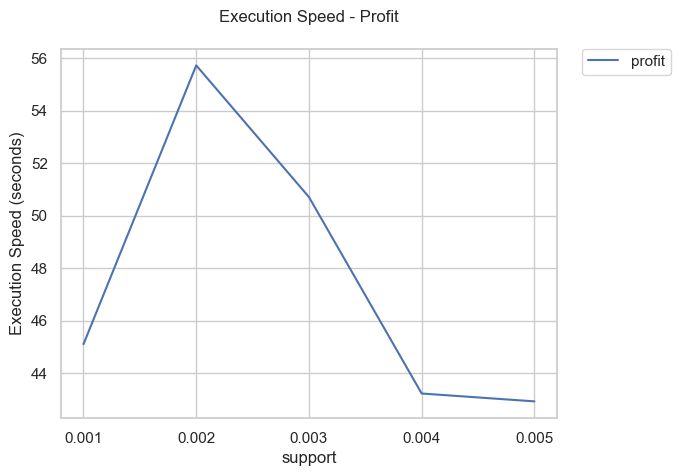

In [393]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

profit_execution_speed = pd.DataFrame({
    'support': minimum_support_values,
    'profit': profit_fpgrowth_execution_times})


sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Profit', 
             data=pd.melt(profit_execution_speed, ['support'], var_name='Profit', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Profit', x=0.5, y=1.05)

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196b533eca0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - Profit vs All Data')

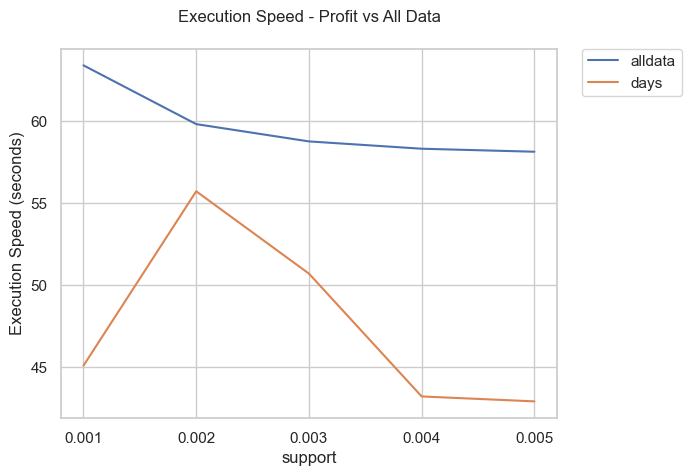

In [398]:
# Use list comprehension and zip to sum up corresponding elements
profit_speed = [sum(items) for items in zip(profit_fpgrowth_execution_times)]


profit_vs_alldata_speed = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_execution_times,
                   'days': profit_speed})

sb.lineplot(x='support', y='Execution Speed (seconds)', hue='Profit', 
             data=pd.melt(profit_vs_alldata_speed, ['support'], var_name='Profit', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - Profit vs All Data', x=0.5, y=1.05)



In [400]:
profit_vs_alldata_speed_bar = pd.DataFrame({'attribute': ['profit', 'alldata'],
                                    'total_speed': [profit_speed[0], alldata_apriori_execution_times[0]]})

profit_vs_alldata_speed_bar

cols = ['deepskyblue' if (x < profit_vs_alldata_speed_bar['total_speed'].max()) 
        else 'darkorange' for x in profit_vs_alldata_speed_bar['total_speed']]

sb.barplot(data=profit_vs_alldata_speed_bar, x="attribute", y="total_speed", palette=cols)

attribute  total_speed
0    profit      45.1041
1   alldata      63.3897

<Axes: xlabel='attribute', ylabel='total_speed'>

### MEMORY

In [401]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

profit_memory_consumed = pd.DataFrame({
    'support': minimum_support_values,
    'profit': profit_fpgrowth_memory_consumed
})


sb.lineplot(x='support', y='Memory Consumed (GB)', hue='Profit', 
             data=pd.melt(profit_memory_consumed, ['support'], var_name='Profit', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - Profit', x=0.5, y=1.05)

<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196b584c670>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - Profit')

<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196b589e760>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - Profit vs All Data')

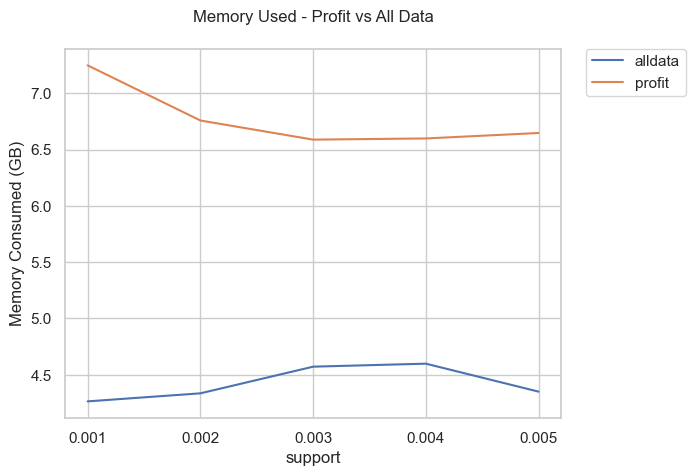

In [405]:
# Use list comprehension and zip to sum up corresponding elements
profit_memory = [mean(items) for items in zip(profit_fpgrowth_memory_consumed)]


profit_vs_alldata_memory = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_memory_consumed,
                   'profit': profit_memory})

sb.lineplot(x='support', y='Memory Consumed (GB)', hue='Profit', 
             data=pd.melt(profit_vs_alldata_memory, ['support'], var_name='Profit', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - Profit vs All Data', x=0.5, y=1.05)



attribute  average_memory
0    profit          7.2479
1   alldata          4.2631

<Axes: xlabel='attribute', ylabel='average_memory'>

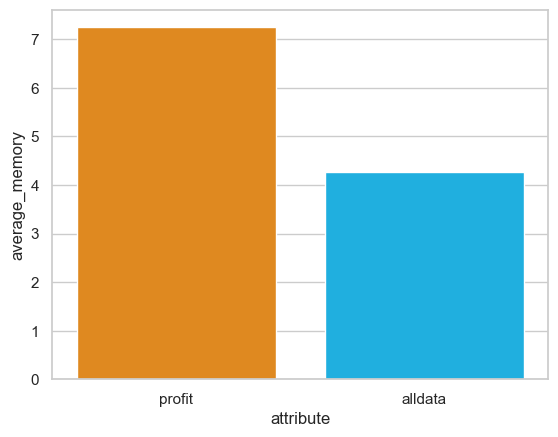

In [404]:
profit_vs_alldata_memory_bar = pd.DataFrame({'attribute': ['profit', 'alldata'],
                                    'average_memory': [profit_memory[0], alldata_apriori_memory_consumed[0]]})

profit_vs_alldata_memory_bar

cols = ['deepskyblue' if (x < profit_vs_alldata_memory_bar['average_memory'].max()) 
        else 'darkorange' for x in profit_vs_alldata_memory_bar['average_memory']]

sb.barplot(data=profit_vs_alldata_memory_bar, x="attribute", y="average_memory", palette=cols)

## Specific Days

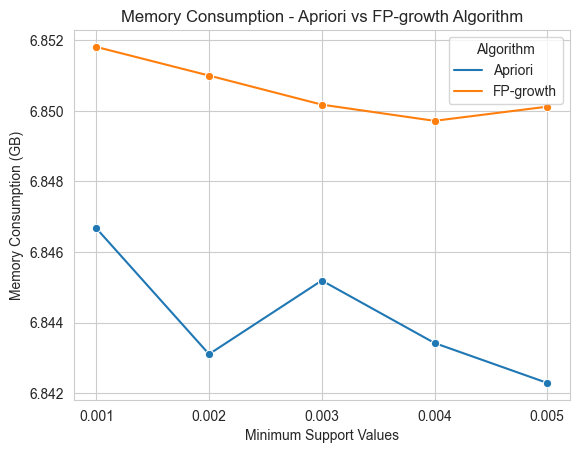

In [52]:
# Define the minimum thresholds
min_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

# Call the function to extract association rules and measure execution times
exact_day_fpgrowth_extracted_rules, exact_day_fpgrowth_execution_times, exact_day_fpgrowth_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, exact_day=[pd.Timestamp('2020-12-24 00:00:00')], algorithm=fpgrowth)

# Access the association rules variables
exact_day_fpgrowth_rules_1 = exact_day_fpgrowth_extracted_rules[0]
exact_day_fpgrowth_rules_2 = exact_day_fpgrowth_extracted_rules[1]
exact_day_fpgrowth_rules_3 = exact_day_fpgrowth_extracted_rules[2]
exact_day_fpgrowth_rules_4 = exact_day_fpgrowth_extracted_rules[3]
exact_day_fpgrowth_rules_5 = exact_day_fpgrowth_extracted_rules[4]


# Call the function to extract association rules and measure execution times
exact_day_apriori_extracted_rules, exact_day_apriori_execution_times, exact_day_apriori_memory_consumed = extract_association_rules(differential_sales_data, min_support_values, exact_day=[pd.Timestamp('2020-12-24 00:00:00')], algorithm=apriori)

# Access the association rules variables
exact_day_apriori_rules_1 = exact_day_apriori_extracted_rules[0]
exact_day_apriori_rules_2 = exact_day_apriori_extracted_rules[1]
exact_day_apriori_rules_3 = exact_day_apriori_extracted_rules[2]
exact_day_apriori_rules_4 = exact_day_apriori_extracted_rules[3]
exact_day_apriori_rules_5 = exact_day_apriori_extracted_rules[4]

plot_algorithm_performance(min_support_values, apriori_values=exact_day_apriori_execution_times,
                           fpgrowth_values=exact_day_fpgrowth_execution_times, memory_consumption=False)

plot_algorithm_performance(min_support_values, apriori_values=exact_day_apriori_memory_consumed,
                           fpgrowth_values=exact_day_fpgrowth_memory_consumed, memory_consumption=True)

In [406]:
differential_sales_data[differential_sales_data['Transaction Date'] == pd.Timestamp('2020-12-24 00:00:00')].info()

x = transactions_to_nestedlist(differential_sales_data[differential_sales_data['Transaction Date'] == pd.Timestamp('2020-12-24 00:00:00')])
len(x)
average_list_length(x)

len(exact_day_fpgrowth_rules_1.sort_values('support', ascending=False))
len(exact_day_apriori_rules_1.sort_values('support', ascending=False))

len(exact_day_fpgrowth_rules_2.sort_values('support', ascending=False))
len(exact_day_apriori_rules_2.sort_values('support', ascending=False))

len(exact_day_fpgrowth_rules_3.sort_values('support', ascending=False))
len(exact_day_apriori_rules_3.sort_values('support', ascending=False))

len(exact_day_fpgrowth_rules_4.sort_values('support', ascending=False))
len(exact_day_apriori_rules_4.sort_values('support', ascending=False))

len(exact_day_fpgrowth_rules_5.sort_values('support', ascending=False))
len(exact_day_apriori_rules_5.sort_values('support', ascending=False))

from statistics import mean
sum(exact_day_apriori_execution_times)
sum(exact_day_fpgrowth_execution_times)

mean(exact_day_apriori_memory_consumed)
mean(exact_day_fpgrowth_memory_consumed)

similar_association_rules(exact_day_apriori_rules_1, exact_day_fpgrowth_rules_1, 'apriori', 'fp-growth').sample(frac=1).head()

<class 'pandas.core.frame.DataFrame'>
Index: 4078 entries, 240 to 743015
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    4078 non-null   object        
 1   Transaction Date  4078 non-null   datetime64[ns]
 2   Sale Year         4078 non-null   int32         
 3   Sale Month        4078 non-null   object        
 4   Sale Day          4078 non-null   object        
 5   Sale Day Type     4078 non-null   object        
 6   Item Code         4078 non-null   int64         
 7   Item Name         4078 non-null   object        
 8   Major Category    4078 non-null   object        
 9   Units             4078 non-null   int64         
 10  Sold Qty          4078 non-null   float64       
 11  Purchase Price    4078 non-null   float64       
 12  Item Rate         4078 non-null   float64       
 13  Item Profit (%)   4078 non-null   float64       
 14  Sale Profit       4078 no

1100

3.707272727272727

4420

4420

694

694

278

278

144

144

94

94

3.3982465267181396

3.1383187770843506

6.8441391104000004

6.8505632768

Association_Rule   
553       ['HERO CAN 500ML', 'ORIJIN ZERO NON ALCOHOLIC 33cl'] => ['SPRITE (PET) 60CL']  \
318                                        ['TIGER GINGER 100G'] => ['TIGER THYME 50G']   
410         ['HEINEKEN CAN 33CL', 'GULDER 60CL'] => ['AMSTEL CAN MALTA LOW SUGAR 33CL']   
856              ['HEINEKEN CAN 33CL', 'MALTA GUINNESS CAN 33CL'] => ['HERO CAN 500ML']   
2899  ['COKE ORIGINAL (PET)  60CL'] => ['MALTINA CAN 33CL', 'MALTINA VANILLA 33CL CAN']   

      Lift_apriori  Lift_fp-growth  
553        18.8034         18.8034  
318       104.7619        104.7619  
410        23.6559         23.6559  
856         7.1739          7.1739  
2899        8.7302          8.7302

## COMPARING SPECIFIC DAY WITH TRADITIONAL APPROACH

### RULES

In [517]:
specific_names= ['alldata','24th Dec']

rules_list_24th = [alldata_fpgrowth_rules_1, exact_day_fpgrowth_rules_1]

compare1_association_rules(df_list=rules_list_24th, lift_column_names=specific_names).head(20)

Association_Rule  alldata   
0      ['COKE ORIGINAL (CAN) 33CL'] => ['FANTA ORANGE CAN 33CL']  71.7845  \
1                            ['CHICKEN SUYA'] => ['JOLLOF RICE']   9.2565   
2                         ['PLAIN DOUGHNUT'] => ['SAUSAGE ROLL']   9.2297   
3                              ['HOT DOG'] => ['PLAIN DOUGHNUT']   8.2734   
4           ['SPRITE (PET) 60CL'] => ['FANTA ORANGE (PET) 60CL']  11.0013   
5                    ['CHOPPED FRIED PLANTAIN'] => ['PUFF PUFF']   1.8606   
6                           ['JOLLOF RICE'] => ['POTTAGE BEANS']   4.8410   
7                  ['MIRINDA ORANGE (PET) 50CL'] => ['MEAT PIE']   1.7208   
8                                ['SCOTCH EGG'] => ['PUFF PUFF']   2.6171   
9   ['PUFF PUFF'] => ['5 ALIVE PULPY ORANGE  (PET) 40CL / 30CL']   1.5798   
10            ['BREAKFAST ROLLS'] => ['FAMILY WHITE BREAD 950G']   2.7485   
11                               ['BOILED YAM'] => ['EGG SAUCE'] 118.6882   
12                 ['COKE ORIGINAL (PET)  60CL'] => ['MEAT PIE']   1.9958   
13        ['MILO SACHET BIG 1KG'] => ['FAMILY WHITE BREAD 950G']   3.1600   
14                                   ['MEAT PIE'] => ['HOT DOG']   5.1638   
15                               ['EGG SAUCE'] => ['BOILED YAM'] 118.6882   
16                            ['JOLLOF RICE'] => ['OFADA SAUCE']   4.9988   
17                         ['SPRITE (PET) 60CL'] => ['MEAT PIE']   2.1102   
18                                 ['MEAT PIE'] => ['PUFF PUFF']   1.7016   
19                              ['FRIED RICE'] => ['TITUS FISH']  10.5141   

    24th Dec  
0    56.4103  
1     6.7901  
2    22.9167  
3    21.1538  
4     8.4615  
5     1.6858  
6    10.1852  
7     2.2665  
8     5.7471  
9     1.7241  
10    6.2678  
11  220.0000  
12    2.3384  
13    3.1339  
14    6.0440  
15  220.0000  
16   12.2222  
17    3.0220  
18    2.4836  
19   20.3704

### EXECUTION SPEED

In [407]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

specificday_execution_speed = pd.DataFrame({
    'support': minimum_support_values,
    'specificday': exact_day_fpgrowth_execution_times})


sb.lineplot(x='support', y='Execution Speed (seconds)', hue='SpecificDay', 
             data=pd.melt(specificday_execution_speed, ['support'], var_name='SpecificDay', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - 24th December 2020', x=0.5, y=1.05)

<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196ad2177f0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - 24th December 2020')

In [410]:
# Use list comprehension and zip to sum up corresponding elements
specificday_speed = [sum(items) for items in zip(exact_day_fpgrowth_execution_times)]


specificday_vs_alldata_speed = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_execution_times,
                   '24th Dec 2020': specificday_speed})

sb.lineplot(x='support', y='Execution Speed (seconds)', hue='SpecificDay', 
             data=pd.melt(specificday_vs_alldata_speed, ['support'], var_name='SpecificDay', value_name='Execution Speed (seconds)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Execution Speed - 24th December 2020 vs All Data', x=0.5, y=1.05)



<Axes: xlabel='support', ylabel='Execution Speed (seconds)'>

([<matplotlib.axis.XTick at 0x196a450c310>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Execution Speed - 24th December 2020 vs All Data')

attribute  total_speed
0  24th Dec       0.6750
1   alldata      63.3897

<Axes: xlabel='attribute', ylabel='total_speed'>

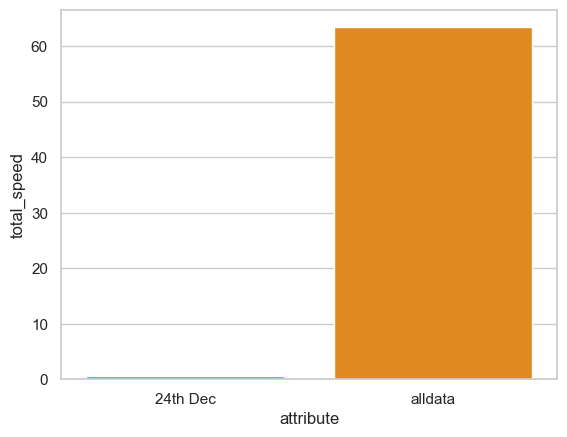

In [506]:
specificday_vs_alldata_speed_bar = pd.DataFrame({'attribute': ['24th Dec', 'alldata'],
                                    'total_speed': [specificday_speed[0], alldata_apriori_execution_times[0]]})

specificday_vs_alldata_speed_bar

cols = ['deepskyblue' if (x < specificday_vs_alldata_speed_bar['total_speed'].max()) 
        else 'darkorange' for x in specificday_vs_alldata_speed_bar['total_speed']]

sb.barplot(data=specificday_vs_alldata_speed_bar, x="attribute", y="total_speed", palette=cols)

## MEMORY USED

In [414]:
# Minimum support values
minimum_support_values = [0.001, 0.002, 0.003, 0.004, 0.005]

specificday_memory_consumed = pd.DataFrame({
    'support': minimum_support_values,
    '24th Dec 2020': exact_day_fpgrowth_memory_consumed
})


sb.lineplot(x='support', y='Memory Consumed (GB)', hue='SpecificDay', 
             data=pd.melt(specificday_memory_consumed, ['support'], var_name='SpecificDay', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - 24th December 2020', x=0.5, y=1.05)

<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196a6d18070>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - 24th December 2020')

In [415]:
# Use list comprehension and zip to sum up corresponding elements
specificday_memory = [mean(items) for items in zip(exact_day_fpgrowth_memory_consumed)]


specificday_vs_alldata_memory = pd.DataFrame({'support': minimum_support_values,
                   'alldata': alldata_apriori_memory_consumed,
                   '24th Dec 2020': specificday_memory})

sb.lineplot(x='support', y='Memory Consumed (GB)', hue='SpecificDay', 
             data=pd.melt(specificday_vs_alldata_memory, ['support'], var_name='SpecificDay', value_name='Memory Consumed (GB)'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(minimum_support_values)
plt.title('Memory Used - 24th December 2020 vs All Data', x=0.5, y=1.05)



<Axes: xlabel='support', ylabel='Memory Consumed (GB)'>

([<matplotlib.axis.XTick at 0x196881ee7c0>,
 [Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003'),
  Text(0.004, 0, '0.004'),
  Text(0.005, 0, '0.005')])

Text(0.5, 1.05, 'Memory Used - 24th December 2020 vs All Data')

attribute  average_memory
0  24th Dec 2020          6.8518
1        alldata          4.2631

<Axes: xlabel='attribute', ylabel='average_memory'>

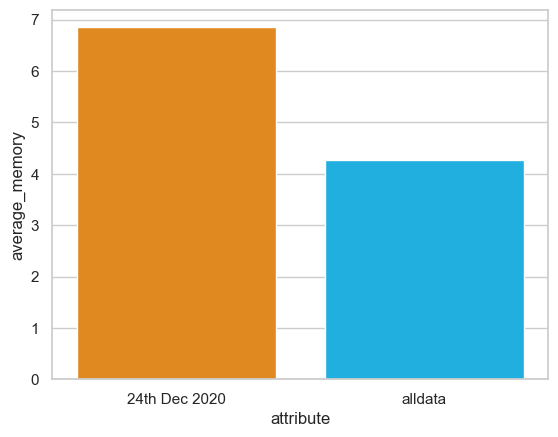

In [416]:
specificday_vs_alldata_memory_bar = pd.DataFrame({'attribute': ['24th Dec 2020', 'alldata'],
                                    'average_memory': [specificday_memory[0], alldata_apriori_memory_consumed[0]]})

specificday_vs_alldata_memory_bar

cols = ['deepskyblue' if (x < specificday_vs_alldata_memory_bar['average_memory'].max()) 
        else 'darkorange' for x in specificday_vs_alldata_memory_bar['average_memory']]

sb.barplot(data=specificday_vs_alldata_memory_bar, x="attribute", y="average_memory", palette=cols)